# Final Project: Predicting the Microbiome Environment

## Group 8

In our experiment we had two cohorts of mice. **Mice 2-5** received a fecal transplant from a **Healthy** human donor. **Mice 6-10** received am FMT from a human donor with **Ulcerative Colitis (UC)**. We refer to these mouse cohorts as the Healthy and UC cohorts.  

In this notebook we will explore the trends and impact of 3 perturbations on the 9 mice, and will build a model to predict future quantitative counts and distributions of bacteria in the microbiome

---

# **Motivation, Context, and Framing of the Problem**

Healthcare is one of the primary sectors that directly impacts the life of people and has seen improvement due to Data Science. It has helped to detect early stage health issues like Tumors and auto immune disease by using advanced statistical and machine learning methods.

As the human gut is believed to be vast reservoir of antibiotics resistance genes, there is growing demand for a more quantitative knowledge base that can help in prediction of the impact of antiobiotics on the human microbiome. Current methodologies involve a crude way of assumptions to get the outcome in the field of antimicrobial treatment programs that comprises of DNA sequencing )(e.g. MGS ( metagenomic shotgun) or 16S rRNA). 

The problems we want to address in this study are to
1. accurately forecast what the environment will be before a perturbation occurs conditional on gut health and
2. identify heterogeneous effects of perturbation on individuals with different gut health and how the perturbations impact the latent steady state of the microbiome

Specifically, we plan to use a Linear Regression, LASSO, LSTM and GRU to forecast the microbiome distribution of bacteria, conditioning on gut health. We then plan to assess and identify any differences in the two steady states between the ‘healthy’ and ‘Ulcerative Colitis’ mice. Indeed, the study of how a perturbation impacts the latent steady state is critical as the environmental makeup of the microbiome is increasingly being linked to severe health outcomes such as different auto-immune diseases and even mental illness.

The more specific motivations for this study are many and wide-reaching. Two key motivations are that such a model, if done correctly, would, one, allow for accurate forecasting of the microbiome environment after a perturbation occurs, and, two, help identify heterogeneous effects that a perturbation can have on individuals with different gut health. Indeed, this model, when coupled with the relevant research, may help identify damaging perturbations for individuals with different gut health and allow for more targeted remedies for those with ulcerative colitis.

Answering these questions would start to provide much needed insight into how perturbations affect the long-term environment of the microbiome, conditioning on gut health.



# **Description of the data and how it was handled**

We have a maximum of 77 samples for each of the 9 non-control mice in the data. Of the 9 mice, 4 had healthy human fecal matter inserted, and 5 had human fecal matter with Ulcerative Colitis inserted. Each sample is analyzed for the counts of over 1400 microbes.

The data consisted of bacteria (ie. ASV) read counts for each sample and taxonomic information down to species level. The data provided composed of multiple .csv files distributed in 5 major parts that can be combined with the help of common keys, such as ASV number, subject, and time.

The primary portion of data for our analysis purpose relate to the relative counts of each ASV in each sample (in the file ‘counts.tsv’). To normalize the data and to calculate estimated quantitative abundance counts, qpcr data was multiplied by the relative proportions for each microbe in the sample from the counts data. There were some ASV's with a read value of 0 in some of the samples that are below the threshold of sampling; to account for these 0s, we calculated a threshold value and replaced the zeros with that value. The estimated quantitative counts were used for the linear regression and lasso model predictions, and then were converted back into proportions, while the LSTM and GRU took in the relative read proportions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization, Bidirectional, Dense, Embedding, GRU, LSTM, SimpleRNN,\
                                    Input, TimeDistributed, Dropout, RepeatVector
from tensorflow.keras.layers import Conv1D, Conv2D, Flatten, MaxPool1D, MaxPool2D, Lambda, concatenate
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing import sequence
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from numpy import array
import pandas as pd
import re, sys

from numpy import array

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance
from scipy import cluster

from random import random

import os
import re, sys

# fix random seed for reproducibility
np.random.seed(109)

lines_to_show=12

In [ ]:
#directory within google drive
data_notebook_directory = "/content/drive/My Drive/CS109B Final Project/2021 microbiome module/data_with_python_notebook/"

# **Reading in Datasets**

**Dataset Descriptions:**

Metadata table: For every sampleID it has the corresponding subject (mouse) and timepoint (in days) of fecal sample collection.

qPCR: This has the replicate measurements (3) of the qPCR for every sample (already normalized by the mass of the fecal pellet) in the units of CFU/g.

Counts: This shows the number of reads associated with each ASV for each sample ID.

ASV and Taxonomy: The taxonomy table relates the ASV number to the actual amplicon sequence associated with the ASV number. In addition you have the taxonomic information down to the species level (if the classification is known). When multiple species are provided it means that those species all have the same ASV (and this specific region of the 16S rRNA gene is not enough to destinguish them) and if NaN then that ASV did not have an associated species in the training set or more than 5 species were returned.

Perturbations: There were three perturbations applied: High Fat Diet, Vancomycin, and Gentamicin. This table has the start and stop time (in days) for the perturbations



In [ ]:
# Reading the data 
metadata = pd.read_csv(data_notebook_directory+'data/metadata.tsv', sep='\t')
qpcr = pd.read_csv(data_notebook_directory+'data/qpcr.tsv', sep='\t')
counts = pd.read_csv(data_notebook_directory+'data/counts.tsv', sep='\t')
asv_and_taxonomy = pd.read_csv(data_notebook_directory+'data/asv_and_taxonomy.tsv', sep='\t')
perturbations = pd.read_csv(data_notebook_directory+'data/perturbations.tsv', sep='\t')

In [ ]:
#Read counts are not quantitative (but are instead relative to the read depth). The total read depth for each sample can be computed as
read_depth=counts.sum()[1:] # first column was just the ASV number hence indexing from 1 to the end, removing the 0 index

#reformatting the read_depth table
read_depth2 = read_depth.reset_index()
read_depth2.columns = ['sampleID','total_sample_count']
read_depth2.head(12)

,sampleID,total_sample_count
0,10-D0AM,84
1,10-D10,46512
2,10-D11,82066
3,10-D14,96268
4,10-D16,78009
5,10-D18,82540
6,10-D1AM,49805
7,10-D1PM,48392
8,10-D21AM,108082
9,10-D21PM,70385


In [ ]:
#for read depth that are 0, set a threshold limited detection based on the number of total reads in the sample
for i in read_depth2.sampleID:
  counts.loc[counts[i] == 0, i] = 1/int(read_depth2.loc[read_depth2.sampleID==i,'total_sample_count'])

In [ ]:
#Create function to calculate geometric mean; to be used for mean_measurement and to calculate the quantative adjusted_abundance
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

# **Preprocessing**

## Aggregating Data into One Table

To get a quantitative measurement for the ASV counts, we took the proportion of each ASV by the whole sample counts from the counts table, then multiplied each of those proportions with the geometric mean of the qPCR measurements for that sample. This calculation is done in the `adjusted_abundance` column.

In [ ]:
#convert the count table to from wide to long, and rename some of the column names
count_long = pd.melt(counts, id_vars="Unnamed: 0", value_vars=counts.columns[1:])
count_long.columns = ["ASV","sampleID","ASV Count"]

#merge asv_taxonomy, qprcr, and read_depth tables into the count_long dataset
aggregate_df = count_long.merge(metadata,how='left',on=['sampleID'])\
  .merge(asv_and_taxonomy.rename(columns={'name':'ASV'}) ,how='left', on=['ASV'])\
  .merge(qpcr, how='left', on=['sampleID'])\
  .merge(read_depth2, how='left',on=['sampleID'])

#sort dataframe by ascending order of subject, ASV taxa, and sample time period
aggregate_df.sort_values(by=['subject', 'ASV','time'], inplace=True)

#create new columns for donor type (subject_type), geometric mean qPCR measurement (mean_measurement), and the calculated abundance for each ASV (adjusted_abundance)
aggregate_df['subject_type']=np.where((aggregate_df['subject'].isin([2,3,4,5])),'Healthy','Ulcerative Colitis')
aggregate_df['mean_measurement']= aggregate_df[['measurement1','measurement2','measurement3']].apply(geo_mean, axis=1)
aggregate_df['adjusted_abundance'] = aggregate_df['ASV Count']/aggregate_df['total_sample_count']*aggregate_df['mean_measurement']
aggregate_df['relative_abundance'] = aggregate_df['ASV Count']/aggregate_df['total_sample_count']

aggregate_df.head(lines_to_show)

,ASV,sampleID,ASV Count,subject,time,sequence,Kingdom,Phylum,Class,Order,Family,Genus,Species,measurement1,measurement2,measurement3,total_sample_count,subject_type,mean_measurement,adjusted_abundance,relative_abundance
109002,ASV_1,2-D0AM,1099.0,2,0.0,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN,8.097580e+06,8.536466e+06,9.538355e+06,3927,Healthy,8.703667e+06,2.43579e+06,0.279857
110475,ASV_1,2-D0PM,3299.0,2,0.5,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN,2.972797e+07,5.614127e+07,2.436439e+07,11009,Healthy,3.438753e+07,1.03047e+07,0.299664
119313,ASV_1,2-D1AM,1742.0,2,1.0,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN,1.516078e+11,3.825761e+11,2.321296e+11,31628,Healthy,2.378976e+11,1.31029e+10,0.0550778
120786,ASV_1,2-D1PM,195.0,2,1.5,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN,4.096268e+09,1.033714e+10,1.036558e+10,42059,Healthy,7.599660e+09,3.52346e+07,0.00463634
139935,ASV_1,2-D2AM,476.0,2,2.0,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN,3.134400e+09,7.570235e+09,1.361774e+10,57669,Healthy,6.862087e+09,5.66397e+07,0.008254
141408,ASV_1,2-D2PM,976.0,2,2.5,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN,1.586791e+10,1.765064e+10,2.363572e+10,47092,Healthy,1.877657e+10,3.89152e+08,0.0207254
163503,ASV_1,2-D3AM,1320.0,2,3.0,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN,1.142112e+10,2.420025e+10,1.871986e+10,32409,Healthy,1.729592e+10,7.04453e+08,0.0407294
164976,ASV_1,2-D3PM,2844.0,2,3.5,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN,4.283217e+10,5.739182e+10,8.313470e+10,48455,Healthy,5.890255e+10,3.4572e+09,0.0586936
181179,ASV_1,2-D4AM,7087.0,2,4.0,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN,4.548592e+10,6.757206e+10,8.502184e+10,72263,Healthy,6.393297e+10,6.27005e+09,0.0980723
182652,ASV_1,2-D4PM,3956.0,2,4.5,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN,1.769116e+10,4.179028e+10,4.046513e+10,51406,Healthy,3.104351e+10,2.38898e+09,0.076956


## Hamming Distance and Hierarchical Clustering of ASV's

With many ASV's having a very low read count, we decided to use hierarchical clustering with Hamming Distance to aggregate the ASV's into clusters. This way, we can have more tangeable read counts across our units (ie. clusters). 

ASV's were clustered based on a low hamming distance; the lower the hamming distance, the lower the dissimilarity between their genetic sequences.

In [ ]:
#turn sequences into arrays with each base as an element
le = LabelEncoder()
le.fit(['A','C','G','T'])
array_sequences = []
for i in asv_and_taxonomy.sequence:
  asv_sequence = le.transform(list(i))
  array_sequences.append(asv_sequence)

In [ ]:
#Example resultof the hamming distance between ASV 1's and ASV 3's genetic sequences 
distance.hamming(array_sequences[0],array_sequences[2])

0.3438735177865613

In [ ]:
#pad sequences so that all ASV have same length (ie. 254; for 2 ASVs being compared with 253 bases the padded base will be the same and won't add to the hamming distance)
array_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(array_sequences, padding='post', value = -1)
dendro = linkage(array_sequences_padded, metric='hamming', method='complete', optimal_ordering=True)
dendro[0:10]

array([[0.00000000e+00, 5.40000000e+01, 3.93700787e-03, 2.00000000e+00],
       [1.00000000e+00, 6.00000000e+00, 3.93700787e-03, 2.00000000e+00],
       [2.00000000e+00, 6.90000000e+01, 3.93700787e-03, 2.00000000e+00],
       [2.36000000e+02, 3.00000000e+00, 3.93700787e-03, 2.00000000e+00],
       [4.00000000e+00, 1.15000000e+02, 3.93700787e-03, 2.00000000e+00],
       [2.60000000e+01, 5.00000000e+00, 3.93700787e-03, 2.00000000e+00],
       [7.00000000e+00, 9.10000000e+01, 3.93700787e-03, 2.00000000e+00],
       [8.00000000e+00, 1.22000000e+02, 3.93700787e-03, 2.00000000e+00],
       [9.00000000e+00, 1.47000000e+02, 3.93700787e-03, 2.00000000e+00],
       [1.67000000e+02, 1.00000000e+01, 3.93700787e-03, 2.00000000e+00]])

Looking at the first row of the dendrogram calculations above, ASV 0 was clustered with ASV 54, with a hamming distance of 0.00394.

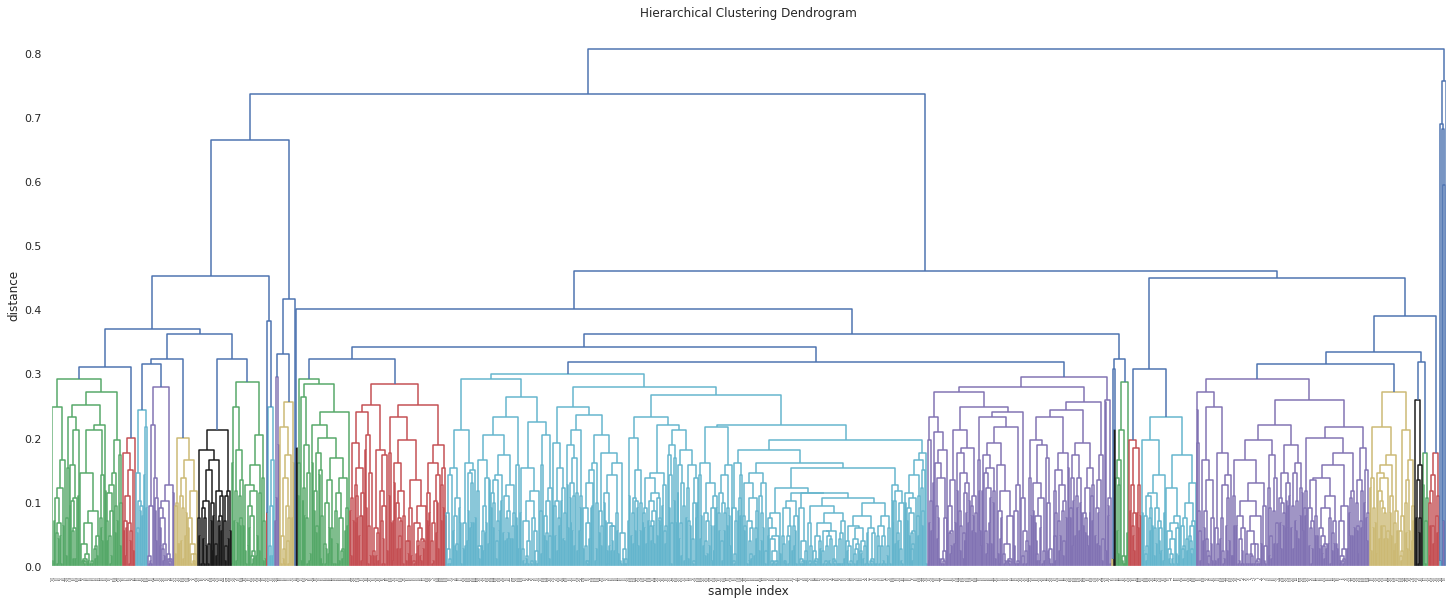

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    dendro,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=2.,  # font size for the x axis labels
    color_threshold=0.30 #add in color threshold for cut that will provide 32 clusters
)
plt.show()

The initial ideal cutoff for the dendrogram would have formed 4 clusters; however, to increase our sample size and to create more clusters, we decided to use a threshold distance of 0.30 to form our clusters; this resulted in 32 clusters of ASVs.

In [ ]:
#chose a height cutoff that shows 32 clusters
tree_cutoff = cluster.hierarchy.cut_tree(dendro, height = 0.30)
print(np.unique(tree_cutoff))
len(tree_cutoff)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


1473

In [ ]:
#add ASV with cluster label
clusters_df = pd.DataFrame({'ASV': asv_and_taxonomy.name, 'Cluster': tree_cutoff.reshape(1,-1)[0]})

#merge into aggregate_df
aggregate_df = aggregate_df.merge(clusters_df,how='left',on=['ASV'])

## One Hot Encode, Train/Test Split

We aggregated at the cluster level the relative abundance (ie. relative proportions) and the quantitative adjusted_abundance, and one-hot encoded all the time periods in the study: 

1. baseline
2. high-fat perturbation
3. latent steady state post high-fat perturbation
4. vancomycin perturbation period
5. latent steady state post vancomycin 
6. gentamicin perturbation period
7. latent steady state post gentamicin perturbation

We then randomly sampled 3 mice from the healthy mice cohort, and 3 mice from the Ulcerative Colitis cohort as the training set, and 1 mouse from the healthy cohort and 2 mice from the Ulcerative Colitis cohort as the test set. 

Subject 2,3,4, 6,7,and 8 were selected into the training set, and 5,9, and 10 were in the test set.

In [ ]:
#Aggregate at cluster level and create log_adjusted_abundance (to be used for Linear Regression and Lasso Model)  
aggregate_df2=aggregate_df.groupby(["Cluster","subject","time","subject_type"])[["relative_abundance","adjusted_abundance"]].sum().reset_index()
aggregate_df2["log_adjusted_abundance"] = np.log(aggregate_df2.copy()["adjusted_abundance"])

#create perturbation period labels
aggregate_df2["perturbation_label"] = pd.cut(x=aggregate_df2['time'], bins=[-1, 21.4, 28.4, 35.4, 42.4, 50.4,57.4,80],
                    labels=["baseline", "high_fat_perturbation", "post_high_fat_perturbation",
                            "vancomycin_perturbation", "post_vancomycin_perturbation","gentamicin_perturbation","post_gentamicin_perturbation"])

In [ ]:
#one-hot encode the perturbation labels
aggregate_df3 = aggregate_df2.join(pd.get_dummies(aggregate_df2["perturbation_label"]))
aggregate_df3 = aggregate_df3.join(pd.get_dummies(aggregate_df3["subject_type"]))
aggregate_df3.drop(["subject_type","perturbation_label","Ulcerative Colitis"], axis=1, inplace=True)
aggregate_df3.head()

,Cluster,subject,time,relative_abundance,adjusted_abundance,log_adjusted_abundance,baseline,high_fat_perturbation,post_high_fat_perturbation,vancomycin_perturbation,post_vancomycin_perturbation,gentamicin_perturbation,post_gentamicin_perturbation,Healthy
0,0,2,0.0,0.559471,4.869446e+06,15.398491,1,0,0,0,0,0,0,1
1,0,2,0.5,0.534291,1.837296e+07,16.726391,1,0,0,0,0,0,0,1
2,0,2,1.0,0.460826,1.096294e+11,25.420371,1,0,0,0,0,0,0,1
3,0,2,1.5,0.736061,5.593816e+09,22.444927,1,0,0,0,0,0,0,1
4,0,2,2.0,0.792107,5.435505e+09,22.416218,1,0,0,0,0,0,0,1


In [ ]:
#Sample from the Healthy and UC cohorts for the training and testing sample
import random
random.seed(1)
sample_1 = random.sample([2,3,4,5],k = 3)
sample_2 = random.sample([6,7,8,9,10],k= 3)
print(sample_1) #healthy mice to be in the training set
print(sample_2) #UC mice to be in the training set

[3, 4, 2]
[8, 6, 7]


In [ ]:
training_df = aggregate_df3.loc[aggregate_df3.subject.isin(sample_1+sample_2)]
testing_df = aggregate_df3.loc[~aggregate_df3.subject.isin((sample_1+sample_2))]
testing_df.head()

,Cluster,subject,time,relative_abundance,adjusted_abundance,log_adjusted_abundance,baseline,high_fat_perturbation,post_high_fat_perturbation,vancomycin_perturbation,post_vancomycin_perturbation,gentamicin_perturbation,post_gentamicin_perturbation,Healthy
228,0,5,0.0,0.784331,3.889713e+07,17.476431,1,0,0,0,0,0,0,1
229,0,5,0.5,0.016878,3.118232e+08,19.557947,1,0,0,0,0,0,0,1
230,0,5,1.0,0.683672,4.044381e+10,24.423180,1,0,0,0,0,0,0,1
231,0,5,1.5,0.775884,2.119307e+10,23.776940,1,0,0,0,0,0,0,1
232,0,5,2.0,0.724174,2.450789e+10,23.922261,1,0,0,0,0,0,0,1


It is interesting to see the the proportion of Cluster 0 goes from 78.4% at time 0 to 1.7% at time 0.5; this indicates there could be very high fluctuations in early baseline period for clusters/ASV proportions due to the sterilized mice being introduced to human feces.   

# **EDA**

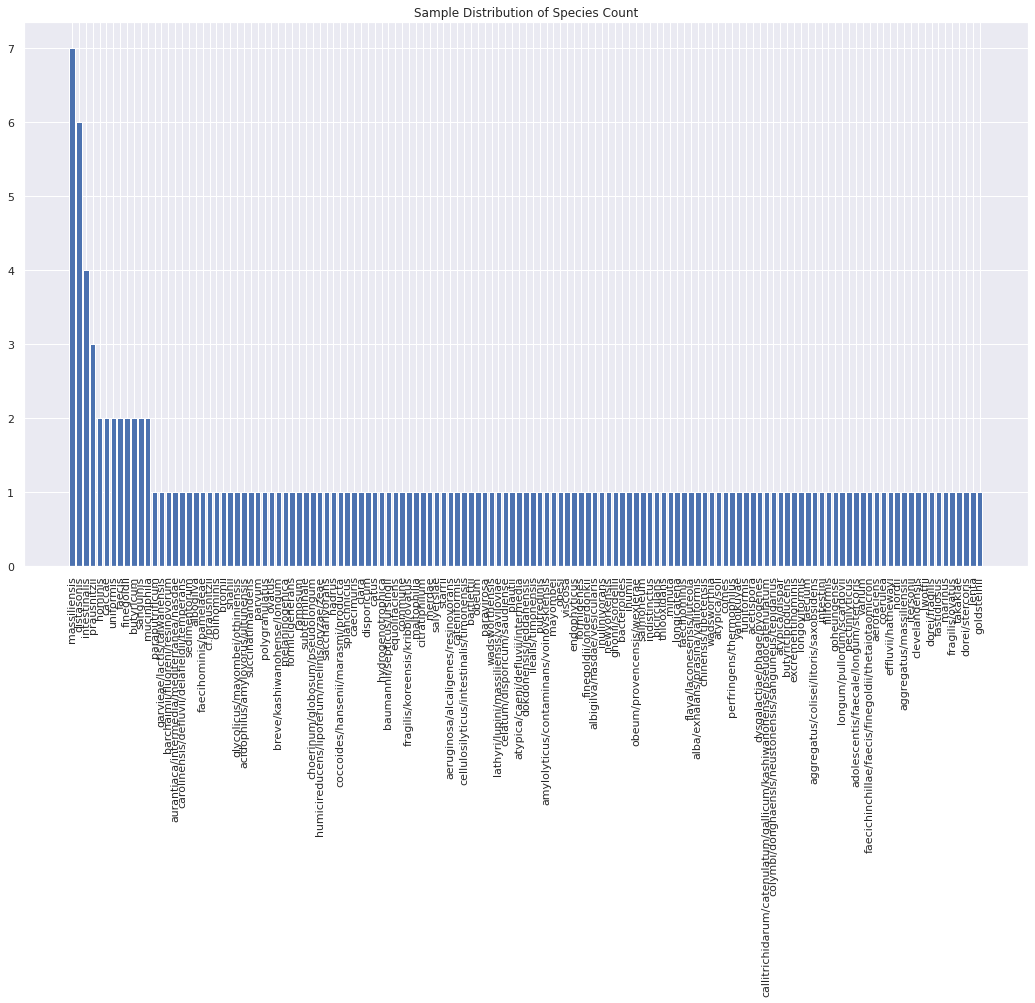

In [ ]:
species_count = asv_and_taxonomy["Species"].value_counts().reset_index()

fig, ax = plt.subplots(figsize=(18,10)) 
plt.bar(species_count["index"],species_count["Species"])
plt.title("Sample Distribution of Species Count")
plt.xticks(rotation = 90)
fig.show()

The Species chart above shows that only couple of species were appearing in ASV measurements with approximately 11% of the column populated and 89% of the data is blank.

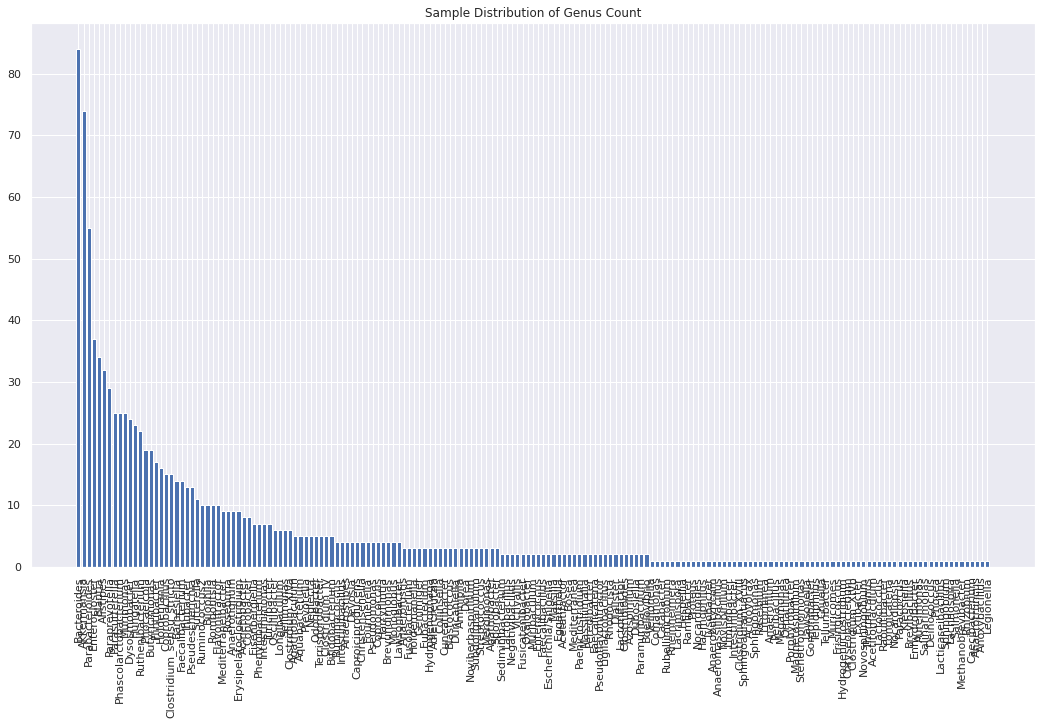

In [ ]:
genus_count = asv_and_taxonomy["Genus"].value_counts().reset_index()

fig, ax = plt.subplots(figsize=(18,10)) 
plt.bar(genus_count["index"],genus_count["Genus"])
plt.title("Sample Distribution of Genus Count")
plt.xticks(rotation = 90)
fig.show()

ASV and Taxonomy chart shows that although there are many Genus present in the measurements but only few are spread across different ASV measurements. we have approx. 70% of the column poulated and majority of the Genus samples are in the range of 0.06% to 1% ( sample range of 1 to 3) with highest percentage of approx. 4% Bacteroides was spread across different ASV measurements. Although from the Genus graph we see Bacteroides group was present in majority of the ASV measuremnts, the Species perspective we had massiliensis that was recorded as highest.

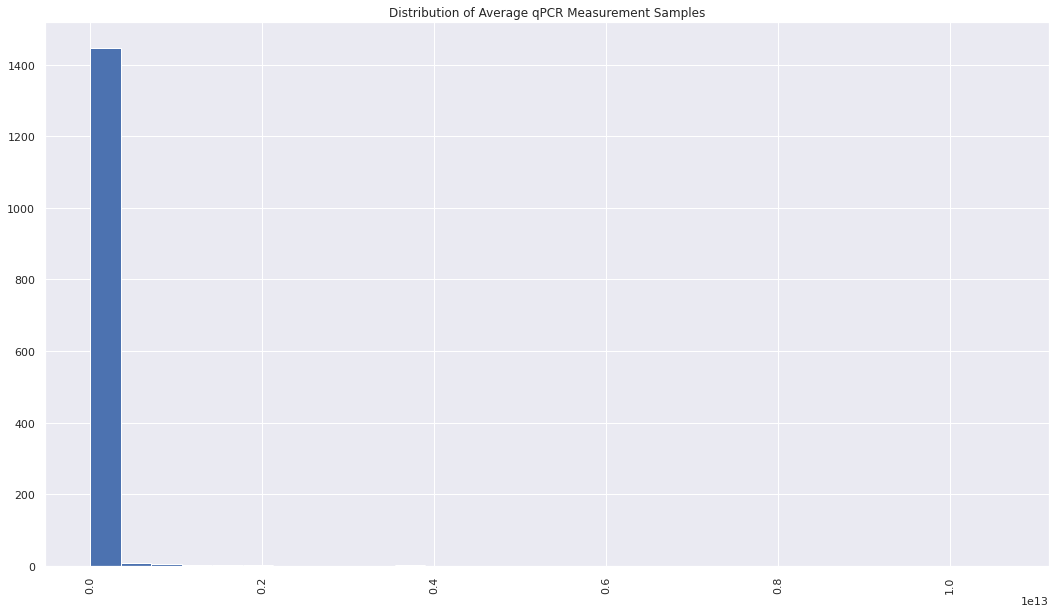

In [ ]:
asv_abundance_df = aggregate_df.groupby(['ASV'])['adjusted_abundance'].agg('sum').reset_index()

fig, ax = plt.subplots(figsize=(18,10)) 
plt.hist(asv_abundance_df["adjusted_abundance"],bins=30)
plt.title("Distribution of Average qPCR Measurement Samples")
plt.xticks(rotation = 90)
fig.show()

At the ASV level, the adjusted abundance shows that the data is very right-skewed, with a couple outliers with a higher estimated concentration of bacteria.

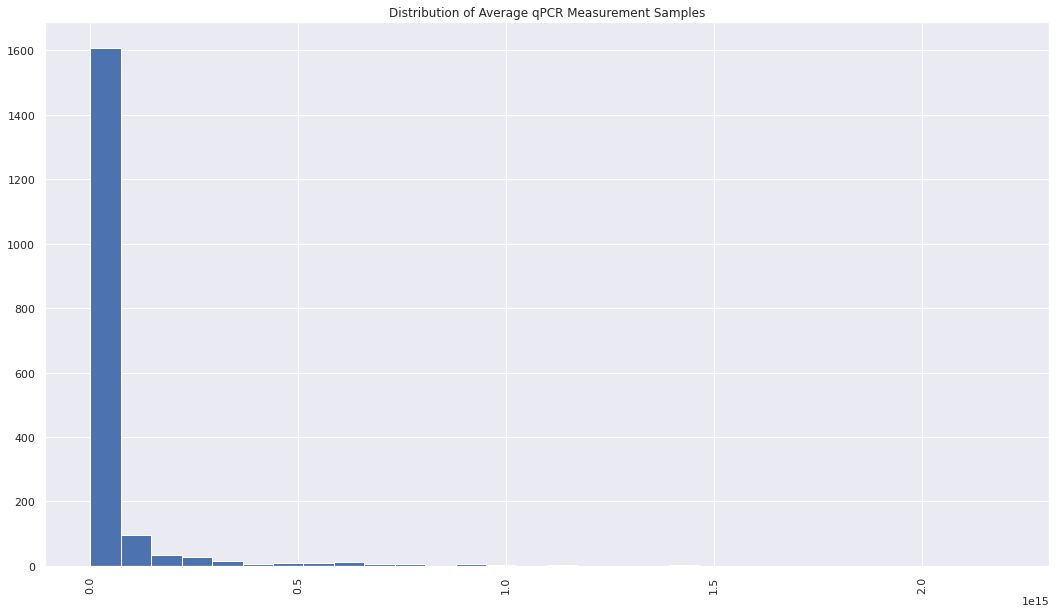

In [ ]:
qpcr_measures_df = aggregate_df.groupby(['time','Class'])['mean_measurement'].agg('sum').reset_index()

fig, ax = plt.subplots(figsize=(18,10)) 
plt.hist(qpcr_measures_df["mean_measurement"],bins=30)
plt.title("Distribution of Average qPCR Measurement Samples")
plt.xticks(rotation = 90)
fig.show()

Aggregating at the class level, the distribution of the average concentration is very right skewed like the ASV distribution, with most classes having a relatively low concentration. This chart, along with the ASV histogram and the bar charts for the species and genus, inspired us to aggregate the ASV's into clusters so that there could be a tangeable read count within each cluster.

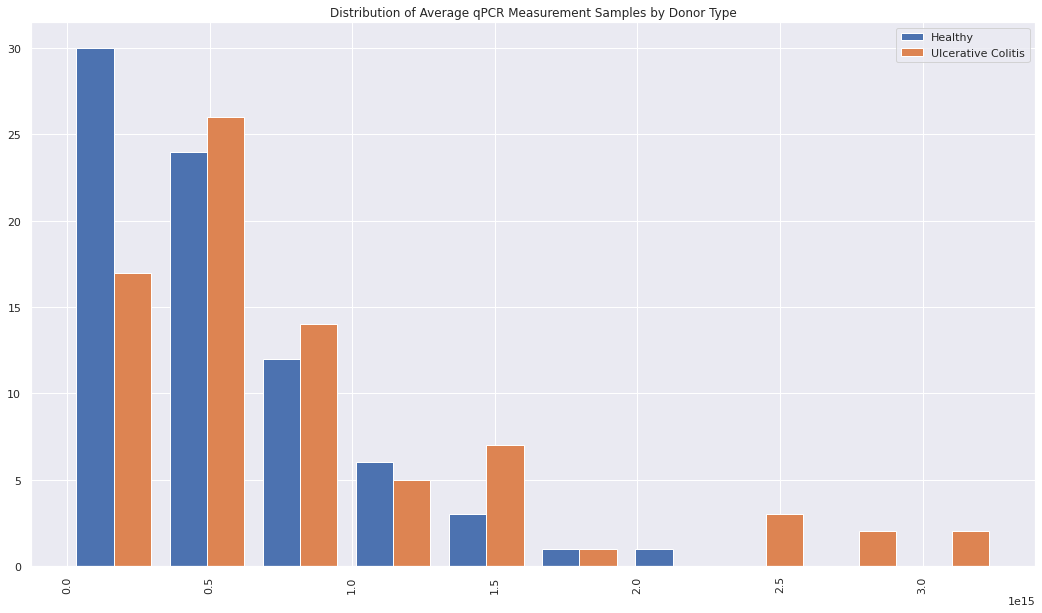

In [ ]:
qpcr_measures_by_donor_type_df = aggregate_df.groupby(['time','subject_type'])['mean_measurement'].agg('sum').reset_index()
donor_type = qpcr_measures_by_donor_type_df.subject_type.unique()
fig, ax = plt.subplots(figsize=(18,10)) 
plt.hist([qpcr_measures_by_donor_type_df.loc[qpcr_measures_by_donor_type_df.subject_type == x, 'mean_measurement'] for x in donor_type], label=donor_type)
plt.title("Distribution of Average qPCR Measurement Samples by Donor Type")
plt.xticks(rotation = 90)
plt.legend(donor_type)
fig.show()

From this chart we can see the distributions for the Healthy and UC cohort are similar, except that the UC cohort has more measurements in general and has some more outlier qPCR measurements than the Healthy Cohort. The distribution is also right skewed for both cohorts. The outlier samples in the UC cohort are most likely from the sharp spikes in the data in the period post-High Fat Diet perturbation, and the fluctuations post-Gentamicin perturbation period.

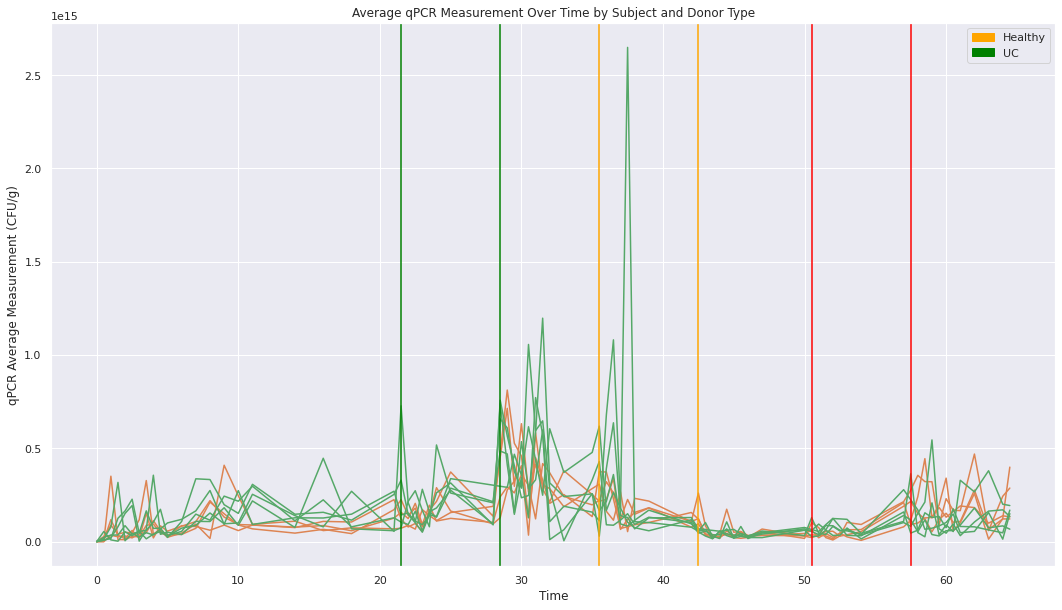

In [ ]:
import matplotlib.patches as mpatches

#By Subject Total Sample Counts
measurement_df_by_donor_type = aggregate_df.groupby(['subject','time','subject_type'])['mean_measurement'].agg('sum').reset_index()

# define color scheme and line style
colors = ["C1", "C2"]
linestyles = ['-', "--", ":",'-', "--", ":",'-', "--",":","-"]
orange_patch = mpatches.Patch(color='orange', label='Healthy')
green_patch = mpatches.Patch(color='green', label='UC')

fig, ax = plt.subplots(figsize=(18,10))
for type_idx, subject_type in enumerate(np.unique(measurement_df_by_donor_type["subject_type"])):
    for subject_idx, subject in enumerate(np.unique(measurement_df_by_donor_type["subject"])):
        df = measurement_df_by_donor_type[measurement_df_by_donor_type["subject_type"] == subject_type]
        df = df[df["subject"] == subject]
        plt.plot(df["time"], df["mean_measurement"], c = colors[type_idx])
plt.title("Average qPCR Measurement Over Time by Subject and Donor Type")
plt.xlabel("Time")
plt.ylabel("qPCR Average Measurement (CFU/g)")
ax.axvline(x=21.5, color = 'green', label = 'High Fat')
ax.axvline(x=28.5, color = 'green')
ax.axvline(x=35.5, color = 'orange', label = 'Gento' )
ax.axvline(x=42.5, color = 'orange')
ax.axvline(x=50.5, color = 'red', label = 'Vanco')
ax.axvline(x=57.5, color = 'red')
plt.legend(handles=[orange_patch, green_patch])
plt.show()

The trend above displays the geometric qPCR measurement over time by subject and donor type. We can see that during the High Fat Diet perturbation, the concentration of bacteria stays pretty steady, but post perturbation around day 30 there is a spike in the measurements, in particular for the Ulcerative Colitis mice. During the Vancomycin perturbation period, one of the Ulcerative Colitis mice has an extreme spike in bacteria concentration, but then they all decrease back to a “steady state” by roughly day 35. For the Gentamycin perturbation period, there is a slight increase in bacteria concentration across all mice, and then the concentration fluctuates post-perturbation. Interestingly, the spikes are happening with different mice; for example, the spike at time 37.5 is from mice 10, but the spike at 31.5 is from mice 7. In essence, while there are differing magnitudes across subjects, the subjects generally follow a similar trend in their peaks and return to baseline, in particular for mice within the same cohort (ie. healthy or UC). However, we do notice that certain subjects seem to have higher variation than others.


Calculating the samples per ASV based on Subject based on ASV

In [ ]:
#Function that plots the adjusted abundance for a given ASV across all subjects, coloring by donor type
def asv_plots(asv_number):
  asv_df = aggregate_df.loc[aggregate_df.ASV==asv_number]

  fig, ax = plt.subplots(figsize=(18,10))
  for type_idx, subject_type in enumerate(np.unique(asv_df["subject_type"])):
    for subject_idx, subject in enumerate(np.unique(asv_df["subject"])):
        df = asv_df[asv_df["subject_type"] == subject_type]
        df = df[df["subject"] == subject]
        plt.plot(df["time"], df["adjusted_abundance"], c = colors[type_idx])
  plt.title("Adjusted Abundance of "+asv_number+ " across all Subjects")
  plt.xlabel("Time")
  plt.ylabel("Adjusted Abundance")
  ax.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax.axvline(x=28.5, color = 'green')
  ax.axvline(x=35.5, color = 'orange', label = 'Gento' )
  ax.axvline(x=42.5, color = 'orange')
  ax.axvline(x=50.5, color = 'red', label = 'Vanco')
  ax.axvline(x=57.5, color = 'red')
  plt.legend(handles=[orange_patch, green_patch])
  plt.show()

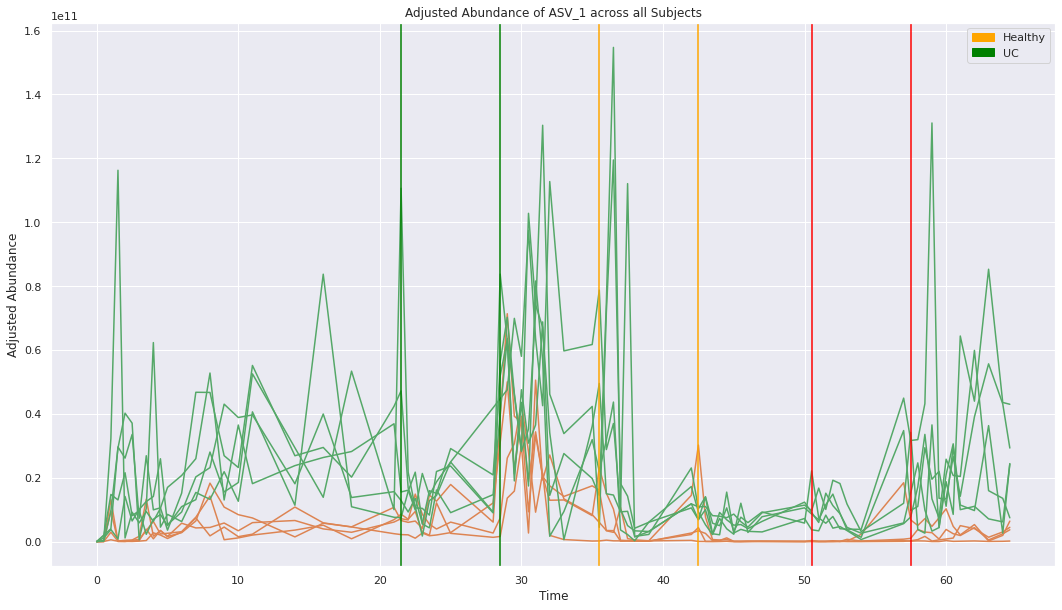

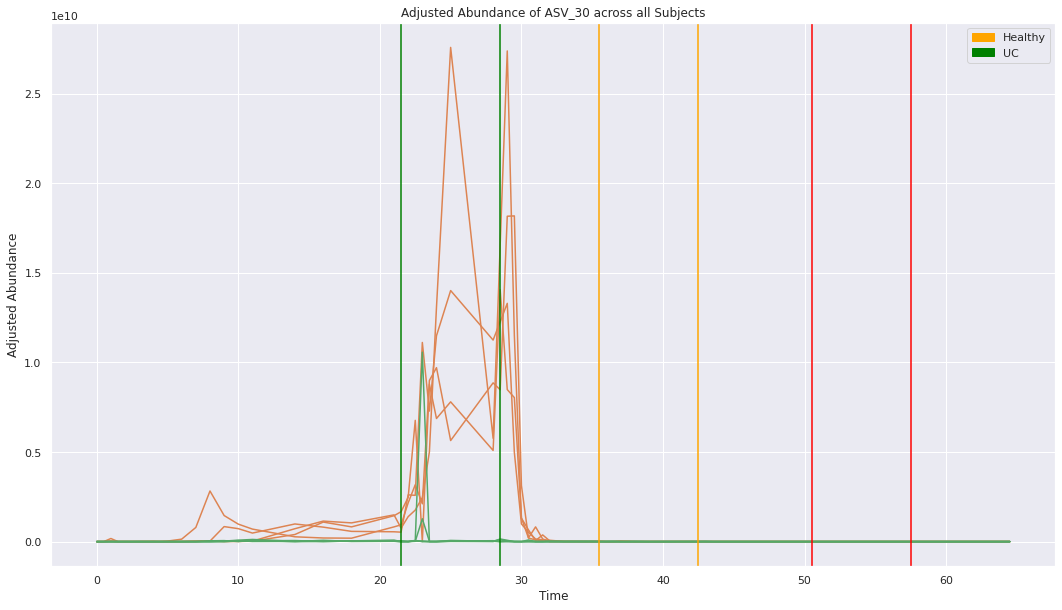

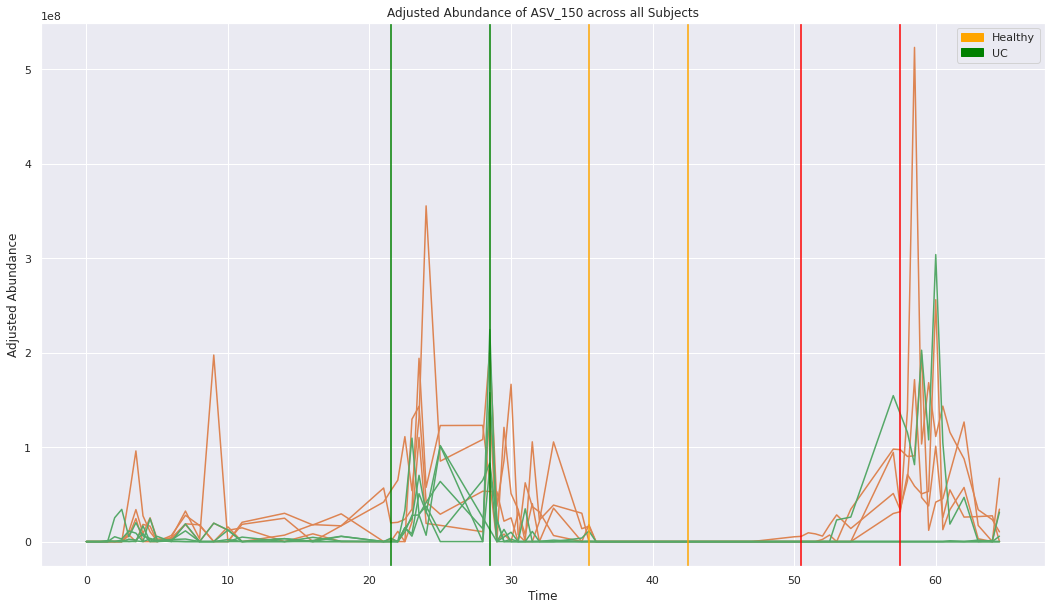

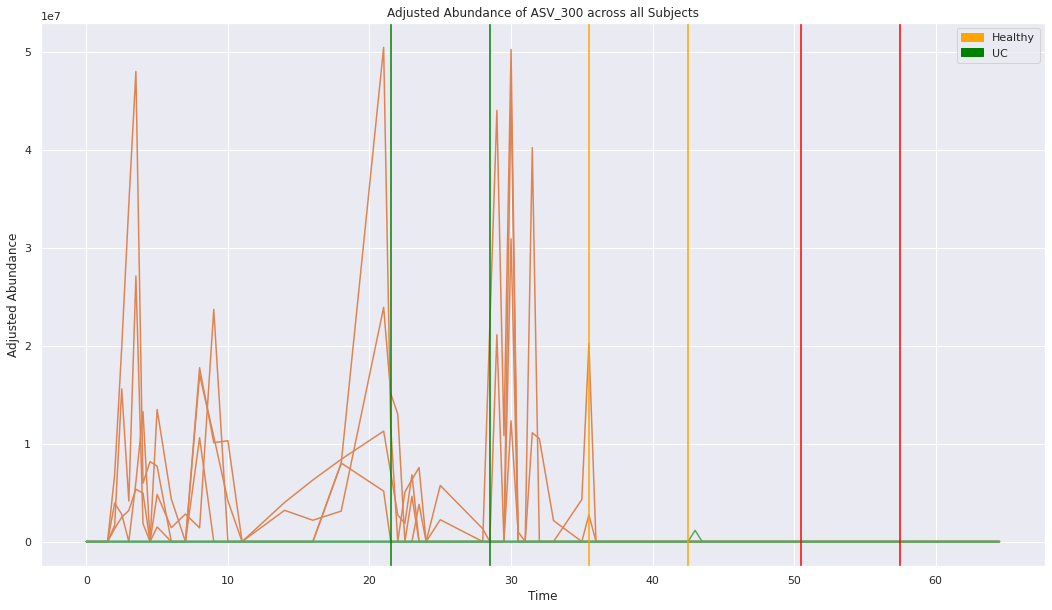

In [ ]:
#Plots Adjusted Abundance for ASV_1, ASV_30, ASV_150, and ASV_300 for all subjects
asv_plots("ASV_1")
asv_plots("ASV_30")
asv_plots("ASV_150")
asv_plots("ASV_300")

The plots of adjusted abundance for various sampled ASV show that the trends differ across ASV for when the adjusted abundance changes, but within each ASV the trends within the same cohort (ie. UC or Healthy) are relatively consistent. It is also interesting to see that the UC cohort has a much lower adjusted abundance of ASV_30, ASV_150, and ASV_300 than the Healthy cohort. This shows that the distribution of ASV/microbiales differ between the cohorts for a given ASV. All in all, the EDA supports the need to cluster the ASV's together, and we expect the general trend for both the Healthy and UC cohort to be similar across mice, but with the UC cohort having a higher magnitude of counts overall.

# **Modeling**

To format the our dataset in the appropriate manner for supervised learning, we used the following code from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/ to create a 3 day windowed period as predictors for our outcome to predict the following day. 

In [ ]:
# The following code creates the windowed X for which we can learn the desired Y
# Code inspired from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [colname+('(t-%d)' % i) for colname in data.columns]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [colname+'(t)' for colname in data.columns]
    else:
      names += [colname+('(t+%d)' % i) for colname in data.columns]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

## Regression

As baseline models for our predictions, we decided to use a basic linear regression model and a penalized regression model: the LASSO. While the linear regression model isn't very flexible, it can still potentially have a high accuracy in determining the next period's proportions.

For the predictions using regression models (ie. Linear Model and Lasso), we decided to predict the log of the quantitative adjusted abundance due to the counts being so large and to avoid getting a negative prediction (post-transforming back from the log). After transforming the prediction back to quantitative adjusted abundance, we calculated the relative proportions for each cluster within a sample time, and compared it with the true relative proportions. For this reason, the table being used for the Regression prediction models will be slightly different than the Deep Learning models, which predict the relative proportions directly.

In [ ]:
# Change names of clusters to disambiguate from subject number
aggregate_df3['Cluster'] = aggregate_df3['Cluster'].map(lambda x: 'Cluster_'+str(x))
clusters = aggregate_df3['Cluster'].unique()

#pivot table so that the log adjusted abundance for each Cluster are the columns
aggregate_df_final = aggregate_df3.pivot_table(values='log_adjusted_abundance', index=['time','subject','baseline','high_fat_perturbation','post_high_fat_perturbation',\
                                                                                          'vancomycin_perturbation','post_vancomycin_perturbation','gentamicin_perturbation',\
                                                                                          'post_gentamicin_perturbation','Healthy'], columns='Cluster').reset_index()
aggregate_df_final = aggregate_df_final.sort_values(['subject', 'time'])
aggregate_df_final = aggregate_df_final.reset_index(drop=True)
aggregate_df_final.head(lines_to_show)

Cluster,time,subject,baseline,high_fat_perturbation,post_high_fat_perturbation,vancomycin_perturbation,post_vancomycin_perturbation,gentamicin_perturbation,post_gentamicin_perturbation,Healthy,Cluster_0,Cluster_1,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_2,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,Cluster_3,Cluster_30,Cluster_31,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,0.0,2,1,0,0,0,0,0,0,1,15.398491,10.477104,3.299194,1.507434,10.189231,2.067050,2.200582,0.121140,0.121140,-0.572007,10.881784,1.992942,14.489234,1.373903,1.992942,10.648117,1.219752,0.121140,1.912900,9.783097,0.121140,-0.572007,0.121140,11.908579,-0.572007,-0.572007,12.773317,12.687293,11.287306,13.584291,3.038911,2.760197
1,0.5,2,1,0,0,0,0,0,0,1,16.726391,11.042723,2.611469,0.819709,2.295616,1.379325,1.512857,-0.566585,-0.566585,-1.259732,11.265652,1.305217,14.717512,0.686178,1.305217,10.126223,9.656265,-0.566585,1.225174,9.992659,-0.566585,-1.259732,-0.566585,15.818227,-1.259732,-1.259732,13.848986,13.293777,1.959144,15.270773,2.351186,10.126462
2,1.0,2,1,0,0,0,0,0,0,1,25.420371,21.194608,9.342711,16.526566,18.030652,8.110567,8.244099,6.164657,6.164657,5.471510,8.110567,8.036459,24.727567,7.417420,8.036459,7.080948,7.263269,6.164657,7.956417,6.164657,6.164657,5.471510,6.164657,21.762903,5.471510,5.471510,11.701991,9.478843,21.873564,24.909203,9.082428,15.834161
3,1.5,2,1,0,0,0,0,0,0,1,22.444927,18.423511,5.328913,12.797771,15.195619,4.096769,4.230301,2.150859,2.150859,1.457712,4.096769,12.104826,21.188411,3.403622,4.022661,3.067150,3.249471,2.150859,3.942619,2.150859,2.150859,1.457712,2.150859,16.647853,1.457712,1.457712,17.417805,14.301908,13.490972,19.348057,5.068630,4.789916
4,2.0,2,1,0,0,0,0,0,0,1,22.416218,18.464450,4.595528,14.394860,17.377164,3.363385,3.496916,1.417475,1.417475,0.724327,16.423003,12.785484,20.354827,13.073123,3.289277,2.333765,2.516087,1.417475,3.209234,1.417475,1.417475,0.724327,1.417475,18.027164,0.724327,0.724327,19.501609,19.025691,16.592080,16.164177,12.380262,15.729860
5,2.5,2,1,0,0,0,0,0,0,1,23.126720,21.388713,6.007360,4.215601,18.846662,4.775216,13.994736,2.829306,2.829306,2.136159,16.724664,4.701108,21.484601,12.896145,4.701108,3.745597,3.927919,2.829306,4.621066,2.829306,2.829306,2.136159,2.829306,20.332046,2.136159,2.136159,20.635381,21.266334,18.285091,16.827923,14.282503,17.314864
6,3.0,2,1,0,0,0,0,0,0,1,23.167531,21.860374,6.672554,16.131995,17.709345,15.672485,13.188008,3.494501,3.494501,2.801353,14.573940,5.366303,20.345283,4.747264,5.366303,4.410791,4.593113,3.494501,5.286260,3.494501,3.494501,2.801353,3.494501,20.162026,2.801353,2.801353,20.637051,19.696316,16.621554,16.798620,6.412271,16.825150
7,3.5,2,1,0,0,0,0,0,0,1,24.356944,23.108939,14.011729,18.314826,18.465115,17.101813,15.109475,3.915516,3.915516,3.222369,5.861426,5.787318,21.534242,5.168279,5.787318,4.831807,5.014128,3.915516,5.707275,3.915516,3.915516,3.222369,3.915516,21.858132,3.222369,3.222369,21.869017,20.800858,18.429606,18.595767,14.704278,18.822947
8,4.0,2,1,0,0,0,0,0,0,1,24.470614,23.083276,15.302601,17.499698,18.318011,5.144023,15.484825,3.198113,3.198113,2.504966,14.386271,14.791701,21.589587,4.450876,5.069915,4.114404,4.296725,3.198113,4.989873,3.198113,3.198113,2.504966,3.198113,21.308825,2.504966,2.504966,22.401344,20.001133,19.249863,19.614619,6.115884,19.186096
9,4.5,2,1,0,0,0,0,0,0,1,23.610620,22.732152,16.446679,17.916317,18.398746,5.102693,15.508400,3.156782,3.156782,2.463635,13.311398,5.028585,21.186265,4.409545,5.028585,4.073073,4.255395,3.156782,4.948542,3.156782,3.156782,2.463635,3.156782,20.929888,2.463635,2.463635,21.218800,19.400193,18.902134,19.050950,6.074553,19.778845


In [ ]:
#variables that don't vary over time are excluded from the transformation from series to supervised; to be added in after the transformation.
static_variables = ['time','subject','baseline','high_fat_perturbation','post_high_fat_perturbation',\
                                                                        'vancomycin_perturbation', 'post_vancomycin_perturbation','gentamicin_perturbation',\
                                                                        'post_gentamicin_perturbation', 'Healthy']

# Change dataframe periods leading up to prediction time point by cluster (ie. Cluster 0 t-3, Cluster 1 t-3...Cluster 32 t-1, Cluster 1 t) for subject 2 as the base dataframe.
# The next code chunk will transform the next 8 mice, and aggregate all the dataframes together. 
regression_df = aggregate_df_final.loc[aggregate_df_final.subject==2]
#drop static variables that aren't time variant; will be added back into the model 
regression_df = regression_df.drop(static_variables, axis=1)
regression_df = series_to_supervised(regression_df,n_in=3, n_out=1).reset_index()
regression_df.head(lines_to_show)

,index,Cluster_0(t-3),Cluster_1(t-3),Cluster_10(t-3),Cluster_11(t-3),Cluster_12(t-3),Cluster_13(t-3),Cluster_14(t-3),Cluster_15(t-3),Cluster_16(t-3),Cluster_17(t-3),Cluster_18(t-3),Cluster_19(t-3),Cluster_2(t-3),Cluster_20(t-3),Cluster_21(t-3),Cluster_22(t-3),Cluster_23(t-3),Cluster_24(t-3),Cluster_25(t-3),Cluster_26(t-3),Cluster_27(t-3),Cluster_28(t-3),Cluster_29(t-3),Cluster_3(t-3),Cluster_30(t-3),Cluster_31(t-3),Cluster_4(t-3),Cluster_5(t-3),Cluster_6(t-3),Cluster_7(t-3),Cluster_8(t-3),Cluster_9(t-3),Cluster_0(t-2),Cluster_1(t-2),Cluster_10(t-2),Cluster_11(t-2),Cluster_12(t-2),Cluster_13(t-2),Cluster_14(t-2),...,Cluster_30(t-1),Cluster_31(t-1),Cluster_4(t-1),Cluster_5(t-1),Cluster_6(t-1),Cluster_7(t-1),Cluster_8(t-1),Cluster_9(t-1),Cluster_0(t),Cluster_1(t),Cluster_10(t),Cluster_11(t),Cluster_12(t),Cluster_13(t),Cluster_14(t),Cluster_15(t),Cluster_16(t),Cluster_17(t),Cluster_18(t),Cluster_19(t),Cluster_2(t),Cluster_20(t),Cluster_21(t),Cluster_22(t),Cluster_23(t),Cluster_24(t),Cluster_25(t),Cluster_26(t),Cluster_27(t),Cluster_28(t),Cluster_29(t),Cluster_3(t),Cluster_30(t),Cluster_31(t),Cluster_4(t),Cluster_5(t),Cluster_6(t),Cluster_7(t),Cluster_8(t),Cluster_9(t)
0,3,15.398491,10.477104,3.299194,1.507434,10.189231,2.067050,2.200582,0.121140,0.121140,-0.572007,10.881784,1.992942,14.489234,1.373903,1.992942,10.648117,1.219752,0.121140,1.912900,9.783097,0.121140,-0.572007,0.121140,11.908579,-0.572007,-0.572007,12.773317,12.687293,11.287306,13.584291,3.038911,2.760197,16.726391,11.042723,2.611469,0.819709,2.295616,1.379325,1.512857,...,5.471510,5.471510,11.701991,9.478843,21.873564,24.909203,9.082428,15.834161,22.444927,18.423511,5.328913,12.797771,15.195619,4.096769,4.230301,2.150859,2.150859,1.457712,4.096769,12.104826,21.188411,3.403622,4.022661,3.067150,3.249471,2.150859,3.942619,2.150859,2.150859,1.457712,2.150859,16.647853,1.457712,1.457712,17.417805,14.301908,13.490972,19.348057,5.068630,4.789916
1,4,16.726391,11.042723,2.611469,0.819709,2.295616,1.379325,1.512857,-0.566585,-0.566585,-1.259732,11.265652,1.305217,14.717512,0.686178,1.305217,10.126223,9.656265,-0.566585,1.225174,9.992659,-0.566585,-1.259732,-0.566585,15.818227,-1.259732,-1.259732,13.848986,13.293777,1.959144,15.270773,2.351186,10.126462,25.420371,21.194608,9.342711,16.526566,18.030652,8.110567,8.244099,...,1.457712,1.457712,17.417805,14.301908,13.490972,19.348057,5.068630,4.789916,22.416218,18.464450,4.595528,14.394860,17.377164,3.363385,3.496916,1.417475,1.417475,0.724327,16.423003,12.785484,20.354827,13.073123,3.289277,2.333765,2.516087,1.417475,3.209234,1.417475,1.417475,0.724327,1.417475,18.027164,0.724327,0.724327,19.501609,19.025691,16.592080,16.164177,12.380262,15.729860
2,5,25.420371,21.194608,9.342711,16.526566,18.030652,8.110567,8.244099,6.164657,6.164657,5.471510,8.110567,8.036459,24.727567,7.417420,8.036459,7.080948,7.263269,6.164657,7.956417,6.164657,6.164657,5.471510,6.164657,21.762903,5.471510,5.471510,11.701991,9.478843,21.873564,24.909203,9.082428,15.834161,22.444927,18.423511,5.328913,12.797771,15.195619,4.096769,4.230301,...,0.724327,0.724327,19.501609,19.025691,16.592080,16.164177,12.380262,15.729860,23.126720,21.388713,6.007360,4.215601,18.846662,4.775216,13.994736,2.829306,2.829306,2.136159,16.724664,4.701108,21.484601,12.896145,4.701108,3.745597,3.927919,2.829306,4.621066,2.829306,2.829306,2.136159,2.829306,20.332046,2.136159,2.136159,20.635381,21.266334,18.285091,16.827923,14.282503,17.314864
3,6,22.444927,18.423511,5.328913,12.797771,15.195619,4.096769,4.230301,2.150859,2.150859,1.457712,4.096769,12.104826,21.188411,3.403622,4.022661,3.067150,3.249471,2.150859,3.942619,2.150859,2.150859,1.457712,2.150859,16.647853,1.457712,1.457712,17.417805,14.301908,13.490972,19.348057,5.068630,4.789916,22.416218,18.464450,4.595528,14.394860,17.377164,3.363385,3.496916,...,2.136159,2.136159,20.635381,21.266334,18.285091,16.827923,14.282503,17.314864,23.167531,21.860374,6.672554,16.131995,17.709345,15.672485,13.188008,3.494501,3.494501,2.801353,14.5

In [ ]:
static_values = aggregate_df_final.loc[aggregate_df_final.reset_index()["index"].isin(regression_df["index"]),['time','subject','baseline','high_fat_perturbation','post_high_fat_perturbation',\
                                                                      'vancomycin_perturbation', 'post_vancomycin_perturbation','gentamicin_perturbation',\
                                                                      'post_gentamicin_perturbation', 'Healthy']]
#add back in static variables
regression_df = pd.concat([static_values.reset_index(drop=True),regression_df.reset_index(drop=True)],axis=1)

#repeat for all other subjects and concatenate dataframes together
for i in [3,4,5,6,7,8,9,10]:
  subject_df = aggregate_df_final.loc[aggregate_df_final.subject==i]
  subject_df = subject_df.drop(static_variables, axis=1)
  subject_df = series_to_supervised(subject_df,n_in=3, n_out=1).reset_index()

  static_values = aggregate_df_final.loc[aggregate_df_final.reset_index()["index"].isin(subject_df["index"]),['time','subject','baseline','high_fat_perturbation','post_high_fat_perturbation',\
                                                                        'vancomycin_perturbation', 'post_vancomycin_perturbation','gentamicin_perturbation',\
                                                                        'post_gentamicin_perturbation', 'Healthy']]
  subject_df = pd.concat([static_values.reset_index(drop=True),subject_df.reset_index(drop=True)],axis=1)
  regression_df = pd.concat([regression_df.reset_index(drop=True),subject_df.reset_index(drop=True)],axis=0)

regression_df.drop(["index"],axis=1, inplace=True)
regression_df.head(lines_to_show)

,time,subject,baseline,high_fat_perturbation,post_high_fat_perturbation,vancomycin_perturbation,post_vancomycin_perturbation,gentamicin_perturbation,post_gentamicin_perturbation,Healthy,Cluster_0(t-3),Cluster_1(t-3),Cluster_10(t-3),Cluster_11(t-3),Cluster_12(t-3),Cluster_13(t-3),Cluster_14(t-3),Cluster_15(t-3),Cluster_16(t-3),Cluster_17(t-3),Cluster_18(t-3),Cluster_19(t-3),Cluster_2(t-3),Cluster_20(t-3),Cluster_21(t-3),Cluster_22(t-3),Cluster_23(t-3),Cluster_24(t-3),Cluster_25(t-3),Cluster_26(t-3),Cluster_27(t-3),Cluster_28(t-3),Cluster_29(t-3),Cluster_3(t-3),Cluster_30(t-3),Cluster_31(t-3),Cluster_4(t-3),Cluster_5(t-3),Cluster_6(t-3),Cluster_7(t-3),...,Cluster_30(t-1),Cluster_31(t-1),Cluster_4(t-1),Cluster_5(t-1),Cluster_6(t-1),Cluster_7(t-1),Cluster_8(t-1),Cluster_9(t-1),Cluster_0(t),Cluster_1(t),Cluster_10(t),Cluster_11(t),Cluster_12(t),Cluster_13(t),Cluster_14(t),Cluster_15(t),Cluster_16(t),Cluster_17(t),Cluster_18(t),Cluster_19(t),Cluster_2(t),Cluster_20(t),Cluster_21(t),Cluster_22(t),Cluster_23(t),Cluster_24(t),Cluster_25(t),Cluster_26(t),Cluster_27(t),Cluster_28(t),Cluster_29(t),Cluster_3(t),Cluster_30(t),Cluster_31(t),Cluster_4(t),Cluster_5(t),Cluster_6(t),Cluster_7(t),Cluster_8(t),Cluster_9(t)
0,1.5,2,1,0,0,0,0,0,0,1,15.398491,10.477104,3.299194,1.507434,10.189231,2.067050,2.200582,0.121140,0.121140,-0.572007,10.881784,1.992942,14.489234,1.373903,1.992942,10.648117,1.219752,0.121140,1.912900,9.783097,0.121140,-0.572007,0.121140,11.908579,-0.572007,-0.572007,12.773317,12.687293,11.287306,13.584291,...,5.471510,5.471510,11.701991,9.478843,21.873564,24.909203,9.082428,15.834161,22.444927,18.423511,5.328913,12.797771,15.195619,4.096769,4.230301,2.150859,2.150859,1.457712,4.096769,12.104826,21.188411,3.403622,4.022661,3.067150,3.249471,2.150859,3.942619,2.150859,2.150859,1.457712,2.150859,16.647853,1.457712,1.457712,17.417805,14.301908,13.490972,19.348057,5.068630,4.789916
1,2.0,2,1,0,0,0,0,0,0,1,16.726391,11.042723,2.611469,0.819709,2.295616,1.379325,1.512857,-0.566585,-0.566585,-1.259732,11.265652,1.305217,14.717512,0.686178,1.305217,10.126223,9.656265,-0.566585,1.225174,9.992659,-0.566585,-1.259732,-0.566585,15.818227,-1.259732,-1.259732,13.848986,13.293777,1.959144,15.270773,...,1.457712,1.457712,17.417805,14.301908,13.490972,19.348057,5.068630,4.789916,22.416218,18.464450,4.595528,14.394860,17.377164,3.363385,3.496916,1.417475,1.417475,0.724327,16.423003,12.785484,20.354827,13.073123,3.289277,2.333765,2.516087,1.417475,3.209234,1.417475,1.417475,0.724327,1.417475,18.027164,0.724327,0.724327,19.501609,19.025691,16.592080,16.164177,12.380262,15.729860
2,2.5,2,1,0,0,0,0,0,0,1,25.420371,21.194608,9.342711,16.526566,18.030652,8.110567,8.244099,6.164657,6.164657,5.471510,8.110567,8.036459,24.727567,7.417420,8.036459,7.080948,7.263269,6.164657,7.956417,6.164657,6.164657,5.471510,6.164657,21.762903,5.471510,5.471510,11.701991,9.478843,21.873564,24.909203,...,0.724327,0.724327,19.501609,19.025691,16.592080,16.164177,12.380262,15.729860,23.126720,21.388713,6.007360,4.215601,18.846662,4.775216,13.994736,2.829306,2.829306,2.136159,16.724664,4.701108,21.484601,12.896145,4.701108,3.745597,3.927919,2.829306,4.621066,2.829306,2.829306,2.136159,2.829306,20.332046,2.136159,2.136159,20.635381,21.266334,18.285091,16.827923,14.282503,17.314864
3,3.0,2,1,0,0,0,0,0,0,1,22.444927,18.423511,5.328913,12.797771,15.195619,4.096769,4.230301,2.150859,2.150859,1.457712,4.096769,12.104826,21.188411,3.403622,4.022661,3.067150,3.249471,2.150859,3.942619,2.150859,2.150859,1.457712,2.150859,16.647853,1.457712,1.457712,17.417805,14.301908,13.490972,19.348057,...,2.136159,2.136159,20.635381,21.266334,18.285091,16.827923,14.282503,17.314864,23.167531,21.860374,6.672554,16.131995,17.709345,15.672485,13.188008,3.494501,3.494501,2.801353,14.573940,5.366303,20.345283,4.747264,5.366303,4.410791,4.593113,3.494501,5.286260,3.494501,3.494501,2.801353,3.494501,20.162026,2.801353,2.801353,20.637051,19.696316,16.621554,16.798620,6.412271,16.825150
4,3.5,2,1,0,0,0,0,0

In [ ]:
#Create the training and testing set for the regression predictions.
regression_training_df = regression_df.loc[regression_df.subject.isin(sample_1+sample_2)]
regression_testing_df = regression_df.loc[~regression_df.subject.isin((sample_1+sample_2))]

### Linear Regression

In [ ]:
train_x = regression_training_df.iloc[:, 2:106] #perturbation period columns, human feces type, cluster relative abundance measures for last 3 time periods (t-3, t-2, t-1)
train_y = regression_training_df.iloc[:, 106:] # cluster relative abundance measures for the next time period (t)
test_x = regression_testing_df.iloc[:, 2:106]
test_y = regression_testing_df.iloc[:, 106:]

# define model
linear_model = LinearRegression()
# fit model
linear_model.fit(train_x, train_y)
# make a prediction
yhat = linear_model.predict(test_x)

In [ ]:
print("Intercept for Cluster0 linear regression model: ", linear_model.intercept_[0])
print("Beta Coefficients for Cluster0 linear regression model: \n", linear_model.coef_.T[0])

Intercept for Cluster0 linear regression model:  -271322774323.1152
Beta Coefficients for Cluster0 linear regression model: 
 [ 2.71322774e+11 -3.86706194e+11  6.29825808e+12 -1.40047476e+12
  1.74801395e+12  2.21685057e+12 -1.27661213e+12  2.67756042e+11
 -7.93077871e+11 -3.41467094e+11 -6.02765797e+12 -3.14286924e+12
  7.90837701e+11 -1.90029241e+11 -4.63255993e+12 -1.62157865e+12
 -1.28707777e+12 -3.41467094e+11  6.06609045e+11 -3.41467094e+11
 -3.41467094e+11 -3.41467094e+11  1.53276661e+11  6.30465522e+11
 -3.41467094e+11 -3.41467094e+11  1.61728567e+11  2.67120447e+12
  1.46425246e+12 -7.78398824e+11  6.22989818e+12  4.29184305e+12]


The effect sizes vary across the covariates, but it's interesting to see how the a mouse being in the fat perturbation time frame would have a decrease in their average estimated proportion (ie. -3.87e+11), but right afterwards would have an increase in the latent steady state post fat-perturbation (ie. 6.30e+12) in the linear regression model.

In [ ]:
#exponentiate the values to transform back to adjusted abundance, then divide by total sample adjusted abundance to get proportions for each cluster
yhat_df = np.exp(pd.DataFrame(yhat))
yhat_df.columns = aggregate_df_final.columns[10:] #Cluster column names
yhat_proportions_df = yhat_df.div(pd.DataFrame(yhat_df).sum(axis=1),axis=0).reset_index(drop=True)
test_y_proportions = np.exp(test_y).div(np.exp(pd.DataFrame(test_y)).sum(axis=1),axis=0).reset_index(drop=True)
test_y_proportions.columns = aggregate_df_final.columns[10:]

#square the residuals to set up for calculating rmse (fully calculated after groupby subject)
residuals_squared_linear=np.square(yhat_proportions_df.subtract(test_y_proportions))

In [ ]:
#RMSE table for Linear Regression
rmse_df_linear  = pd.concat([regression_testing_df.iloc[:,:2].reset_index(drop=True),residuals_squared_linear.reset_index(drop=True)],axis=1)
rmse_df_linear = rmse_df_linear.groupby(['subject']).mean().reset_index().drop(["time"],axis=1)
rmse_df_linear.iloc[:,1:]=round(np.sqrt(rmse_df_linear.iloc[:,1:]),4) 
rmse_df_linear.index = rmse_df_linear.subject
rmse_df_linear.drop("subject",axis=1, inplace=True)
rmse_df_linear=rmse_df_linear.T.reset_index() #rename columns
rmse_df_linear.columns = ["Cluster",	"LM_Mouse5(Healthy) rmse",	"LM_Mouse9(UC) rmse",	"LM_Mouse10(UC) rmse"]
rmse_df_linear.head()

,Cluster,LM_Mouse5(Healthy) rmse,LM_Mouse9(UC) rmse,LM_Mouse10(UC) rmse
0,Cluster_0,0.1853,0.1023,0.0961
1,Cluster_1,0.0868,0.1251,0.1249
2,Cluster_10,0.0119,0.0006,0.0001
3,Cluster_11,0.0081,0.0000,0.0002
4,Cluster_12,0.0035,0.0050,0.0049


In [ ]:
#RMSE table for Linear Regression for latent_steady state times (post perturbation periods, before the next perturabtion period or after Gentamicin period)
rmse_df_linear_latent_steady_states  = pd.concat([regression_testing_df.iloc[:,:2].reset_index(drop=True),residuals_squared_linear.reset_index(drop=True)],axis=1)
rmse_df_linear_latent_steady_states = rmse_df_linear_latent_steady_states.loc[((rmse_df_linear_latent_steady_states.time >=28.5) & (rmse_df_linear_latent_steady_states.time <=35.4)) |
                                                                              ((rmse_df_linear_latent_steady_states.time >=42.5) & (rmse_df_linear_latent_steady_states.time <=50.4)) |
                                                                              ((rmse_df_linear_latent_steady_states.time >=57.5))] 

rmse_df_linear_latent_steady_states = rmse_df_linear_latent_steady_states.groupby(['subject']).mean().reset_index().drop(["time"],axis=1)
rmse_df_linear_latent_steady_states.iloc[:,1:]=round(np.sqrt(rmse_df_linear_latent_steady_states.iloc[:,1:]),4) 
rmse_df_linear_latent_steady_states.index = rmse_df_linear_latent_steady_states.subject
rmse_df_linear_latent_steady_states.drop("subject",axis=1, inplace=True)
rmse_df_linear_latent_steady_states=rmse_df_linear_latent_steady_states.T.reset_index() #rename columns
rmse_df_linear_latent_steady_states.columns = ["Cluster",	"LM_Mouse5(Healthy) rmse",	"LM_Mouse9(UC) rmse",	"LM_Mouse10(UC) rmse"]
rmse_df_linear_latent_steady_states.head()

,Cluster,LM_Mouse5(Healthy) rmse,LM_Mouse9(UC) rmse,LM_Mouse10(UC) rmse
0,Cluster_0,0.2406,0.0983,0.1006
1,Cluster_1,0.0880,0.1216,0.1155
2,Cluster_10,0.0085,0.0001,0.0000
3,Cluster_11,0.0022,0.0000,0.0003
4,Cluster_12,0.0012,0.0062,0.0046


In [ ]:
#RMSE table for Linear Regression for latent_steady state post fat and before vancomycin
rmse_df_linear_post_fat  = pd.concat([regression_testing_df.iloc[:,:2].reset_index(drop=True),residuals_squared_linear.reset_index(drop=True)],axis=1)
rmse_df_linear_post_fat = rmse_df_linear_post_fat.loc[((rmse_df_linear_post_fat.time >=28.5) & (rmse_df_linear_post_fat.time <=35.4))] 

rmse_df_linear_post_fat = rmse_df_linear_post_fat.groupby(['subject']).mean().reset_index().drop(["time"],axis=1)
rmse_df_linear_post_fat.iloc[:,1:]=round(np.sqrt(rmse_df_linear_post_fat.iloc[:,1:]),4) 
rmse_df_linear_post_fat.index = rmse_df_linear_post_fat.subject
rmse_df_linear_post_fat.drop("subject",axis=1, inplace=True)
rmse_df_linear_post_fat=rmse_df_linear_post_fat.T.reset_index() #rename columns
rmse_df_linear_post_fat.columns = ["Cluster",	"LM_Mouse5(Healthy) rmse",	"LM_Mouse9(UC) rmse",	"LM_Mouse10(UC) rmse"]
rmse_df_linear_post_fat.head()

,Cluster,LM_Mouse5(Healthy) rmse,LM_Mouse9(UC) rmse,LM_Mouse10(UC) rmse
0,Cluster_0,0.1399,0.1411,0.1128
1,Cluster_1,0.1097,0.1848,0.1475
2,Cluster_10,0.0118,0.0000,0.0000
3,Cluster_11,0.0002,0.0000,0.0000
4,Cluster_12,0.0010,0.0005,0.0010


In [ ]:
#RMSE table for Linear Regression for latent_steady state post Vanco and before Gentamicin
rmse_df_linear_post_vanco  = pd.concat([regression_testing_df.iloc[:,:2].reset_index(drop=True),residuals_squared_linear.reset_index(drop=True)],axis=1)
rmse_df_linear_post_vanco = rmse_df_linear_post_vanco.loc[((rmse_df_linear_post_vanco.time >=42.5) & (rmse_df_linear_post_vanco.time <=50.4))] 

rmse_df_linear_post_vanco = rmse_df_linear_post_vanco.groupby(['subject']).mean().reset_index().drop(["time"],axis=1)
rmse_df_linear_post_vanco.iloc[:,1:]=round(np.sqrt(rmse_df_linear_post_vanco.iloc[:,1:]),4) 
rmse_df_linear_post_vanco.index = rmse_df_linear_post_vanco.subject
rmse_df_linear_post_vanco.drop("subject",axis=1, inplace=True)
rmse_df_linear_post_vanco=rmse_df_linear_post_vanco.T.reset_index() #rename columns
rmse_df_linear_post_vanco.columns = ["Cluster",	"LM_Mouse5(Healthy) rmse",	"LM_Mouse9(UC) rmse",	"LM_Mouse10(UC) rmse"]
rmse_df_linear_post_vanco.head()

,Cluster,LM_Mouse5(Healthy) rmse,LM_Mouse9(UC) rmse,LM_Mouse10(UC) rmse
0,Cluster_0,0.3036,0.0886,0.1038
1,Cluster_1,0.0643,0.1136,0.1166
2,Cluster_10,0.0001,0.0000,0.0000
3,Cluster_11,0.0040,0.0000,0.0000
4,Cluster_12,0.0014,0.0015,0.0022


In [ ]:
#RMSE table for Linear Regression for latent_steady state post Gentamicin
rmse_df_linear_post_genta  = pd.concat([regression_testing_df.iloc[:,:2].reset_index(drop=True),residuals_squared_linear.reset_index(drop=True)],axis=1)
rmse_df_linear_post_genta = rmse_df_linear_post_genta.loc[((rmse_df_linear_post_genta.time >=57.5))] 
rmse_df_linear_post_genta = rmse_df_linear_post_genta.groupby(['subject']).mean().reset_index().drop(["time"],axis=1)
rmse_df_linear_post_genta.iloc[:,1:]=round(np.sqrt(rmse_df_linear_post_genta.iloc[:,1:]),4) 
rmse_df_linear_post_genta.index = rmse_df_linear_post_genta.subject
rmse_df_linear_post_genta.drop("subject",axis=1, inplace=True)
rmse_df_linear_post_genta=rmse_df_linear_post_genta.T.reset_index() #rename columns
rmse_df_linear_post_genta.columns = ["Cluster",	"LM_Mouse5(Healthy) rmse",	"LM_Mouse9(UC) rmse",	"LM_Mouse10(UC) rmse"]
rmse_df_linear_post_genta.head()

,Cluster,LM_Mouse5(Healthy) rmse,LM_Mouse9(UC) rmse,LM_Mouse10(UC) rmse
0,Cluster_0,0.2475,0.0511,0.0873
1,Cluster_1,0.0845,0.0149,0.0825
2,Cluster_10,0.0087,0.0001,0.0001
3,Cluster_11,0.0002,0.0000,0.0004
4,Cluster_12,0.0011,0.0100,0.0071


The RMSE for the Linear regression model for all time periods for each cluster show that cluster 0 and cluster 1 have a higher RMSE relative to the other clusters across the mice. This makes sense because Cluster 0 and 1 have the highest proportions, so the RMSE would generally be higher in magnitude. This is seen also in the rmse for subsets of the time periods (ie. all latent steady states, and the individual steady states).

In [ ]:
# Add time and subject back in to each the predicted and actuals proportions dataframes; to be used for the time series plots
yhat_proportions_df = pd.concat([pd.DataFrame(regression_testing_df.iloc[:,:2]).reset_index(drop=True),pd.DataFrame(yhat_proportions_df).reset_index(drop=True)],axis=1)
test_y_proportions = pd.concat([pd.DataFrame(regression_testing_df.iloc[:,:2]).reset_index(drop=True),pd.DataFrame(test_y_proportions).reset_index(drop=True)],axis=1)

In [ ]:
def plot_results(subject_number,subject_type):
  subject_predict = yhat_proportions_df.loc[yhat_proportions_df["subject"]==subject_number]
  subject_actual = test_y_proportions.loc[test_y_proportions["subject"]==subject_number]

  fig, ((ax1, ax2, ax3), (ax4,ax5,ax6 )) = plt.subplots(2,3,figsize=(25,12))
  fig.subplots_adjust(top=0.7)
  fig.suptitle(f"Mouse {subject_number}: {subject_type}", y=1.05)

  ax1.plot(subject_predict["time"], subject_predict["Cluster_0"],'--b', label='Predicted Cluster 0')
  ax1.plot(subject_actual["time"], subject_actual["Cluster_0"],'-b', label='Actual Cluster 0')
  ax1.set_title("Cluster 0 Time Series: Predicted vs. Actual")
  ax1.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax1.axvline(x=28.5, color = 'green')
  ax1.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax1.axvline(x=42.5, color = 'orange')
  ax1.axvline(x=50.5, color = 'red', label = 'Genta')
  ax1.axvline(x=57.5, color = 'red')
  ax1.set_ylim([-0.05,1])
  ax1.legend(loc="lower left")
  ax1.set(xlabel='time when sample is taken', ylabel='% of Sample')

  ax2.plot(subject_predict["time"], subject_predict["Cluster_1"],'--g', label='Predicted Cluster 1')
  ax2.plot(subject_actual["time"], subject_actual["Cluster_1"],'-g', label='Actual Cluster 1')
  ax2.set_title("Cluster 1 Time Series: Predicted vs. Actual")
  ax2.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax2.axvline(x=28.5, color = 'green')
  ax2.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax2.axvline(x=42.5, color = 'orange')
  ax2.axvline(x=50.5, color = 'red', label = 'Genta')
  ax2.axvline(x=57.5, color = 'red')
  ax2.set_ylim([-0.05,1])
  ax2.legend(loc="upper left")
  ax2.set(xlabel='time when sample is taken', ylabel='% of Sample')

  ax3.plot(subject_predict["time"], subject_predict["Cluster_2"],'--c', label='Predicted Cluster 2')
  ax3.plot(subject_actual["time"], subject_actual["Cluster_2"],'-c', label='Actual Cluster 2')
  ax3.set_title("Cluster 2 Time Series: Predicted vs. Actual")
  ax3.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax3.axvline(x=28.5, color = 'green')
  ax3.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax3.axvline(x=42.5, color = 'orange')
  ax3.axvline(x=50.5, color = 'red', label = 'Genta')
  ax3.axvline(x=57.5, color = 'red')
  ax3.set_ylim([-0.05,1])
  ax3.legend(loc="upper left")
  ax3.set(xlabel='time when sample is taken', ylabel='% of Sample')

  ax4.plot(subject_predict["time"], subject_predict["Cluster_16"],'--r', label='Predicted Cluster 16')
  ax4.plot(subject_actual["time"], subject_actual["Cluster_16"],'-r', label='Actual Cluster 16')
  ax4.set_title("Cluster 16 Time Series: Predicted vs. Actual")
  ax4.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax4.axvline(x=28.5, color = 'green')
  ax4.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax4.axvline(x=42.5, color = 'orange')
  ax4.axvline(x=50.5, color = 'red', label = 'Genta')
  ax4.axvline(x=57.5, color = 'red')
  ax4.set_ylim([-0.05,1])
  ax4.legend(loc="upper left")
  ax4.set(xlabel='time when sample is taken', ylabel='% of Sample')

  ax5.plot(subject_predict["time"], subject_predict["Cluster_17"],'--r', label='Predicted Cluster 17')
  ax5.plot(subject_actual["time"], subject_actual["Cluster_17"],'-r', label='Actual Cluster 17')
  ax5.set_title("Cluster 17 Time Series: Predicted vs. Actual")
  ax5.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax5.axvline(x=28.5, color = 'green')
  ax5.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax5.axvline(x=42.5, color = 'orange')
  ax5.axvline(x=50.5, color = 'red', label = 'Genta')
  ax5.axvline(x=57.5, color = 'red')
  ax5.set_ylim([-0.05,1])
  ax5.legend(loc="upper left")
  ax5.set(xlabel='time when sample is taken', ylabel='% of Sample')

  ax6.plot(subject_predict["time"], subject_predict["Cluster_18"],'--r', label='Predicted Cluster 18')
  ax6.plot(subject_actual["time"], subject_actual["Cluster_18"],'-r', label='Actual Cluster 18')
  ax6.set_title("Cluster 18 Time Series: Predicted vs. Actual")
  ax6.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax6.axvline(x=28.5, color = 'green')
  ax6.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax6.axvline(x=42.5, color = 'orange')
  ax6.axvline(x=50.5, color = 'red', label = 'Genta')
  ax6.axvline(x=57.5, color = 'red')
  ax6.set_ylim([-0.05,1])
  ax6.legend(loc="upper left")
  ax6.set(xlabel='time when sample is taken', ylabel='% of Sample')
    
  fig.tight_layout()

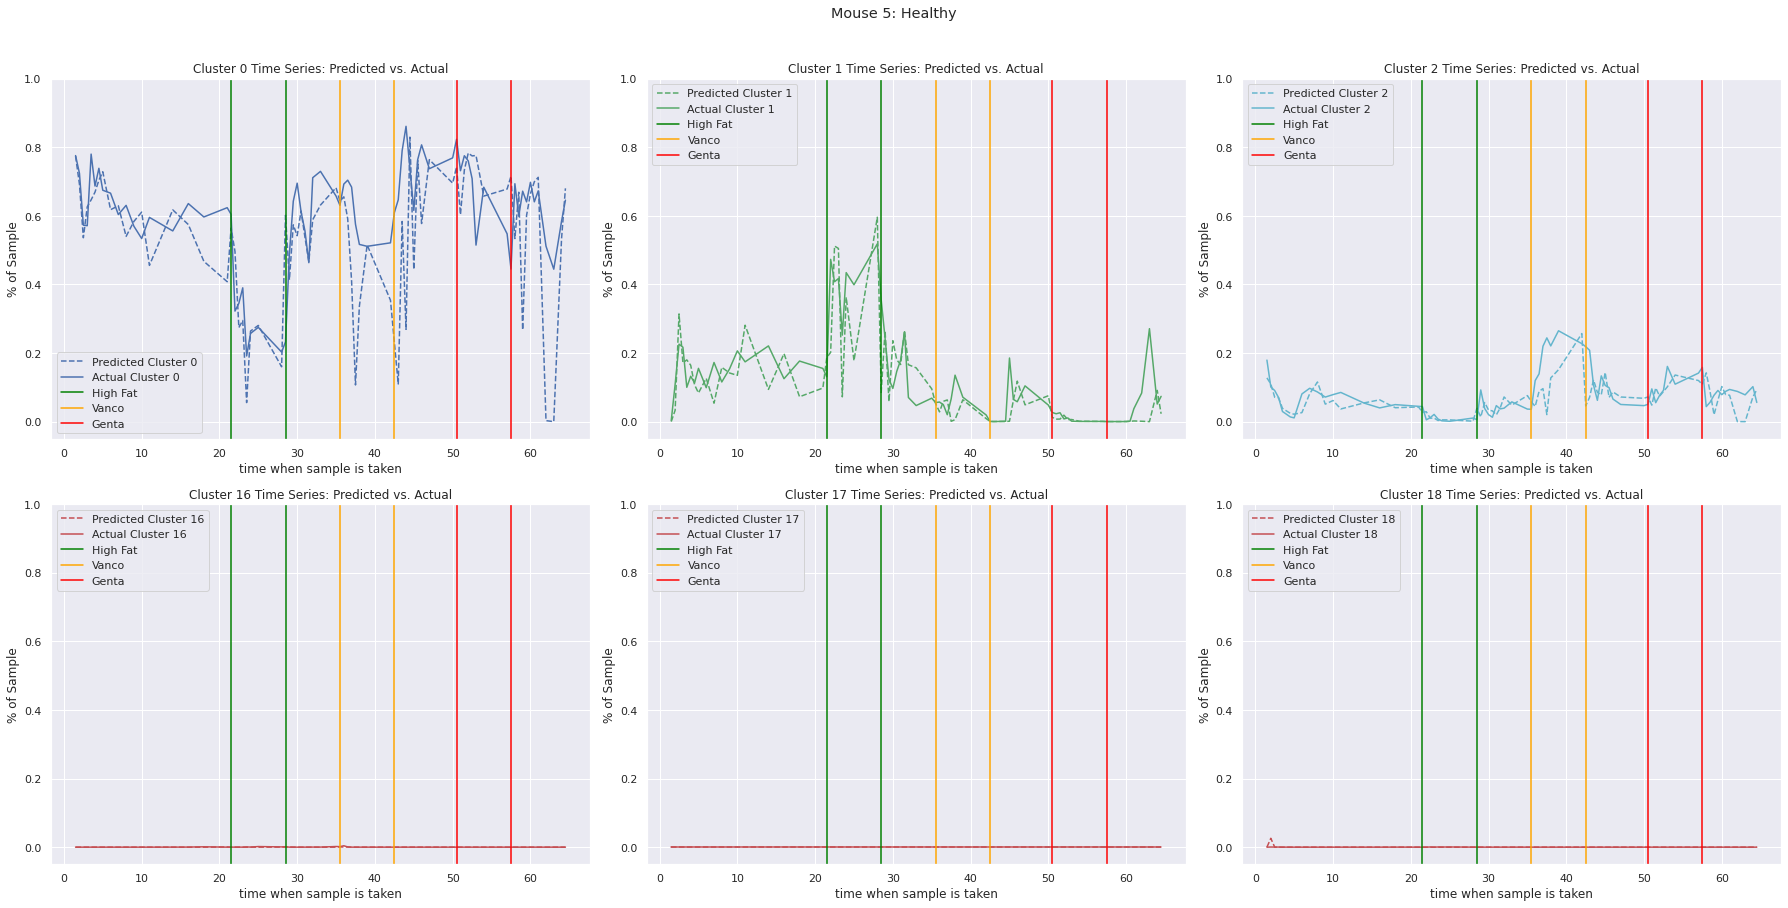

In [ ]:
sns.set()
plot_results(5,"Healthy")

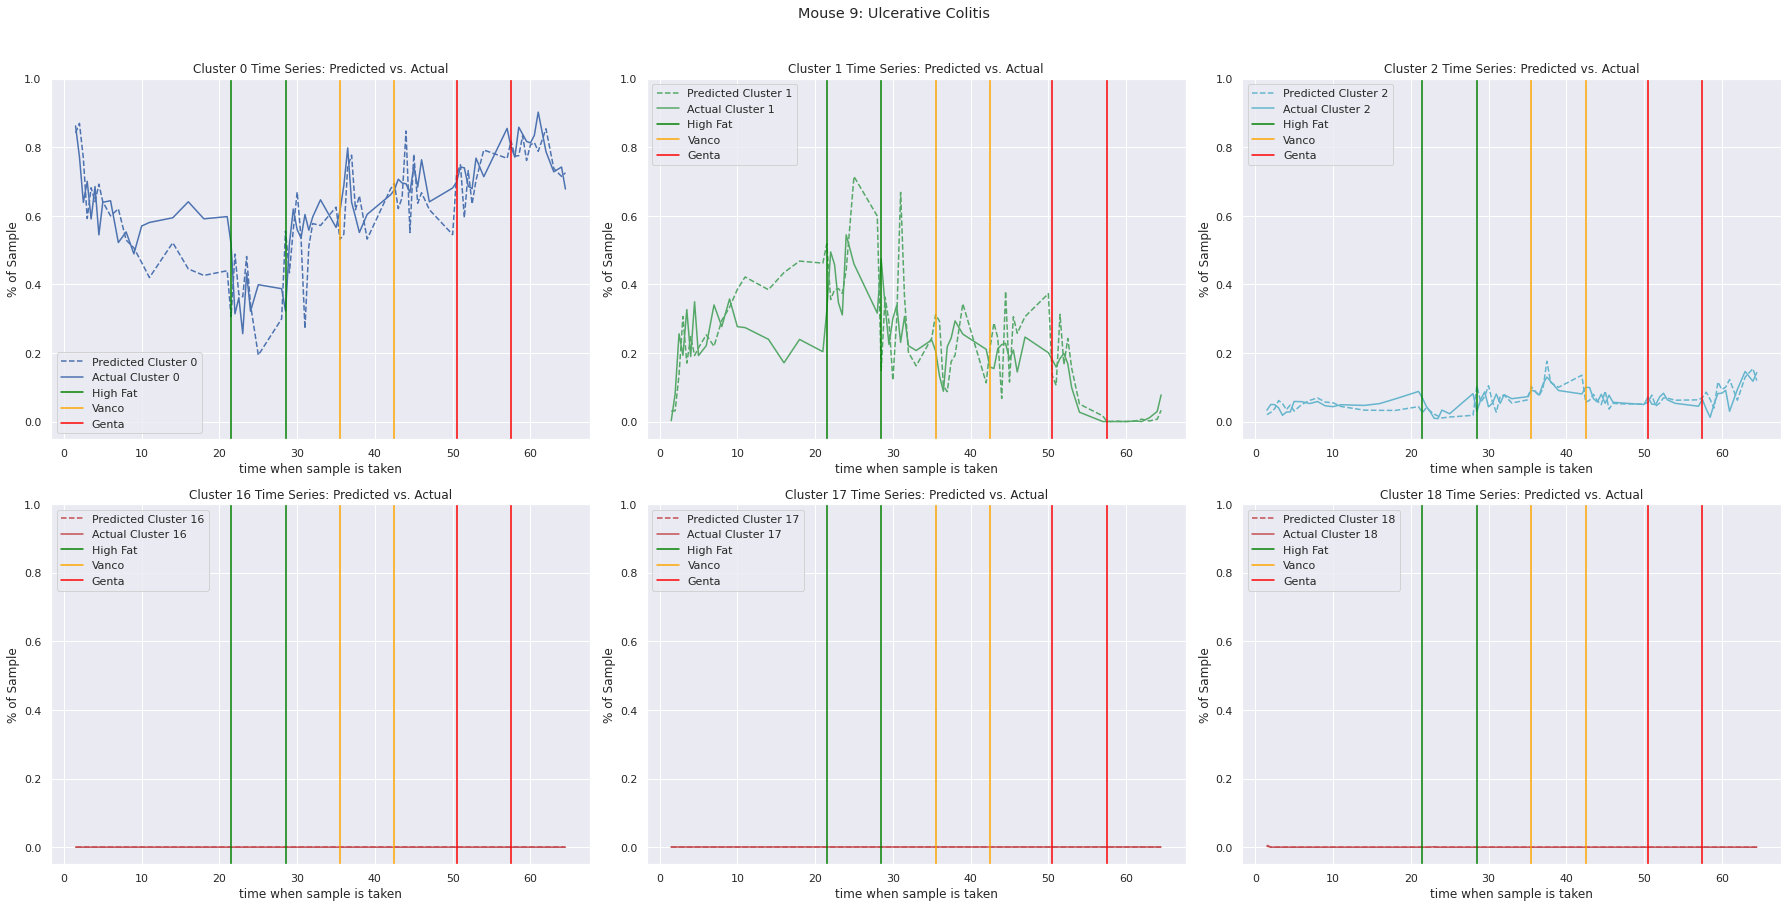

In [ ]:
plot_results(9,"Ulcerative Colitis")

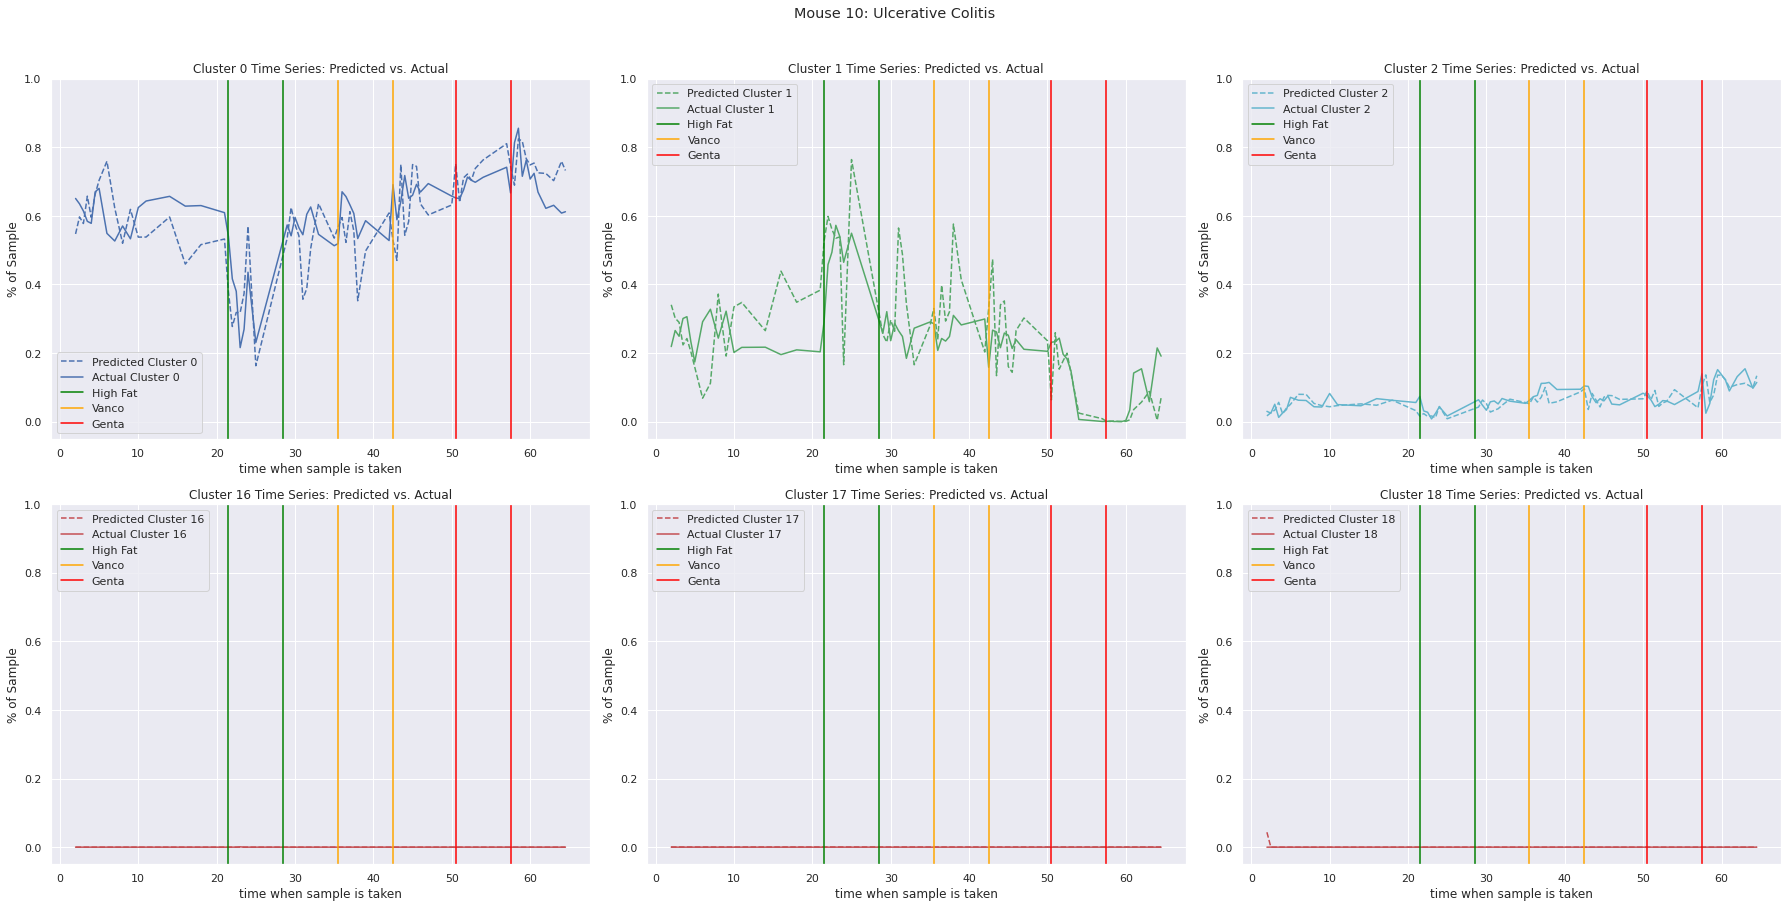

In [ ]:
plot_results(10,"Ulcerative Colitis")

Overall, the linear regression model predictions generally follow the actual trends for relative proportions for the clusters selected. However, we can see that the model predicts larger fluctuations in relative cluster proportion in the latent steady state periods between perturbations, such as cluster 0 having a large drop in it's proportion past around time 32, when in reality the there was a minor uptick in the relative proportion at that time point. Cluster 1 for mouse 10 also had a predicted uptick in relative proportion in the post-fat perturbation period, but in reality the proportion decreased.

Another thing to note is that many of the clusters have a very low relative proportion, such as cluster 16 and 17; while it's not visible on the charts due to the bounds being between 0-100%, when zoomed in the linear regression model does slightly follow the trends in the flucations in relative cluster proportion.

### LASSO Regression

Due to the high dimensionality in the number of predictors (ie. perturbation periods, cohort, last 3 readings for each of the 32 clusters), we decided to use a penalized linear regression model, the LASSO, to reduce overfitting the model and allow for more flexibility in the prediction versus the linear regression model. The sklearn function MultiTaskLassoCV internally tuned the alpha penalization parameter at 1.0317. 

In [ ]:
from sklearn.linear_model import MultiTaskLassoCV
np.random.seed(123)
# define and fit model
lasso_model = MultiTaskLassoCV(cv=10, random_state=0).fit(train_x, train_y)
print("Alpha used to train the model: ",lasso_model.alpha_)
# make a prediction
yhat = lasso_model.predict(test_x)

Alpha used to train the model:  1.0317228215481578


In [ ]:
#exponentiate the values to transform back to adjusted abundance, then divide by total sample adjusted abundance to get proportions for each cluster
yhat_df = np.exp(pd.DataFrame(yhat))
yhat_df.columns = aggregate_df_final.columns[10:] #Cluster column names
yhat_proportions_df = yhat_df.div(pd.DataFrame(yhat_df).sum(axis=1),axis=0).reset_index(drop=True)

#square the residuals to set up for calculating rmse (fully calculated after groupby subject)
residuals_squared_lasso=np.square(yhat_proportions_df.subtract(test_y_proportions.drop(["time","subject"],axis=1)))

In [ ]:
#RMSE table for Lasso Regression
rmse_df_lasso  = pd.concat([regression_testing_df.iloc[:,:2].reset_index(drop=True),residuals_squared_lasso.reset_index(drop=True)],axis=1)
rmse_df_lasso = rmse_df_lasso.groupby(['subject']).mean().reset_index().drop(["time"],axis=1)
rmse_df_lasso.iloc[:,1:]=np.round(np.sqrt(rmse_df_lasso.iloc[:,1:]),4)
rmse_df_lasso.index = rmse_df_lasso.subject
rmse_df_lasso.drop("subject",axis=1, inplace=True)
rmse_df_lasso=rmse_df_lasso.T.reset_index() #rename columns
rmse_df_lasso.columns = ["Cluster",	"LASSO_Mouse5(Healthy) rmse",	"LASSO_Mouse9(UC) rmse",	"LASSO_Mouse10(UC) rmse"]
rmse_df_lasso.head()

,Cluster,LASSO_Mouse5(Healthy) rmse,LASSO_Mouse9(UC) rmse,LASSO_Mouse10(UC) rmse
0,Cluster_0,0.1326,0.1152,0.1168
1,Cluster_1,0.0892,0.1255,0.1348
2,Cluster_10,0.0051,0.0006,0.0001
3,Cluster_11,0.0018,0.0000,0.0002
4,Cluster_12,0.0022,0.0025,0.0043


In [ ]:
#RMSE across all steady states
rmse_df_lasso_latent_steady_states  = pd.concat([regression_testing_df.iloc[:,:2].reset_index(drop=True),residuals_squared_lasso.reset_index(drop=True)],axis=1)
rmse_df_lasso_latent_steady_states = rmse_df_lasso_latent_steady_states.loc[((rmse_df_lasso_latent_steady_states.time >=28.5) & (rmse_df_lasso_latent_steady_states.time <=35.4)) |
                                                                              ((rmse_df_lasso_latent_steady_states.time >=42.5) & (rmse_df_lasso_latent_steady_states.time <=50.4)) |
                                                                              ((rmse_df_lasso_latent_steady_states.time >=57.5))] 
rmse_df_lasso_latent_steady_states = rmse_df_lasso_latent_steady_states.groupby(['subject']).mean().reset_index().drop(["time"],axis=1)
rmse_df_lasso_latent_steady_states.iloc[:,1:]=round(np.sqrt(rmse_df_lasso_latent_steady_states.iloc[:,1:]),4) 
rmse_df_lasso_latent_steady_states.index = rmse_df_lasso_latent_steady_states.subject
rmse_df_lasso_latent_steady_states.drop("subject",axis=1, inplace=True)
rmse_df_lasso_latent_steady_states=rmse_df_lasso_latent_steady_states.T.reset_index() #rename columns
rmse_df_lasso_latent_steady_states.columns = ["Cluster",	"LASSO_Mouse5(Healthy) rmse",	"LASSO_Mouse9(UC) rmse",	"LASSO_Mouse10(UC) rmse"]
rmse_df_lasso_latent_steady_states.head()

,Cluster,LASSO_Mouse5(Healthy) rmse,LASSO_Mouse9(UC) rmse,LASSO_Mouse10(UC) rmse
0,Cluster_0,0.1196,0.1096,0.1100
1,Cluster_1,0.0744,0.1217,0.1284
2,Cluster_10,0.0054,0.0001,0.0000
3,Cluster_11,0.0009,0.0000,0.0003
4,Cluster_12,0.0012,0.0025,0.0027


In [ ]:
#RMSE table for Lasso Regression for latent_steady state post fat and before vancomycin
rmse_df_lasso_post_fat  = pd.concat([regression_testing_df.iloc[:,:2].reset_index(drop=True),residuals_squared_lasso.reset_index(drop=True)],axis=1)
rmse_df_lasso_post_fat = rmse_df_lasso_post_fat.loc[((rmse_df_lasso_post_fat.time >=28.5) & (rmse_df_lasso_post_fat.time <=35.4))] 

rmse_df_lasso_post_fat = rmse_df_lasso_post_fat.groupby(['subject']).mean().reset_index().drop(["time"],axis=1)
rmse_df_lasso_post_fat.iloc[:,1:]=round(np.sqrt(rmse_df_lasso_post_fat.iloc[:,1:]),4) 
rmse_df_lasso_post_fat.index = rmse_df_lasso_post_fat.subject
rmse_df_lasso_post_fat.drop("subject",axis=1, inplace=True)
rmse_df_lasso_post_fat=rmse_df_lasso_post_fat.T.reset_index() #rename columns
rmse_df_lasso_post_fat.columns = ["Cluster", "LASSO_Mouse5(Healthy) rmse",  "LASSO_Mouse9(UC) rmse", "LASSO_Mouse10(UC) rmse"]
rmse_df_lasso_post_fat.head()

,Cluster,LASSO_Mouse5(Healthy) rmse,LASSO_Mouse9(UC) rmse,LASSO_Mouse10(UC) rmse
0,Cluster_0,0.1246,0.1690,0.1490
1,Cluster_1,0.0789,0.2111,0.1971
2,Cluster_10,0.0063,0.0000,0.0000
3,Cluster_11,0.0002,0.0000,0.0000
4,Cluster_12,0.0008,0.0006,0.0007


In [ ]:
#RMSE table for Lasso Regression for latent_steady state post Vanco and before Gentamicin
rmse_df_lasso_post_vanco  = pd.concat([regression_testing_df.iloc[:,:2].reset_index(drop=True),residuals_squared_lasso.reset_index(drop=True)],axis=1)
rmse_df_lasso_post_vanco = rmse_df_lasso_post_vanco.loc[((rmse_df_lasso_post_vanco.time >=42.5) & (rmse_df_lasso_post_vanco.time <=50.4))] 

rmse_df_lasso_post_vanco = rmse_df_lasso_post_vanco.groupby(['subject']).mean().reset_index().drop(["time"],axis=1)
rmse_df_lasso_post_vanco.iloc[:,1:]=round(np.sqrt(rmse_df_lasso_post_vanco.iloc[:,1:]),4) 
rmse_df_lasso_post_vanco.index = rmse_df_lasso_post_vanco.subject
rmse_df_lasso_post_vanco.drop("subject",axis=1, inplace=True)
rmse_df_lasso_post_vanco=rmse_df_lasso_post_vanco.T.reset_index() #rename columns
rmse_df_lasso_post_vanco.columns = ["Cluster", "LASSO_Mouse5(Healthy) rmse",  "LASSO_Mouse9(UC) rmse", "LASSO_Mouse10(UC) rmse"]
rmse_df_lasso_post_vanco.head()

,Cluster,LASSO_Mouse5(Healthy) rmse,LASSO_Mouse9(UC) rmse,LASSO_Mouse10(UC) rmse
0,Cluster_0,0.1054,0.0387,0.0835
1,Cluster_1,0.0642,0.0513,0.1045
2,Cluster_10,0.0001,0.0000,0.0000
3,Cluster_11,0.0015,0.0000,0.0000
4,Cluster_12,0.0016,0.0013,0.0009


In [ ]:
#RMSE table for Lasso Regression for latent_steady state post Gentamicin
rmse_df_lasso_post_genta  = pd.concat([regression_testing_df.iloc[:,:2].reset_index(drop=True),residuals_squared_lasso.reset_index(drop=True)],axis=1)
rmse_df_lasso_post_genta = rmse_df_lasso_post_genta.loc[((rmse_df_lasso_post_genta.time >=57.5))] 
rmse_df_lasso_post_genta = rmse_df_lasso_post_genta.groupby(['subject']).mean().reset_index().drop(["time"],axis=1)
rmse_df_lasso_post_genta.iloc[:,1:]=round(np.sqrt(rmse_df_lasso_post_genta.iloc[:,1:]),4) 
rmse_df_lasso_post_genta.index = rmse_df_lasso_post_genta.subject
rmse_df_lasso_post_genta.drop("subject",axis=1, inplace=True)
rmse_df_lasso_post_genta=rmse_df_lasso_post_genta.T.reset_index() #rename columns
rmse_df_lasso_post_genta.columns = ["Cluster", "LASSO_Mouse5(Healthy) rmse",  "LASSO_Mouse9(UC) rmse", "LASSO_Mouse10(UC) rmse"]
rmse_df_lasso_post_genta.head()

,Cluster,LASSO_Mouse5(Healthy) rmse,LASSO_Mouse9(UC) rmse,LASSO_Mouse10(UC) rmse
0,Cluster_0,0.1264,0.0837,0.0939
1,Cluster_1,0.0782,0.0126,0.0661
2,Cluster_10,0.0067,0.0001,0.0001
3,Cluster_11,0.0001,0.0000,0.0004
4,Cluster_12,0.0010,0.0039,0.0042


Evaluating the RMSE for the LASSO regression model, we can see across all time periods and for the subsets of the time periods on the latent steady states that Cluster 0 and Cluster 1 have a higher RMSE than the other Clusters. Overall, the RMSE though is decent, and the models fit the actual data reasonably.

In [ ]:
# Add time and subject to each the predicted proportions dataframes to plot; actuals have already been done
yhat_proportions_df = pd.concat([pd.DataFrame(regression_testing_df.iloc[:,:2]).reset_index(drop=True),pd.DataFrame(yhat_proportions_df).reset_index(drop=True)],axis=1)

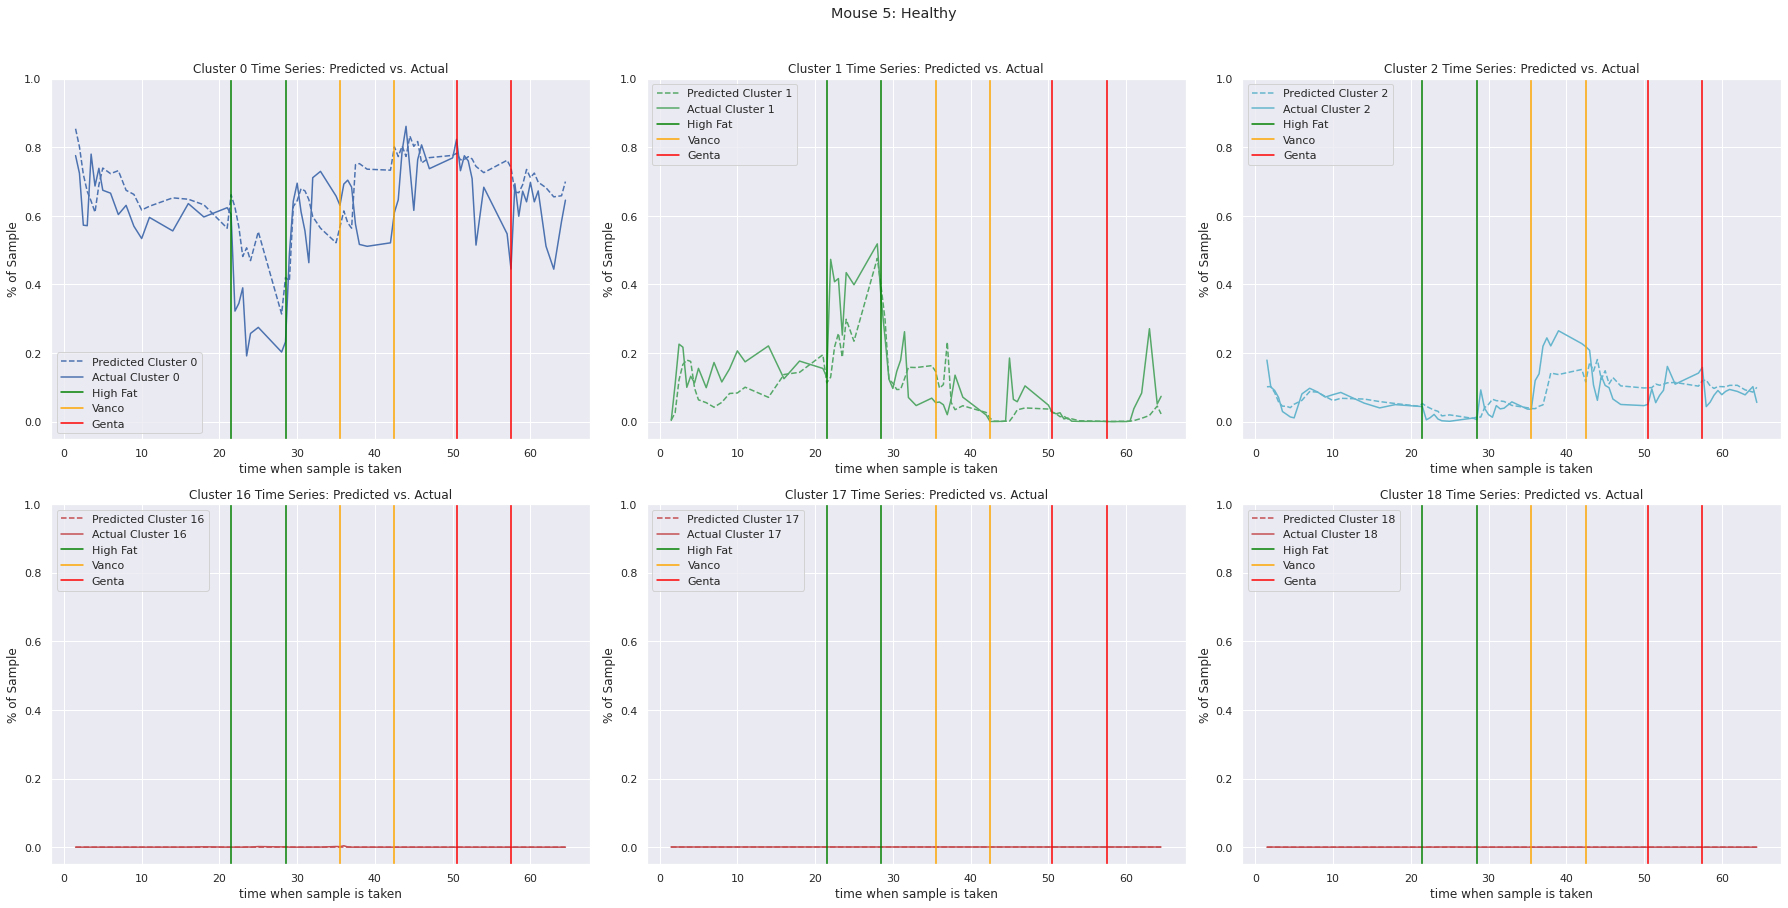

In [ ]:
plot_results(5,"Healthy")

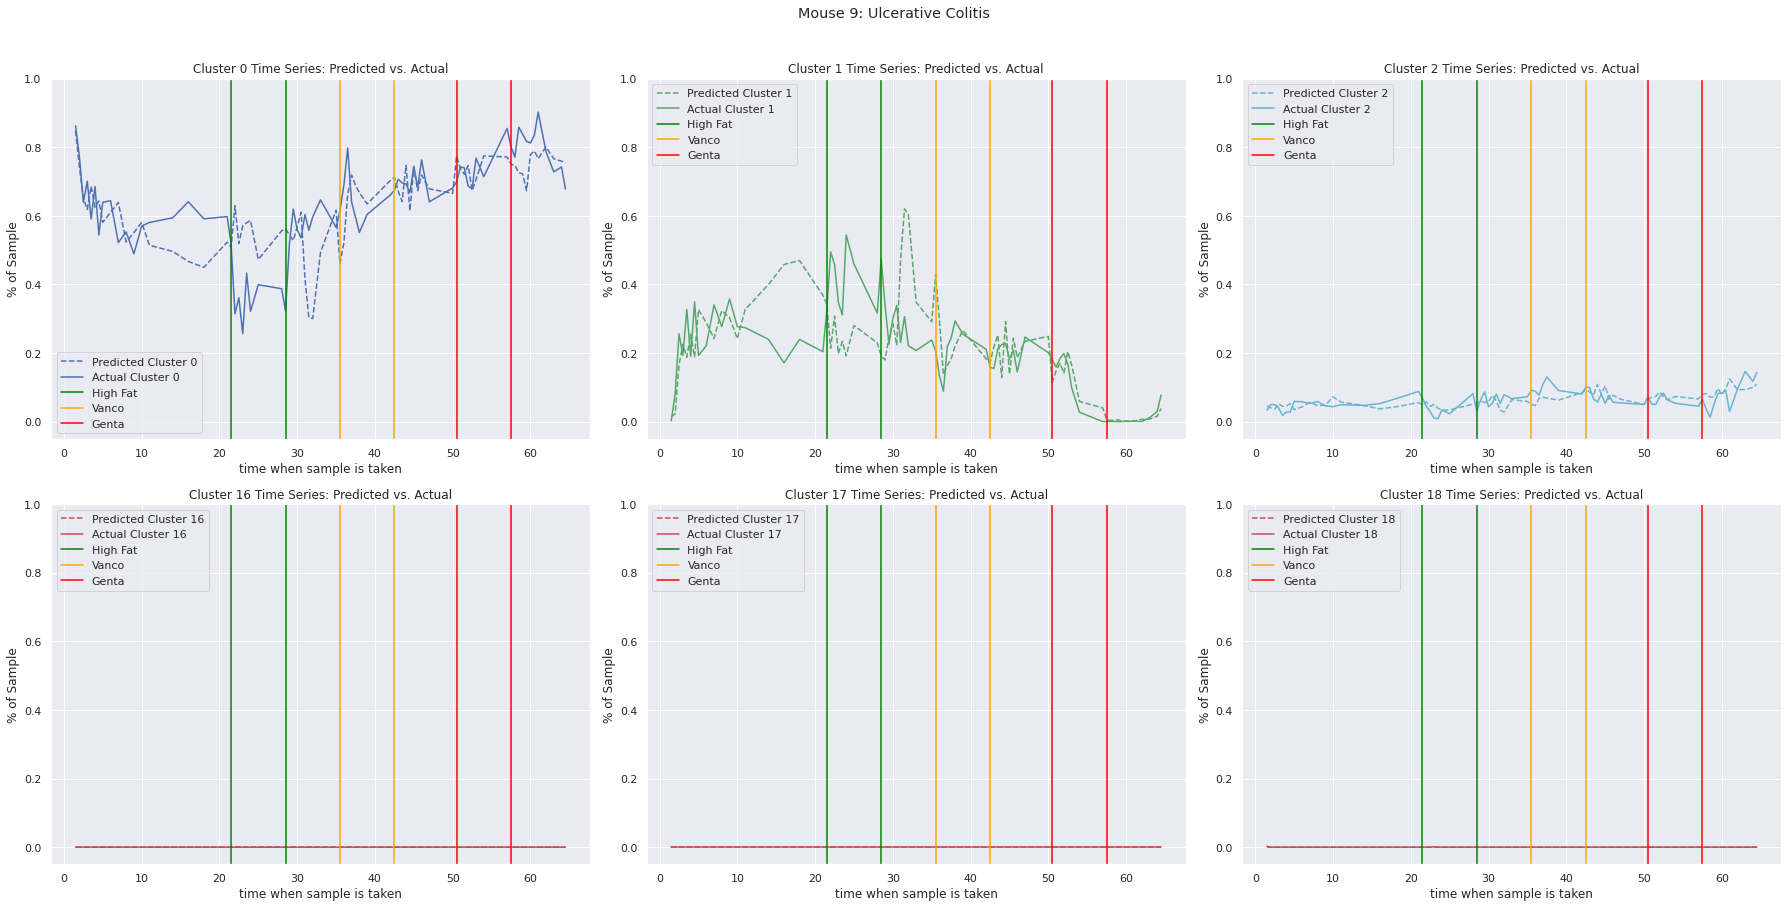

In [ ]:
plot_results(9,"Ulcerative Colitis")

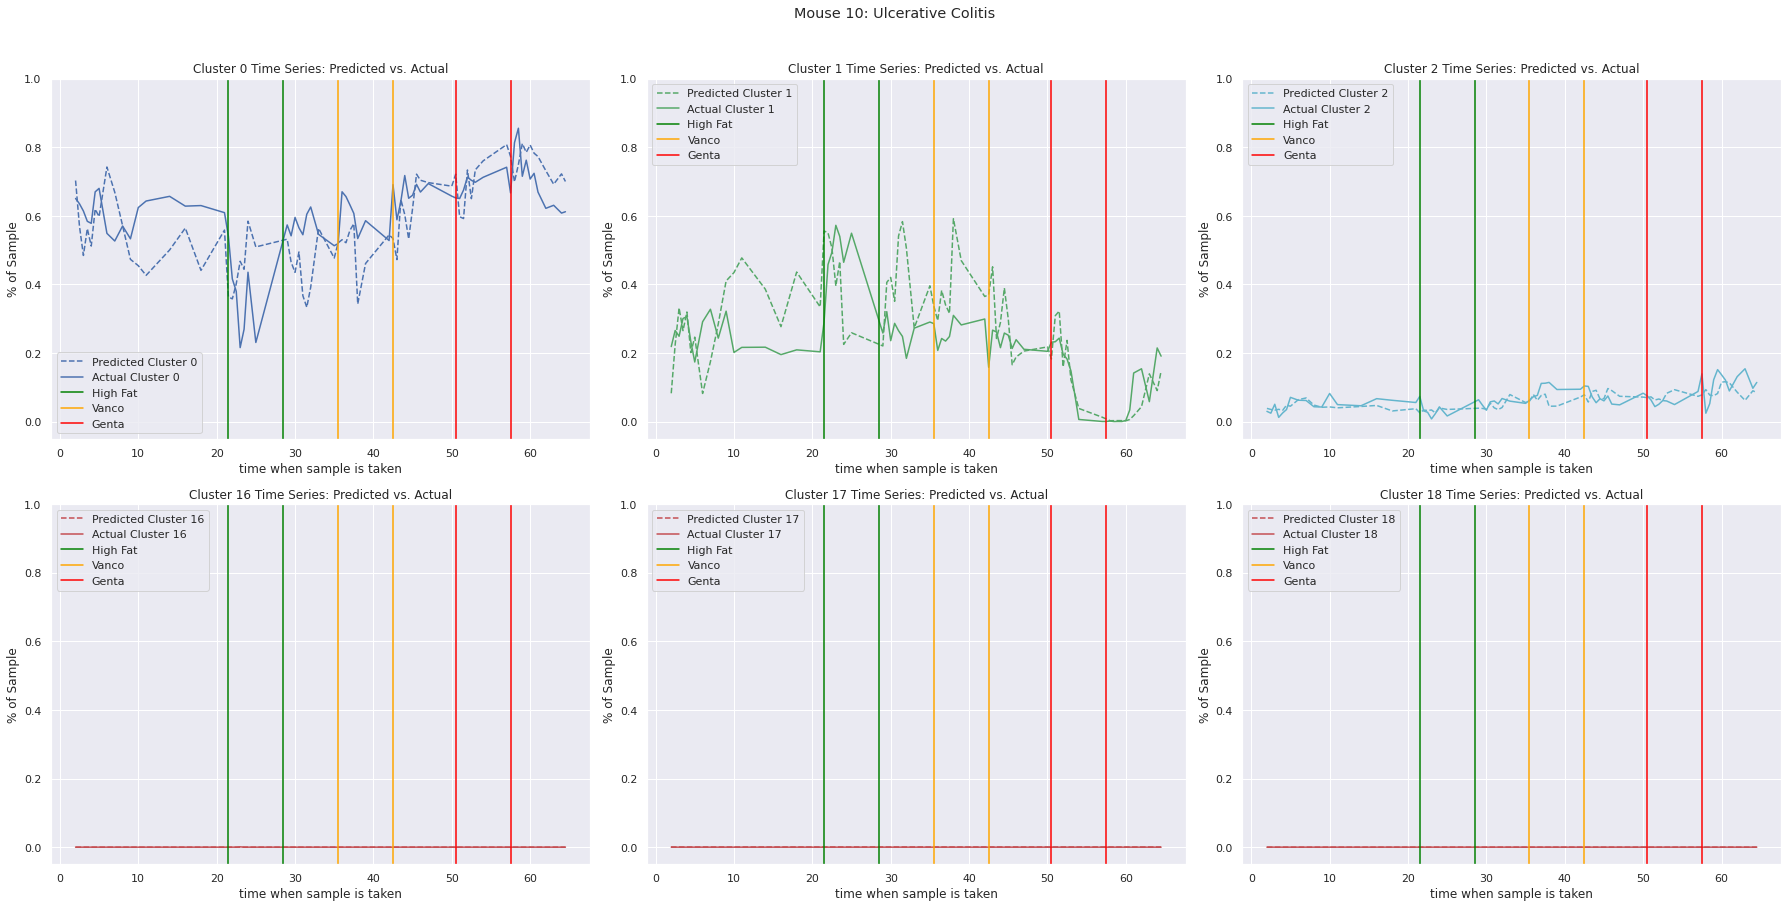

In [ ]:
plot_results(10,"Ulcerative Colitis")

Looking across all the plots for the 5 mice, the LASSO model visually has a reasonable performance in following the overall trends for the relative proportions for the selected clusters. While the LASSO still predicts wide fluctuations in relative proportion during the latent steady-state periods for some the larger clusters (ie. Cluster 0 and Cluster 1), the flucations are not as extreme as the linear regression model, insinuating that the LASSO performs better. We will compare the linear and LASSO model more in detail at the end.

## Deep Learning Models


Given we are working with time series data, we decided to use the long short-term memory (LSTM) and GRU models to predict the distribution of the microbiome environment. While the time between samples being taken were relatively distributed evenly across mice, there were a couple time points and samples that were not collected across a couple of the mice. The LSTM model generally works well in these situations and account for the gap in the sample.

Moreover, opted to attempt a GRU as it is more computationally efficient, and given the size of the dataset and because the GRU has to train fewer parameters, it is less likely to overfit to the training data. 

A discussion with how we structure the data is provided below, before the LSTM model construction. Hence, we thought given our problem, it would be interesting to compare these two models. 

Finally, given size of data, we kept the LSTM and GRU models light with only two dense layers.



### Data Processing for LSTM and GRU


In [ ]:
# Finding days where some mice were not sampled
missing = []
for i in range(2,11):
  check = []
  for j in np.sort(metadata[metadata['subject'] == 2]['time'].values):
    
    if j not in metadata[metadata['subject'] == i]['time'].values:
        missing.append(j)
  
print("Some mice were not sampled for all of the 77 days. Here are the missing days:")
np.unique(missing)

Some mice were not sampled for all of the 77 days. Here are the missing days:


array([ 0.5, 28. , 28.5, 37.5, 57.5])

In [ ]:
### Processing dataframe to run LSTM and GRU

# Processing training data
training_df = aggregate_df3.loc[aggregate_df3.subject.isin(sample_1+sample_2)]
training_df = training_df.reset_index()
training_df = training_df.drop(["adjusted_abundance","log_adjusted_abundance"],axis=1)
training_df.columns = ["Unnamed: 0","Cluster","subject","time","abund_prop",'0','1','2','3','4','5','6',"Healthy"]
training_df = training_df.rename(columns = {'0':"baseline", '1':'high_fat', '2':'post_high_fat', '3':'vanco', '4':'post_vanco', '5':'genta', '6':'post_genta'})
training_df = training_df.join(pd.get_dummies(training_df["subject"]))
training_df = training_df.pivot_table(values='abund_prop', index=['time','subject', 'baseline',	'high_fat',	'post_high_fat',	'vanco',	'post_vanco',\
                                                                  'genta',	'post_genta', 'Healthy', 2,3,4,6,7,8], columns='Cluster').reset_index()
training_df = training_df.sort_values(['subject', 'time'])
training_df = training_df.rename(columns={2:'2', 3:'3', 4:'4', 6:'6', 7:'7', 8:'8'})

# One hot encoding the test clusters  
training_df['5'] = [int(x) for x in list(np.zeros(training_df.shape[0]))]
training_df['9'] = [int(x) for x in list(np.zeros(training_df.shape[0]))]
training_df['10'] = [int(x) for x in list(np.zeros(training_df.shape[0]))]

# Move the column to head of list using index, pop and insert
cols = list(training_df.columns)
cols.insert(13, cols.pop(cols.index('5')))
cols.insert(17, cols.pop(cols.index('9')))
cols.insert(18, cols.pop(cols.index('10')))

# Reorder
training_df = training_df[cols]

# Time column is not required anymore
training_df = training_df.drop('time', axis=1)
training_df.head()

Cluster,subject,baseline,high_fat,post_high_fat,vanco,post_vanco,genta,post_genta,Healthy,2,3,4,5,6,7,8,9,10,Cluster_0,Cluster_1,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_2,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,Cluster_3,Cluster_30,Cluster_31,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.559471,0.004078,3.112572e-06,5.187620e-07,3.057908e-03,9.078336e-07,1.037524e-06,1.296905e-07,1.296905e-07,6.484525e-08,6.112184e-03,8.429883e-07,0.225368,4.539168e-07,8.429883e-07,4.838558e-03,3.890715e-07,1.296905e-07,7.781431e-07,2.037243e-03,1.296905e-07,6.484525e-08,1.296905e-07,0.017066,6.484525e-08,6.484525e-08,4.052089e-02,3.718084e-02,9.168795e-03,0.091176,2.399274e-06,1.815667e-06
6,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.534291,0.001817,3.960459e-07,6.600765e-08,2.887835e-07,1.155134e-07,1.320153e-07,1.650191e-08,1.650191e-08,8.250956e-09,2.270960e-03,1.072624e-07,0.071669,5.775669e-08,1.072624e-07,7.267112e-04,4.542151e-04,1.650191e-08,9.901147e-08,6.358517e-04,1.650191e-08,8.250956e-09,1.650191e-08,0.215461,8.250956e-09,8.250956e-09,3.007027e-02,1.725889e-02,2.062739e-07,0.124627,3.052854e-07,7.268844e-04
12,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.460826,0.006735,4.798415e-08,6.324211e-05,2.845920e-04,1.399538e-08,1.599472e-08,1.999339e-09,1.999339e-09,9.996697e-10,1.399538e-08,1.299571e-08,0.230492,6.997688e-09,1.299571e-08,4.998349e-09,5.998018e-09,1.999339e-09,1.199604e-08,1.999339e-09,1.999339e-09,9.996697e-10,1.999339e-09,0.011888,9.996697e-10,9.996697e-10,5.078322e-07,5.498183e-08,1.327939e-02,0.276401,3.698778e-08,3.164455e-05
18,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.736061,0.013196,2.713460e-08,4.755621e-05,5.230934e-04,7.914257e-09,9.044865e-09,1.130608e-09,1.130608e-09,5.653041e-10,7.914257e-09,2.378291e-05,0.209515,3.957129e-09,7.348953e-09,2.826520e-09,3.391824e-09,1.130608e-09,6.783649e-09,1.130608e-09,1.130608e-09,5.653041e-10,1.130608e-09,0.002235,5.653041e-10,5.653041e-10,4.826835e-03,2.140156e-04,9.511750e-05,0.033263,2.091625e-08,1.582851e-08
24,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0.792107,0.015225,1.443299e-08,2.601069e-04,5.132750e-03,4.209623e-09,4.810998e-09,6.013747e-10,6.013747e-10,3.006874e-10,1.976802e-03,5.202462e-05,0.100817,6.936316e-05,3.908936e-09,1.503437e-09,1.804124e-09,6.013747e-10,3.608248e-09,6.013747e-10,6.013747e-10,3.006874e-10,6.013747e-10,0.009832,3.006874e-10,3.006874e-10,4.295216e-02,2.668680e-02,2.340952e-03,0.001526,3.469150e-05,9.884059e-04


In [ ]:
### Processing dataframe to run LSTM and GRU

# Processing testing data
testing_df = aggregate_df3.loc[~aggregate_df3.subject.isin((sample_1+sample_2))]
testing_df = testing_df.reset_index()
testing_df = testing_df.drop(["adjusted_abundance","log_adjusted_abundance"],axis=1)
testing_df.columns = ["Unnamed: 0","Cluster","subject","time","abund_prop",'0','1','2','3','4','5','6',"Healthy"]
testing_df = testing_df.rename(columns = {'0':"baseline", '1':'high_fat', '2':'post_high_fat', '3':'vanco', '4':'post_vanco', '5':'genta', '6':'post_genta'})
testing_df = testing_df.join(pd.get_dummies(testing_df["subject"]))
testing_df = testing_df.pivot_table(values='abund_prop', index=['time','subject', 'baseline',	'high_fat',	'post_high_fat',	'vanco',	'post_vanco',\
                                                                  'genta',	'post_genta', 'Healthy', 5,9,10], columns='Cluster').reset_index()
testing_df = testing_df.sort_values(['subject', 'time'])
testing_df = testing_df.rename(columns={5:'5', 9:'9', 10:'10'})

# One hot encoding the train clusters  
testing_df['2'] = [int(x) for x in list(np.zeros(testing_df.shape[0]))]
testing_df['3'] = [int(x) for x in list(np.zeros(testing_df.shape[0]))]
testing_df['4'] = [int(x) for x in list(np.zeros(testing_df.shape[0]))]
testing_df['6'] = [int(x) for x in list(np.zeros(testing_df.shape[0]))]
testing_df['7'] = [int(x) for x in list(np.zeros(testing_df.shape[0]))]
testing_df['8'] = [int(x) for x in list(np.zeros(testing_df.shape[0]))]


# Move the column to head of list using index, pop and insert
cols = list(testing_df.columns)
cols.insert(10, cols.pop(cols.index('2')))
cols.insert(11, cols.pop(cols.index('3')))
cols.insert(12, cols.pop(cols.index('4')))
cols.insert(14, cols.pop(cols.index('6')))
cols.insert(15, cols.pop(cols.index('7')))
cols.insert(16, cols.pop(cols.index('8')))

# Reorder
testing_df = testing_df[cols]

# # Time column is not required anymore
testing_df = testing_df.drop('time', axis=1)
testing_df.head()

Cluster,subject,baseline,high_fat,post_high_fat,vanco,post_vanco,genta,post_genta,Healthy,2,3,4,5,6,7,8,9,10,Cluster_0,Cluster_1,Cluster_10,Cluster_11,Cluster_12,Cluster_13,Cluster_14,Cluster_15,Cluster_16,Cluster_17,Cluster_18,Cluster_19,Cluster_2,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29,Cluster_3,Cluster_30,Cluster_31,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,5,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.784331,0.007448,4.995878e-07,5.101728e-04,4.081133e-03,2.041649e-04,1.665293e-07,2.081616e-08,2.081616e-08,1.040808e-08,3.060714e-03,1.353050e-07,0.101511,7.285656e-08,1.353050e-07,6.121616e-04,6.244848e-08,3.060704e-04,1.248970e-07,2.081616e-08,2.081616e-08,1.040808e-08,2.081616e-08,0.005204,1.040808e-08,1.040808e-08,0.046322,2.285282e-02,0.000204,0.022854,1.023947e-04,4.083506e-04
3,5,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.016878,0.001272,1.123329e-04,1.120346e-08,4.901513e-08,1.960605e-08,2.240691e-08,2.800864e-09,2.800864e-09,7.484470e-04,7.486290e-05,1.820562e-08,0.001422,9.803025e-09,1.820562e-08,7.002161e-09,8.402593e-09,2.800864e-09,1.680519e-08,2.800864e-09,2.800864e-09,1.400432e-09,2.800864e-09,0.415538,1.400432e-09,1.400432e-09,0.001498,7.702377e-08,0.000674,0.560175,5.181599e-08,1.609199e-03
5,5,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.683672,0.000953,5.559291e-08,9.265485e-09,1.089067e-03,1.621460e-08,1.853097e-08,2.316371e-09,2.316371e-09,1.158186e-09,1.621460e-08,1.505641e-08,0.201096,8.107299e-09,1.505641e-08,5.790928e-09,6.949114e-09,2.316371e-09,1.389823e-08,2.316371e-09,2.316371e-09,1.158186e-09,2.316371e-09,0.015008,1.158186e-09,1.158186e-09,0.000477,6.370021e-08,0.015859,0.081813,3.407382e-05,3.242920e-08
8,5,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.775884,0.003522,3.872867e-08,6.454778e-09,9.942044e-04,1.129586e-08,1.290956e-08,1.613694e-09,1.613694e-09,8.068472e-10,1.129586e-08,1.048901e-08,0.179463,5.647930e-09,1.048901e-08,4.034236e-09,4.841083e-09,1.613694e-09,9.682167e-09,1.613694e-09,1.613694e-09,8.068472e-10,1.613694e-09,0.010425,8.068472e-10,8.068472e-10,0.005568,5.685368e-05,0.000028,0.023832,2.985335e-08,2.272606e-04
11,5,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0.724174,0.108906,1.963980e-08,2.427360e-04,4.187161e-03,5.728274e-09,6.546599e-09,8.183249e-10,8.183249e-10,4.091625e-10,3.843324e-04,5.319112e-09,0.100977,2.864137e-09,5.319112e-09,2.045812e-09,2.454975e-09,8.183249e-10,4.909950e-09,8.183249e-10,8.183249e-10,4.091625e-10,8.183249e-10,0.016971,4.091625e-10,4.091625e-10,0.019237,2.111781e-02,0.000809,0.001639,1.513901e-08,1.355269e-03


In [ ]:
# Calling series_to_supervised function for train and test
time_steps = 3
lstm_df_train = series_to_supervised(training_df, time_steps, 1)
lstm_df_test = series_to_supervised(testing_df, time_steps, 1)

# Drop the rows where the X subject is not same as y subject for train and test
lstm_df_train = lstm_df_train[(lstm_df_train['subject(t-3)']==lstm_df_train['subject(t-2)']) & (lstm_df_train['subject(t-2)']==lstm_df_train['subject(t-1)'])
                        & (lstm_df_train['subject(t-1)']==lstm_df_train['subject(t)'])]

lstm_df_test = lstm_df_test[(lstm_df_test['subject(t-3)']==lstm_df_test['subject(t-2)']) & (lstm_df_test['subject(t-2)']==lstm_df_test['subject(t-1)'])
                        & (lstm_df_test['subject(t-1)']==lstm_df_test['subject(t)'])]
                        
lstm_df_train.head()

,subject(t-3),baseline(t-3),high_fat(t-3),post_high_fat(t-3),vanco(t-3),post_vanco(t-3),genta(t-3),post_genta(t-3),Healthy(t-3),2(t-3),3(t-3),4(t-3),5(t-3),6(t-3),7(t-3),8(t-3),9(t-3),10(t-3),Cluster_0(t-3),Cluster_1(t-3),Cluster_10(t-3),Cluster_11(t-3),Cluster_12(t-3),Cluster_13(t-3),Cluster_14(t-3),Cluster_15(t-3),Cluster_16(t-3),Cluster_17(t-3),Cluster_18(t-3),Cluster_19(t-3),Cluster_2(t-3),Cluster_20(t-3),Cluster_21(t-3),Cluster_22(t-3),Cluster_23(t-3),Cluster_24(t-3),Cluster_25(t-3),Cluster_26(t-3),Cluster_27(t-3),Cluster_28(t-3),...,3(t),4(t),5(t),6(t),7(t),8(t),9(t),10(t),Cluster_0(t),Cluster_1(t),Cluster_10(t),Cluster_11(t),Cluster_12(t),Cluster_13(t),Cluster_14(t),Cluster_15(t),Cluster_16(t),Cluster_17(t),Cluster_18(t),Cluster_19(t),Cluster_2(t),Cluster_20(t),Cluster_21(t),Cluster_22(t),Cluster_23(t),Cluster_24(t),Cluster_25(t),Cluster_26(t),Cluster_27(t),Cluster_28(t),Cluster_29(t),Cluster_3(t),Cluster_30(t),Cluster_31(t),Cluster_4(t),Cluster_5(t),Cluster_6(t),Cluster_7(t),Cluster_8(t),Cluster_9(t)
18,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.559471,0.004078,3.112572e-06,5.187620e-07,3.057908e-03,9.078336e-07,1.037524e-06,1.296905e-07,1.296905e-07,6.484525e-08,6.112184e-03,8.429883e-07,0.225368,4.539168e-07,8.429883e-07,4.838558e-03,3.890715e-07,1.296905e-07,7.781431e-07,2.037243e-03,1.296905e-07,6.484525e-08,...,0,0,0,0,0,0,0,0,0.736061,0.013196,2.713460e-08,4.755621e-05,0.000523,7.914257e-09,9.044865e-09,1.130608e-09,1.130608e-09,5.653041e-10,7.914257e-09,2.378291e-05,0.209515,3.957129e-09,7.348953e-09,2.826520e-09,3.391824e-09,1.130608e-09,6.783649e-09,1.130608e-09,1.130608e-09,5.653041e-10,1.130608e-09,0.002235,5.653041e-10,5.653041e-10,0.004827,0.000214,0.000095,0.033263,2.091625e-08,1.582851e-08
24,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.534291,0.001817,3.960459e-07,6.600765e-08,2.887835e-07,1.155134e-07,1.320153e-07,1.650191e-08,1.650191e-08,8.250956e-09,2.270960e-03,1.072624e-07,0.071669,5.775669e-08,1.072624e-07,7.267112e-04,4.542151e-04,1.650191e-08,9.901147e-08,6.358517e-04,1.650191e-08,8.250956e-09,...,0,0,0,0,0,0,0,0,0.792107,0.015225,1.443299e-08,2.601069e-04,0.005133,4.209623e-09,4.810998e-09,6.013747e-10,6.013747e-10,3.006874e-10,1.976802e-03,5.202462e-05,0.100817,6.936316e-05,3.908936e-09,1.503437e-09,1.804124e-09,6.013747e-10,3.608248e-09,6.013747e-10,6.013747e-10,3.006874e-10,6.013747e-10,0.009832,3.006874e-10,3.006874e-10,0.042952,0.026687,0.002341,0.001526,3.469150e-05,9.884059e-04
30,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.460826,0.006735,4.798415e-08,6.324211e-05,2.845920e-04,1.399538e-08,1.599472e-08,1.999339e-09,1.999339e-09,9.996697e-10,1.399538e-08,1.299571e-08,0.230492,6.997688e-09,1.299571e-08,4.998349e-09,5.998018e-09,1.999339e-09,1.199604e-08,1.999339e-09,1.999339e-09,9.996697e-10,...,0,0,0,0,0,0,0,0,0.589102,0.103606,2.164447e-08,3.607412e-09,0.008154,6.312971e-09,6.371185e-05,9.018529e-10,9.018529e-10,4.509265e-10,9.768163e-04,5.862044e-09,0.114032,2.123773e-05,5.862044e-09,2.254632e-09,2.705559e-09,9.018529e-10,5.411118e-09,9.018529e-10,9.018529e-10,4.509265e-10,9.018529e-10,0.036015,4.509265e-10,4.509265e-10,0.048777,0.091672,0.004650,0.001083,8.495635e-05,1.762518e-03
36,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.736061,0.013196,2.713460e-08,4.755621e-05,5.230934e-04,7.914257e-09,9.044865e-09,1.130608e-09,1.130608e-09,5.653041e-10,7.914257e-09,2.378291e-05,0.209515,3.957129e-09,7.348953e-09,2.826520e-09,3.391824e-09,1.130608e-09,6.783649e-09,1.130608e-09,1.130608e-09,5.653041e-10,...,0,0,0,0,0,0,0,0,0.666173,0.180259,4.569935e-08,5.862636e-04,0.002839,3.702799e-04,3.086991e-05,1.904139e-09,1.904139e-09,9.520697e-10,1.234349e-04,1.237691e-08,0.039619,6.664488e-09,1.237691e-08,4.760348e-09,5.712418e-09,1.904139e-09,1.142484e-08,1.904139e-09,1.904139e-09,9.520697e-10,1.904139e-09,0.032985,9.520697e-10,9.520697e-10,0.053041,0.020704,0.000957,0.001142,3.5226

In [ ]:
# Getting subjects column names
subject_list = [colname for colname in lstm_df_train.columns if 'subject' in colname] 

# Drop subject lists
lstm_df_train.drop(subject_list, inplace=True, axis=1)
lstm_df_test.drop(subject_list, inplace=True, axis=1)

lstm_df_train.head()

,baseline(t-3),high_fat(t-3),post_high_fat(t-3),vanco(t-3),post_vanco(t-3),genta(t-3),post_genta(t-3),Healthy(t-3),2(t-3),3(t-3),4(t-3),5(t-3),6(t-3),7(t-3),8(t-3),9(t-3),10(t-3),Cluster_0(t-3),Cluster_1(t-3),Cluster_10(t-3),Cluster_11(t-3),Cluster_12(t-3),Cluster_13(t-3),Cluster_14(t-3),Cluster_15(t-3),Cluster_16(t-3),Cluster_17(t-3),Cluster_18(t-3),Cluster_19(t-3),Cluster_2(t-3),Cluster_20(t-3),Cluster_21(t-3),Cluster_22(t-3),Cluster_23(t-3),Cluster_24(t-3),Cluster_25(t-3),Cluster_26(t-3),Cluster_27(t-3),Cluster_28(t-3),Cluster_29(t-3),...,3(t),4(t),5(t),6(t),7(t),8(t),9(t),10(t),Cluster_0(t),Cluster_1(t),Cluster_10(t),Cluster_11(t),Cluster_12(t),Cluster_13(t),Cluster_14(t),Cluster_15(t),Cluster_16(t),Cluster_17(t),Cluster_18(t),Cluster_19(t),Cluster_2(t),Cluster_20(t),Cluster_21(t),Cluster_22(t),Cluster_23(t),Cluster_24(t),Cluster_25(t),Cluster_26(t),Cluster_27(t),Cluster_28(t),Cluster_29(t),Cluster_3(t),Cluster_30(t),Cluster_31(t),Cluster_4(t),Cluster_5(t),Cluster_6(t),Cluster_7(t),Cluster_8(t),Cluster_9(t)
18,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.559471,0.004078,3.112572e-06,5.187620e-07,3.057908e-03,9.078336e-07,1.037524e-06,1.296905e-07,1.296905e-07,6.484525e-08,6.112184e-03,8.429883e-07,0.225368,4.539168e-07,8.429883e-07,4.838558e-03,3.890715e-07,1.296905e-07,7.781431e-07,2.037243e-03,1.296905e-07,6.484525e-08,1.296905e-07,...,0,0,0,0,0,0,0,0,0.736061,0.013196,2.713460e-08,4.755621e-05,0.000523,7.914257e-09,9.044865e-09,1.130608e-09,1.130608e-09,5.653041e-10,7.914257e-09,2.378291e-05,0.209515,3.957129e-09,7.348953e-09,2.826520e-09,3.391824e-09,1.130608e-09,6.783649e-09,1.130608e-09,1.130608e-09,5.653041e-10,1.130608e-09,0.002235,5.653041e-10,5.653041e-10,0.004827,0.000214,0.000095,0.033263,2.091625e-08,1.582851e-08
24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.534291,0.001817,3.960459e-07,6.600765e-08,2.887835e-07,1.155134e-07,1.320153e-07,1.650191e-08,1.650191e-08,8.250956e-09,2.270960e-03,1.072624e-07,0.071669,5.775669e-08,1.072624e-07,7.267112e-04,4.542151e-04,1.650191e-08,9.901147e-08,6.358517e-04,1.650191e-08,8.250956e-09,1.650191e-08,...,0,0,0,0,0,0,0,0,0.792107,0.015225,1.443299e-08,2.601069e-04,0.005133,4.209623e-09,4.810998e-09,6.013747e-10,6.013747e-10,3.006874e-10,1.976802e-03,5.202462e-05,0.100817,6.936316e-05,3.908936e-09,1.503437e-09,1.804124e-09,6.013747e-10,3.608248e-09,6.013747e-10,6.013747e-10,3.006874e-10,6.013747e-10,0.009832,3.006874e-10,3.006874e-10,0.042952,0.026687,0.002341,0.001526,3.469150e-05,9.884059e-04
30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.460826,0.006735,4.798415e-08,6.324211e-05,2.845920e-04,1.399538e-08,1.599472e-08,1.999339e-09,1.999339e-09,9.996697e-10,1.399538e-08,1.299571e-08,0.230492,6.997688e-09,1.299571e-08,4.998349e-09,5.998018e-09,1.999339e-09,1.199604e-08,1.999339e-09,1.999339e-09,9.996697e-10,1.999339e-09,...,0,0,0,0,0,0,0,0,0.589102,0.103606,2.164447e-08,3.607412e-09,0.008154,6.312971e-09,6.371185e-05,9.018529e-10,9.018529e-10,4.509265e-10,9.768163e-04,5.862044e-09,0.114032,2.123773e-05,5.862044e-09,2.254632e-09,2.705559e-09,9.018529e-10,5.411118e-09,9.018529e-10,9.018529e-10,4.509265e-10,9.018529e-10,0.036015,4.509265e-10,4.509265e-10,0.048777,0.091672,0.004650,0.001083,8.495635e-05,1.762518e-03
36,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.736061,0.013196,2.713460e-08,4.755621e-05,5.230934e-04,7.914257e-09,9.044865e-09,1.130608e-09,1.130608e-09,5.653041e-10,7.914257e-09,2.378291e-05,0.209515,3.957129e-09,7.348953e-09,2.826520e-09,3.391824e-09,1.130608e-09,6.783649e-09,1.130608e-09,1.130608e-09,5.653041e-10,1.130608e-09,...,0,0,0,0,0,0,0,0,0.666173,0.180259,4.569935e-08,5.862636e-04,0.002839,3.702799e-04,3.086991e-05,1.904139e-09,1.904139e-09,9.520697e-10,1.234349e-04,1.237691e-08,0.039619,6.664488e-09,1.237691e-08,4.760348e-09,5.712418e-09,1.904139e-09,1.142484e-08,1.904139e-09,1.904139e-09,9.520697e-10,1.904139e-09,0.032985,9.520697e-10,9.520697e-10,0.0

In [ ]:
# Defining X_train, y_train, X_test, y_test
output_clusters = list(lstm_df_train.columns)[-32:]

train_x_lstm, test_x_lstm = lstm_df_train.values[:,:(len(clusters)+17)*time_steps], lstm_df_test.values[:,:(len(clusters)+17)*time_steps]
train_output, test_output = lstm_df_train[output_clusters], lstm_df_test[output_clusters]

train_x_lstm = train_x_lstm.reshape((train_x_lstm.shape[0], time_steps, int(train_x_lstm.shape[1]/time_steps)))
test_x_lstm = test_x_lstm.reshape((test_x_lstm.shape[0], time_steps, int(test_x_lstm.shape[1]/time_steps)))

print(f"The shape of train_x_lstm is {train_x_lstm.shape}. The shape of train_output is {train_output.shape}")

The shape of train_x_lstm is (440, 3, 49). The shape of train_output is (440, 32)


### LSTM Model

In [ ]:
# Defining our LSTM Model
rec_input = Input((train_x_lstm.shape[1], train_x_lstm.shape[2]))
output = LSTM(50, return_sequences=False)(rec_input)
output = Dense(32, activation='relu')(output)
output = Dropout(.2)(output)
output = Dense(32, activation = 'softmax')(output)

# Creating Model
lstm = Model(inputs=rec_input, outputs = output, name='Cluster_LSTM')

# Compiling
lstm.compile(loss='mse', optimizer='adam')

# Summary 
lstm.summary()

Model: "Cluster_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 3, 49)]           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20000     
_________________________________________________________________
dense_20 (Dense)             (None, 32)                1632      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
Total params: 22,688
Trainable params: 22,688
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Generating train generator and fitting the model
tf_generator = tf.data.Dataset.from_tensor_slices((train_x_lstm, train_output)).batch(8)
history = lstm.fit(tf_generator, epochs=50, shuffle=False)

Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.0124
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0018
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 10/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 11/50
55/55 [==============================] - 0s 4ms/step - loss: 9.8797e-04
Epoch 12/50
55/55 [==============================] - 0s 4ms/step - loss: 8.7351e-04
Epoch 13/50
55/55 [======================

In [ ]:
train_loss = lstm.evaluate(tf_generator)
print(f"The train loss is {train_loss}")

55/55 [==============================] - 1s 1ms/step - loss: 4.9274e-04
The train loss is 0.000492736347950995


In [ ]:
# Creating test generator
tf_generator_test = tf.data.Dataset.from_tensor_slices((test_x_lstm, test_output)).batch(8)
test_loss = lstm.evaluate(tf_generator_test)
print(f"The test loss is {test_loss}")

28/28 [==============================] - 0s 2ms/step - loss: 4.6484e-04
The test loss is 0.0004648436151910573


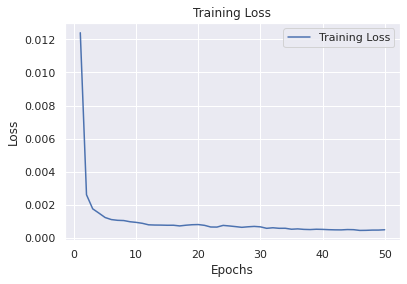

In [ ]:
## Plotting validation loss
import seaborn as sns

# Setting seaborn for plot
sns.set()

# Subsetting training and validation loss
train_loss = history.history['loss']

# Plotting
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training Loss")
plt.legend()

In [ ]:
# Predicting on the test mice
predictions_lstm = lstm.predict(test_x_lstm)

print(f"The shape of the predictions is {predictions_lstm.shape}")

The shape of the predictions is (219, 32)


#### Time Series Analysis
##### Time Series: Predicted vs. Actual

In [ ]:
# Creating actual_df
actual_df = aggregate_df3.loc[~aggregate_df3.subject.isin((sample_1+sample_2))]
actual_df = actual_df.reset_index()
actual_df = actual_df.drop(["adjusted_abundance","log_adjusted_abundance"],axis=1)
actual_df.columns = ["Unnamed: 0","Cluster","subject","time","abund_prop",'0','1','2','3','4','5','6',"Healthy"]

# Creating list of that needs to be replaced 
cluster_replace = ['Cluster_'+ str(i) for i in range(32)]

# Renaming 
actual_df['Cluster'] = actual_df['Cluster'].replace(cluster_replace,range(32))
actual_df.head()

,Unnamed: 0,Cluster,subject,time,abund_prop,0,1,2,3,4,5,6,Healthy
0,228,0,5,0.0,0.784331,1,0,0,0,0,0,0,1
1,229,0,5,0.5,0.016878,1,0,0,0,0,0,0,1
2,230,0,5,1.0,0.683672,1,0,0,0,0,0,0,1
3,231,0,5,1.5,0.775884,1,0,0,0,0,0,0,1
4,232,0,5,2.0,0.724174,1,0,0,0,0,0,0,1


In [ ]:
# Dropping the first the time periods and the last as these are not predicted on in the LSTM
dropped_time = [0.0, 0.5, 1.0, 64.5]

### Sebsetting for each mouse and dropping time 
# Mouse 5
mouse5_actual = actual_df.loc[actual_df['subject'] == 5]
for t in dropped_time:
  mouse5_actual = mouse5_actual[mouse5_actual['time'] != t]

# Mouse 9
mouse9_actual = actual_df.loc[actual_df['subject'] == 9]
for t in dropped_time:
  mouse9_actual = mouse9_actual[mouse9_actual['time'] != t]

# Mouse 10
mouse10_actual = actual_df.loc[actual_df['subject'] == 10]
for t in dropped_time:
  mouse10_actual = mouse10_actual[mouse10_actual['time'] != t]


In [ ]:
# Getting predictions for each mouse  
mouse5_pred_lstm = np.array([predictions_lstm[x] for x in range(0,73)])
mouse9_pred_lstm = np.array([predictions_lstm[x] for x in range(73,146)])
mouse10_pred_lstm = np.array([predictions_lstm[x] for x in range(146,219)])

In [ ]:
# Getting all time elements 
x = mouse5_actual['time'].unique()

# Checking which time periods that mouse 10 was not sampled
for ind, i in enumerate(x):
 if i not in mouse10_actual['time'].unique():
   print(f" Time step {i} is not sampled for mouse 10. Its index is {ind}")

 Time step 28.0 is not sampled for mouse 10. Its index is 25
 Time step 28.5 is not sampled for mouse 10. Its index is 26


In [ ]:
# Selecting first 3 clusters and middle three for analysis
selected_clusters = [0,1,2,16,17,18]

### Generating lists of the predictions and actual cluster proportions for each mouse 

# Mouse 5
mouse5_predictions_list_lstm = [mouse5_pred_lstm[:,i] for i in selected_clusters]
mouse5_actual_list = [mouse5_actual[mouse5_actual['Cluster'] == i]['abund_prop'] for i in selected_clusters]

# Mouse 9
mouse9_predictions_list_lstm = [mouse9_pred_lstm[:,i] for i in selected_clusters]
mouse9_actual_list = [mouse9_actual[mouse9_actual['Cluster'] == i]['abund_prop'] for i in selected_clusters]

# Mouse 10
mouse10_predictions_list_lstm = [mouse10_pred_lstm[:,i] for i in selected_clusters]
mouse10_actual_list = [mouse10_actual[mouse10_actual['Cluster'] == i]['abund_prop'] for i in selected_clusters]

# For Mouse 10, dropping the predictions for the time steps that were not present in the actual data
mouse10_predictions_list_lstm = [np.delete(mouse10_predictions_list_lstm[i], [25,26]) for i in range(len(selected_clusters))]

Text(0.5, 0.98, 'Mouse 5: Healthy')

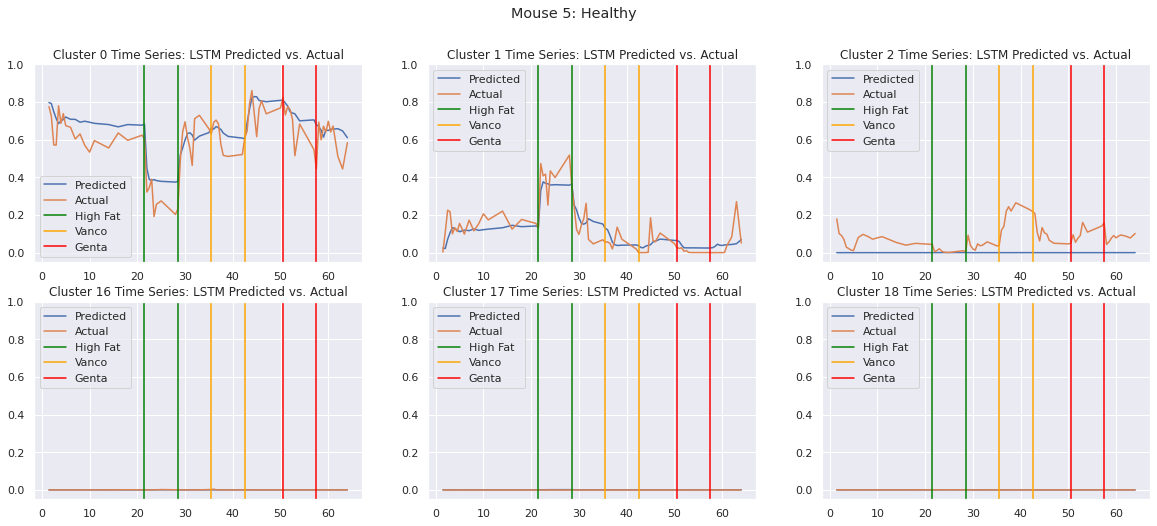

In [ ]:
# Setting seaborn
sns.set()

# Initializing the cluster name list
names = [0,1, 2, 16 ,17, 18]

# Creating lists containing the time steps
x = mouse5_actual['time'].unique()

### Plotting
fig, axes = plt.subplots(2,3, figsize=(20,8))

for ax, i, name in zip(axes.flatten(), range(6), names):
  
  ax.plot(x, mouse5_predictions_list_lstm[i], label = 'Predicted')
  ax.plot(x, mouse5_actual_list[i], label = 'Actual')
  ax.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax.axvline(x=28.5, color = 'green')
  ax.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax.axvline(x=42.5, color = 'orange')
  ax.axvline(x=50.5, color = 'red', label = 'Genta')
  ax.axvline(x=57.5, color = 'red')
  ax.set_ylim([-0.05,1])
  ax.set_title(f"Cluster {name} Time Series: LSTM Predicted vs. Actual")
  ax.legend()

plt.suptitle('Mouse 5: Healthy')

Text(0.5, 0.98, 'Mouse 9: Ulcerative Colitis')

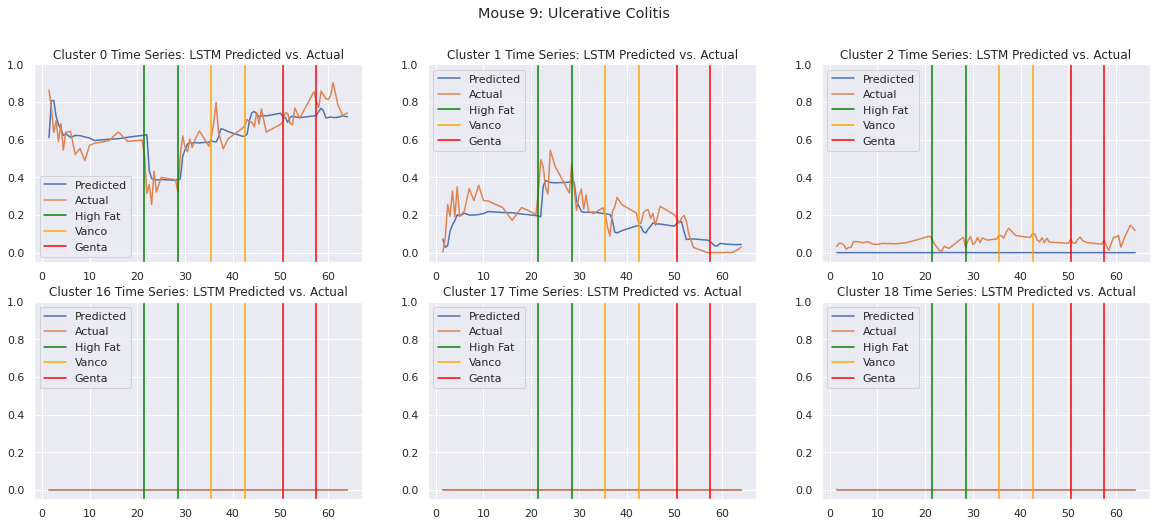

In [ ]:
# Setting seaborn
sns.set()

### Plotting
fig, axes = plt.subplots(2,3, figsize=(20,8))

for ax, i, name in zip(axes.flatten(), range(6), names):

  ax.plot(x, mouse9_predictions_list_lstm[i], label = 'Predicted')
  ax.plot(x, mouse9_actual_list[i], label = 'Actual')
  ax.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax.axvline(x=28.5, color = 'green')
  ax.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax.axvline(x=42.5, color = 'orange')
  ax.axvline(x=50.5, color = 'red', label = 'Genta')
  ax.axvline(x=57.5, color = 'red')
  ax.set_ylim([-.05,1])
  ax.set_title(f"Cluster {name} Time Series: LSTM Predicted vs. Actual")
  ax.legend()

plt.suptitle('Mouse 9: Ulcerative Colitis')


Text(0.5, 0.98, 'Mouse 10: Ulcerative Colitis')

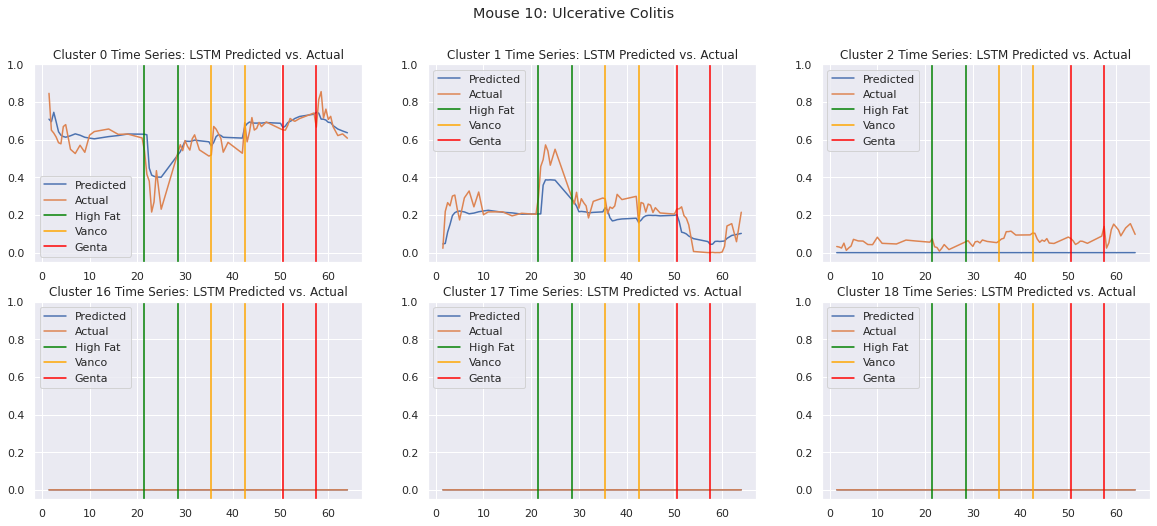

In [ ]:
# Setting seaborn
sns.set()

# Finding the time steps for Mouse 10 as two time steps are not included in the actual dataset
x = mouse10_actual['time'].unique()

### Plotting
fig, axes = plt.subplots(2,3, figsize=(20,8))

for ax, i, name in zip(axes.flatten(), range(6), names):

  ax.plot(x, mouse10_predictions_list_lstm[i], label = 'Predicted')
  ax.plot(x, mouse10_actual_list[i], label = 'Actual')
  ax.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax.axvline(x=28.5, color = 'green')
  ax.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax.axvline(x=42.5, color = 'orange')
  ax.axvline(x=50.5, color = 'red', label = 'Genta')
  ax.axvline(x=57.5, color = 'red')
  ax.set_ylim([-.05,1])
  ax.set_title(f"Cluster {name} Time Series: LSTM Predicted vs. Actual")
  ax.legend()

plt.suptitle('Mouse 10: Ulcerative Colitis')

Foe each of the mice, the LSTM model follows the time series trend closely for Cluster 0 and Cluster 1, however, we can see for cluster 2 that the LSTM predicted virtually 0% for the cluster's relative read proportion. This occurs even though Cluster 2 has, albeit small, non-zero proportions. 

With regard to clusters 16, 17, and 18, we can see that these actual clusters a close to 0 for the entire clinical trial, and our model predicts this correctly. 

Overall, we can see that the model performs similarly for the different mice. Moreover, the models seem to perform well for clusters that have consistently relatively high proportions and for clusters that have no close to no representation. However, the model does not perform well for clusters that consists of a small but non-zero proportions such as cluster 2. 

With regard to the predictions of the steady state after each of the perturbations, we see that, focusing on the first two clusters, the cluster 0 is negatively impacted by the high fat diet but bounces back in the post-steady state. The inverse holds true for cluster 1. After the Vancomycin perturbation, we can see that cluster 0's numbers are boosted while cluster 1's numbers are impacted. Finally, effects of the Gentamicin are less clear, but it seems as if, cluster 0's proportions drop as cluster 1 increases. 

Overall, we see that the cluster 0 is increasing after the high fat perturbation while cluster decreases of this perturbation.

Ultimately, we can see the negative correlation between cluster 0 and cluster 1. Indeed, cluster 0 increases, cluster 1 decreases and vice versa. 


##### Predictions for a Healthy Mouse vs. an Ulcerative Colitis Mouse

For this analysis, we analyze the predictions for Mouse 5 (Healthy) and Mouse 9 (Ulcerative Colitis)

Text(0.5, 0.98, 'Healthy (Mouse 5) vs. Ulcerative Colitis (Mouse 9) [Predicted Values]')

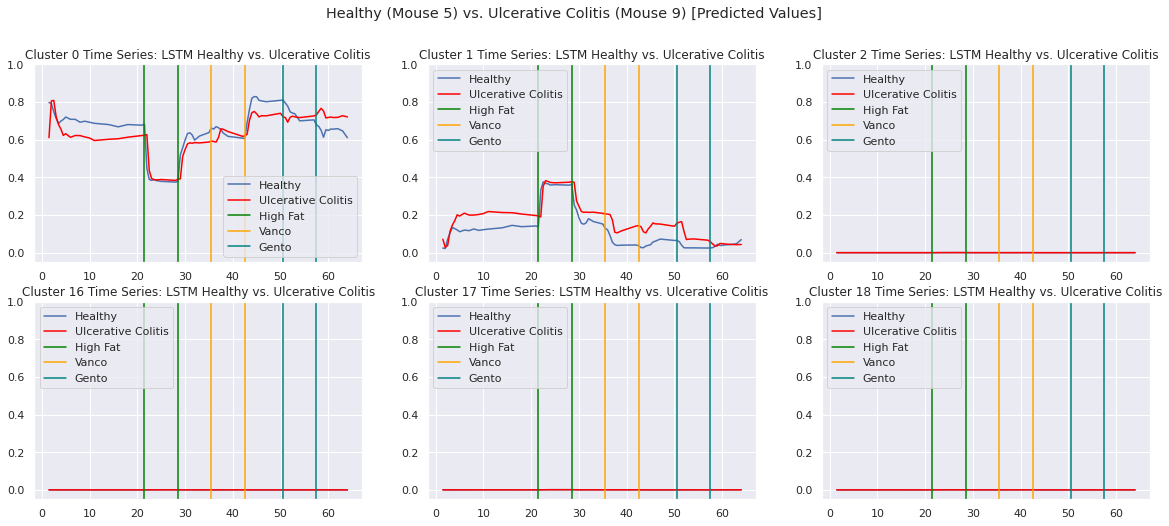

In [ ]:
# Healthy vs. Unhealthy Predictions

# Redefining the x list with the full time steps
x = mouse5_actual['time'].unique()

### Plotting
fig, axes = plt.subplots(2,3, figsize=(20,8))

for ax, i, name in zip(axes.flatten(), range(6), names):

  ax.plot(x, mouse5_predictions_list_lstm[i], label = 'Healthy')
  ax.plot(x, mouse9_predictions_list_lstm[i], color = 'red', label = 'Ulcerative Colitis')
  ax.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax.axvline(x=28.5, color = 'green')
  ax.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax.axvline(x=42.5, color = 'orange')
  ax.axvline(x=50.5, color = 'teal', label = 'Gento')
  ax.axvline(x=57.5, color = 'teal')
  ax.set_ylim([-.05,1])
  ax.set_title(f"Cluster {name} Time Series: LSTM Healthy vs. Ulcerative Colitis")
  ax.legend()

plt.suptitle('Healthy (Mouse 5) vs. Ulcerative Colitis (Mouse 9) [Predicted Values]')




Here, we look at how the model handles the predictions across health type. Unfortunately, there is not much interesting beyond the first two clusters, but when focusing solely on these clusters, there are some notable takeaways.

First, we can see that the model predicts that the mouse that was infused with faecal matter from patients who have Ulcerative Colitis tend to have less of cluster 0 and more of cluster 1 in the high fat and Vancomycin steady state regions than those mice that were infused with faecal matter from healthy individuals. In contrast, the model predicts that discrepancy between healthy types converge in the steady state after Gentamicin. 

Moreover, the model predicts that 1. there is some degree of negative relationship between cluster 0 and cluster 1 and 2. the different mice's clusters follow similar trends but with different magnitudes. 

More specifically, the healthy mouse cluster 0 and cluster 1 proportions were much more affected by the high fat perturbation, looking at the magnitude shift during the perturbation. However, in both cases, the clusters seem to converge back to approximately their original proportions. In addition to this, we can see that vancomycin impacted its steady state for cluster 0 as cluster 0's proportions increase.  This increase is large for the healthy mouse than it is for the unhealthy mouse. 

Of course, the overall make up within each cluster may be different; hence, further investigation is warranted. 

Overall, we can see that there are some differences between healthy types with regard to how the perturbations impact the latent steady state, however the clusters from the different types follow a similar trend and the real difference is in the magnitude. 

For more robust results, more test subjects across the different healthy types are needed. 

#### RMSE Analysis 

In [ ]:
### Finding the RMSE for each cluster for each mouse 

# Getting predictions for Mouse 10 and deleting the extra predictions
preds_lstm_10 = [mouse10_pred_lstm[:,i] for i in range(32)]
preds_lstm_10 = [np.delete(preds_lstm_10[i], [25,26]) for i in range(32)]

# Finding the rmse for each mouse
rmse_list_lstm_5 = [mean_squared_error(mouse5_actual[mouse5_actual['Cluster'] == i]['abund_prop'], mouse5_pred_lstm[:,i], squared=False) for i in range(32)]
rmse_list_lstm_9 = [mean_squared_error(mouse9_actual[mouse9_actual['Cluster'] == i]['abund_prop'], mouse9_pred_lstm[:,i], squared=False) for i in range(32)]
rmse_list_lstm_10 = [mean_squared_error(mouse10_actual[mouse10_actual['Cluster'] == i]['abund_prop'], preds_lstm_10[i], squared=False) for i in range(32)]

# Rounding
rmse_list_lstm_5 = [round(x,4) for x in rmse_list_lstm_5]
rmse_list_lstm_9 = [round(x,4) for x in rmse_list_lstm_9]
rmse_list_lstm_10 = [round(x,4) for x in rmse_list_lstm_10]

# Creating table
rmse_table_lstm = pd.DataFrame({'Cluster':range(32), 'LSTM_Mouse5(Healthy) rmse': rmse_list_lstm_5, 'LSTM_Mouse9(UC) rmse': rmse_list_lstm_9, 'LSTM_Mouse10(UC) rmse': rmse_list_lstm_10})
rmse_table_lstm

,Cluster,LSTM_Mouse5(Healthy) rmse,LSTM_Mouse9(UC) rmse,LSTM_Mouse10(UC) rmse
0,0,0.0975,0.0865,0.0673
1,1,0.0664,0.0891,0.0835
2,2,0.1031,0.0684,0.0745
3,3,0.0520,0.0073,0.0092
4,4,0.0976,0.0947,0.0909
5,5,0.0258,0.0075,0.0057
6,6,0.0475,0.0002,0.0035
7,7,0.0105,0.0025,0.0037
8,8,0.0080,0.0068,0.0061
9,9,0.0097,0.0007,0.0010


In this analysis, we compare the RMSEs of the model for each mouse and for each cluster for each mouse. The goal is to assess if the model is better at predicting for healthy or unhealthy mice. It is important to note that we do not have a large testing sample here, and hence this may not be a robust finding.

We find that there are some clusters that are indeed predicted better in one mouse over the others but there does not seem to be a consistent pattern. In fact, it seems as if the model performs relatively similar for each of the mice's clusters barring a few occasions. With more data, we believe that the model to perform similarly on average across health types. 

Further investigation should be conducted. 


### GRU 

In [ ]:
# Renaming to GRU friendly names ! 
train_x_gru = train_x_lstm
test_x_gru = test_x_lstm

In [ ]:
# Defining our GRU model
rec_input = Input((train_x_gru.shape[1], train_x_gru.shape[2]))
output = GRU(50, return_sequences=False)(rec_input)
output = Dense(32, activation='relu')(output)
output = Dropout(.2)(output)
output = Dense(32, activation = 'softmax')(output)

# Creating model
gru = Model(inputs=rec_input, outputs = output, name='Cluster_GRU')

# Compiling
gru.compile(loss='mse', optimizer='adam')

# Summary
gru.summary()

Model: "Cluster_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3, 49)]           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 50)                15150     
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1632      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
Total params: 17,838
Trainable params: 17,838
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Generating train generator and fitting the model
tf_generator = tf.data.Dataset.from_tensor_slices((train_x_gru, train_output)).batch(8)
history = gru.fit(tf_generator, epochs=50, shuffle=False)

Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.0123
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/50
55/55 [==============================] - 0s 4ms/step - loss: 9.8604e-04
Epoch 11/50
55/55 [==============================] - 0s 4ms/step - loss: 9.3924e-04
Epoch 12/50
55/55 [==============================] - 0s 4ms/step - loss: 8.6732e-04
Epoch 13/50
55/55 [==================

In [ ]:
train_loss = gru.evaluate(tf_generator)
print(f"The GRU train loss is {train_loss}")

55/55 [==============================] - 1s 2ms/step - loss: 3.7756e-04
The GRU train loss is 0.00037755549419671297


In [ ]:
# Creating test generator
tf_generator_test = tf.data.Dataset.from_tensor_slices((test_x_gru, test_output)).batch(8)
test_loss = gru.evaluate(tf_generator_test)
print(f"The GRU test loss is {test_loss}")

28/28 [==============================] - 0s 1ms/step - loss: 5.6183e-04
The GRU test loss is 0.0005618302966468036


#### Time Series Analysis
##### Time Series: Predicted vs. Actual

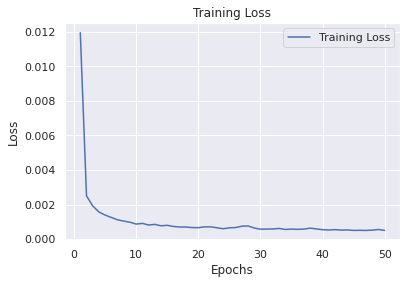

In [ ]:
### Plotting validation loss
import seaborn as sns

# Setting seaborn for plot
sns.set()

# Subsetting training and validation loss
train_loss = history.history['loss']

### Plotting
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label = 'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training Loss")
plt.legend()

In [ ]:
# Predicting on the test mice
predictions_gru = gru.predict(test_x_lstm)

print(f"The shape of the predictions is {predictions_gru.shape}")

The shape of the predictions is (219, 32)


In [ ]:
# Getting predictions for each mouse  
mouse5_pred_gru = np.array([predictions_gru[x] for x in range(0,73)])
mouse9_pred_gru = np.array([predictions_gru[x] for x in range(73,146)])
mouse10_pred_gru = np.array([predictions_gru[x] for x in range(146,219)])

In [ ]:
# Selecting first 3 clusters and middle three for analysis
selected_clusters = [0,1,2,16,17,18]

### Generating lists of the predictions and actual cluster proportions for each mouse 

# Mouse 5
mouse5_predictions_list_gru = [mouse5_pred_gru[:,i] for i in selected_clusters]

# Mouse 9
mouse9_predictions_list_gru = [mouse9_pred_gru[:,i] for i in selected_clusters]

# Mouse 10
mouse10_predictions_list_gru = [mouse10_pred_gru[:,i] for i in selected_clusters]

# For Mouse 10, dropping the predictions for the time steps that were not present in the actual data
mouse10_predictions_list_gru = [np.delete(mouse10_predictions_list_gru[i], [25,26]) for i in range(len(selected_clusters))]

Text(0.5, 0.98, 'Mouse 5: Healthy')

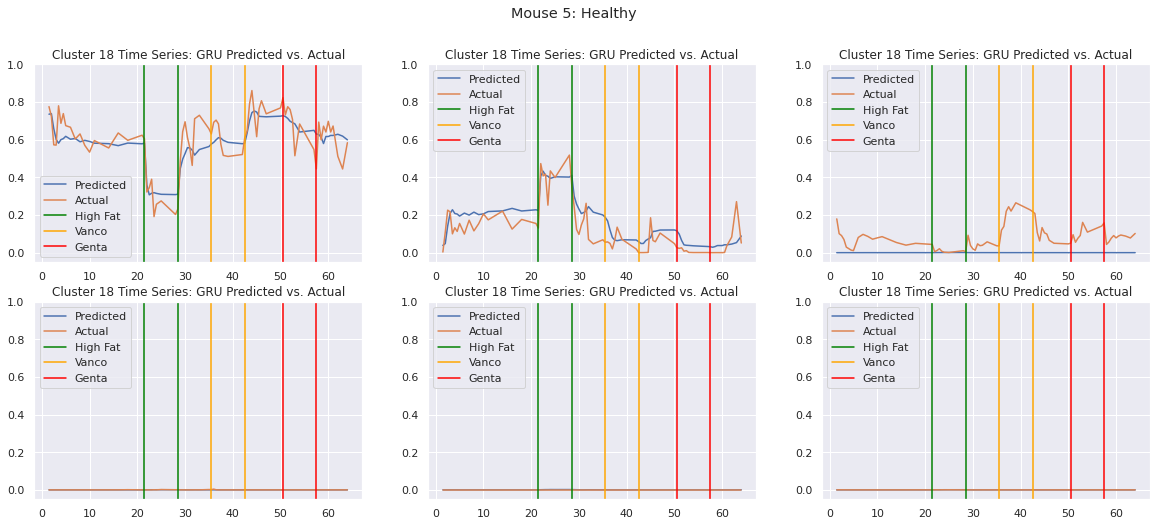

In [ ]:
# Setting seaborn
sns.set()

# Intializing the cluster name list
x = mouse5_actual['time'].unique()

### Plotting
fig, axes = plt.subplots(2,3, figsize=(20,8))

for ax, i in zip(axes.flatten(), range(6)):
  
  ax.plot(x, mouse5_predictions_list_gru[i], label = 'Predicted')
  ax.plot(x, mouse5_actual_list[i], label = 'Actual')
  ax.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax.axvline(x=28.5, color = 'green')
  ax.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax.axvline(x=42.5, color = 'orange')
  ax.axvline(x=50.5, color = 'red', label = 'Genta')
  ax.axvline(x=57.5, color = 'red')
  ax.set_ylim([-0.05,1])
  ax.set_title(f"Cluster {name} Time Series: GRU Predicted vs. Actual")
  ax.legend()

plt.suptitle('Mouse 5: Healthy')

Text(0.5, 0.98, 'Mouse 9: Ulcerative Colitis')

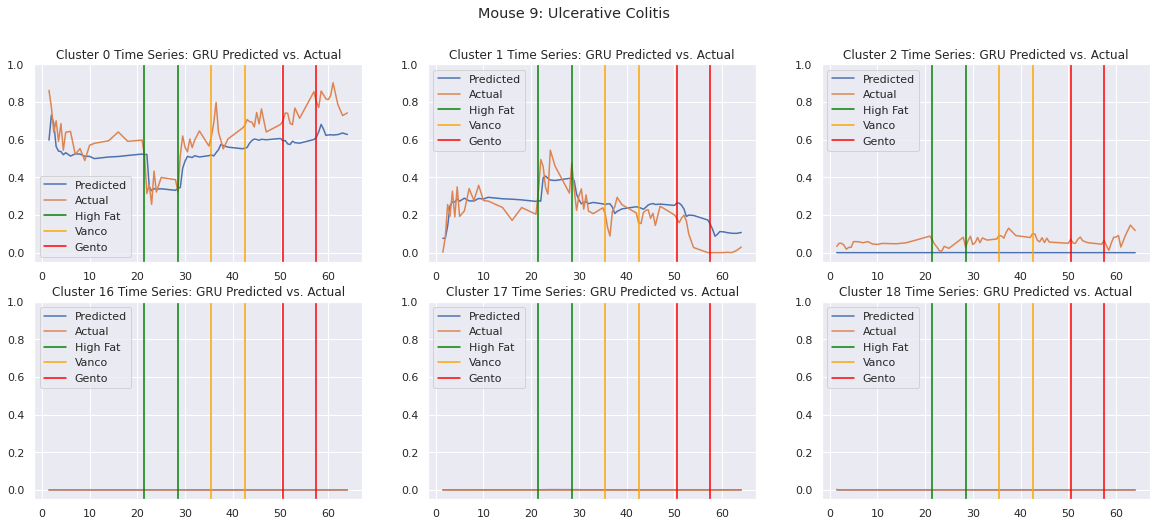

In [ ]:
# Setting seaborn
sns.set()

### Plotting
fig, axes = plt.subplots(2,3, figsize=(20,8))

for ax, i, name in zip(axes.flatten(), range(6), names):

  ax.plot(x, mouse9_predictions_list_gru[i], label = 'Predicted')
  ax.plot(x, mouse9_actual_list[i], label = 'Actual')
  ax.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax.axvline(x=28.5, color = 'green')
  ax.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax.axvline(x=42.5, color = 'orange')
  ax.axvline(x=50.5, color = 'red', label = 'Gento')
  ax.axvline(x=57.5, color = 'red')
  ax.set_ylim([-.05,1])
  ax.set_title(f"Cluster {name} Time Series: GRU Predicted vs. Actual")
  ax.legend()

plt.suptitle('Mouse 9: Ulcerative Colitis')


Text(0.5, 0.98, 'Mouse 10: Ulcerative Colitis')

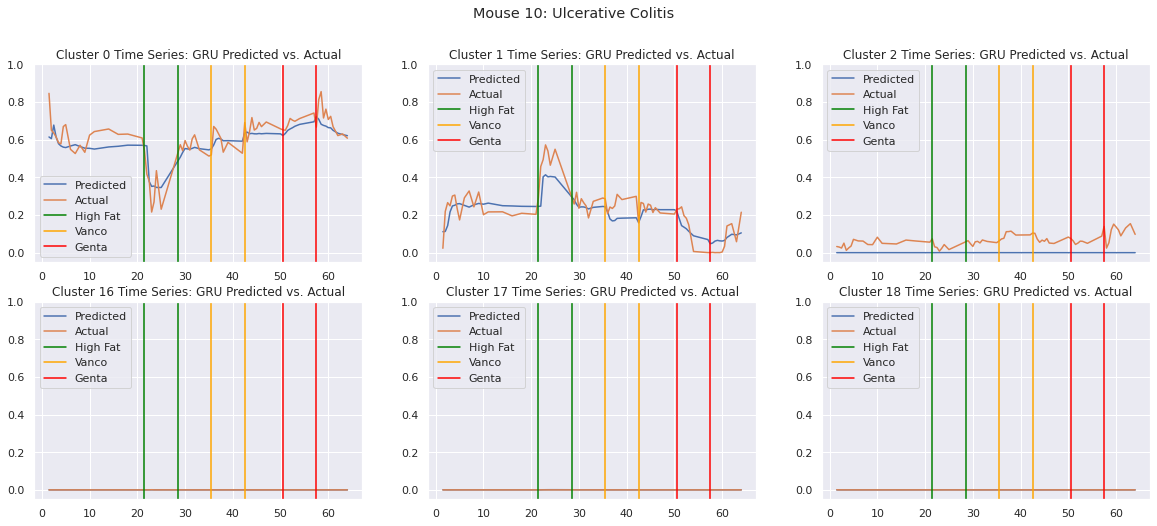

In [ ]:
# Setting seaborn
sns.set()

# Finding the time steps for Mouse 10 as two time steps are not included in the actual dataset
x = mouse10_actual['time'].unique()

### Plotting
fig, axes = plt.subplots(2,3, figsize=(20,8))

for ax, i, name in zip(axes.flatten(), range(6), names):

  ax.plot(x, mouse10_predictions_list_gru[i], label = 'Predicted')
  ax.plot(x, mouse10_actual_list[i], label = 'Actual')
  ax.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax.axvline(x=28.5, color = 'green')
  ax.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax.axvline(x=42.5, color = 'orange')
  ax.axvline(x=50.5, color = 'red', label = 'Genta')
  ax.axvline(x=57.5, color = 'red')
  ax.set_ylim([-.05,1])
  ax.set_title(f"Cluster {name} Time Series: GRU Predicted vs. Actual")
  ax.legend()

plt.suptitle('Mouse 10: Ulcerative Colitis')

Similar to the LSTM models, visually the GRU also follows the actual relative proportions for Cluster 0 and 1 well, including the latent steady state periods in between perturbations. However, for clusters with low relative read proportions but not zero, the GRU model incorrectly predicts a proportion of 0 for each time period, even though there is a small proportion still detected.

Moreover, similar to the LSTM, the GRU has similar takeaways. The GRU seems to perform similarly for each of the test mice. As a repeat of what is already stated, the model seems to perform well for clusters that have a high representation, not well for clusters that have some representation, and well, in that it predicts a proportion 0 for all time steps, for clusters that have virtually no representation. 

Furthermore, we can see there is some degree of relationship between cluster 0 and cluster 1, potentially as they compete for resources. 

With regard to the predictions of the steady state after each of the perturbations, we see that, focusing on the first two clusters, the cluster 0 is negatively impacted by the high fat diet but bounces back in the post-steady state. The inverse holds true for cluster 1. More generally, the perturbations seem to affect the clusters inversely. 

Overall, we see that cluster 1 tends to increase throughout the study while cluster 1 seems to decrease.


##### Predictions for a Healthy Mouse vs. an Ulcerative Colitis Mouse

Text(0.5, 0.98, 'Healthy (Mouse 5) vs. Ulcerative Colitis (Mouse 9)')

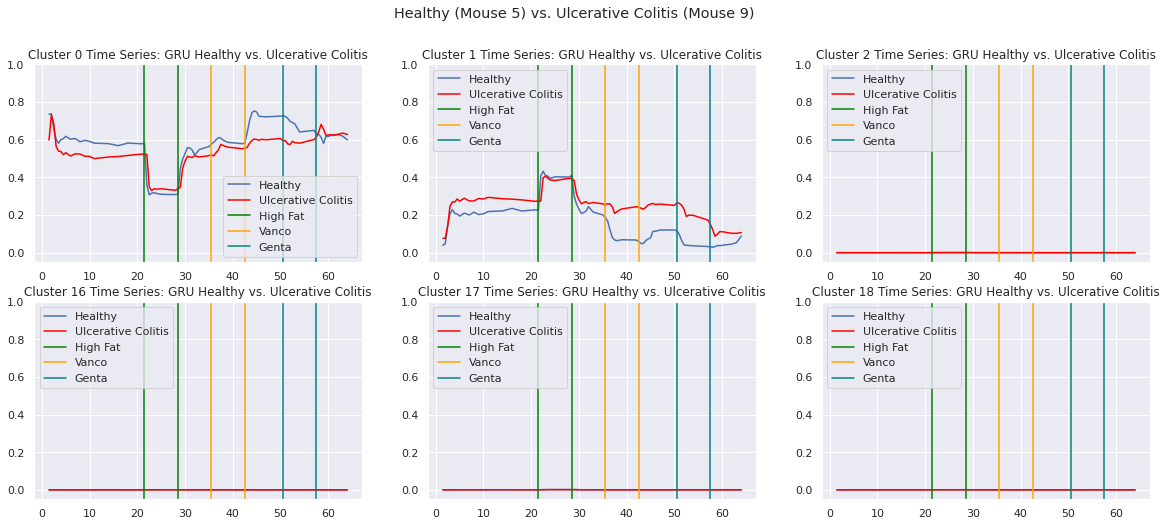

In [ ]:
# Healthy vs. Unhealthy Predictions

# Redefining the x list with the full time steps
x = mouse5_actual['time'].unique()

### Plotting
fig, axes = plt.subplots(2,3, figsize=(20,8))

for ax, i, name in zip(axes.flatten(), range(6), names):

  ax.plot(x, mouse5_predictions_list_gru[i], label = 'Healthy')
  ax.plot(x, mouse9_predictions_list_gru[i], color = 'red', label = 'Ulcerative Colitis')
  ax.axvline(x=21.5, color = 'green', label = 'High Fat')
  ax.axvline(x=28.5, color = 'green')
  ax.axvline(x=35.5, color = 'orange', label = 'Vanco' )
  ax.axvline(x=42.5, color = 'orange')
  ax.axvline(x=50.5, color = 'teal', label = 'Genta')
  ax.axvline(x=57.5, color = 'teal')
  ax.set_ylim([-.05,1])
  ax.set_title(f"Cluster {name} Time Series: GRU Healthy vs. Ulcerative Colitis")
  ax.legend()

plt.suptitle('Healthy (Mouse 5) vs. Ulcerative Colitis (Mouse 9)')

Now looking at the predictions for Mouse 5, the healthy mouse, and Mouse 9, the unhealthy mouse. 

Again, as it was with the LSTM, unfortunately, there is not much interesting beyond the first two clusters. However, when focusing solely on these two clusters, there are some notable findings.

First, we can see that the model predicts that the mouse that was infused with faecal matter from patients who have Ulcerative Colitis tend to have less of cluster 0 in the high fat, Vancomycin, and Gentamicin steady regions than those mice that were infused with faecal matter from healthy individuals. This is slightly different to the LSTM predictions. 

For cluster 1, again in contrast to the LSTMs predictions, we can see that healthy mice tend to have a lower proportion across the time steps. However, the difference is marginal at certain time steps. 

Hence, this model seems to indicate that a healthy mouse seems to have a slightly more diverse microbiome.

With that though, the model continues to predict that there is some degree of negative relationship between cluster 0 and cluster 1. 

The largest discrepancy seems to happen during the Vancomycin steady state for both clusters. It seems that the healthy mice's cluster proportions seem to increase in this steady state where the clusters in for the ulcerative colitis mouse either change slightly or remain unchanged. 

Finally, we can see that post Gentamicin, the healthy mouse's cluster 0 decreases while the ulcerative colitis mouse increase. For Cluster 1, the healthy mice's proportion increases slightly while the unhealthy mouse's proportions remain relatively unaffected. 

Overall, we can see that there are some differences between healthy types with regard to how the perturbations impact the latent steady state. 



#### RSME Analysis

In [ ]:
### Finding the RMSE for each cluster for each mouse 

# Getting predictions for Mouse 10 and deleting the extra predictions
preds_gru_10 = [mouse10_pred_gru[:,i] for i in range(32)]
preds_gru_10 = [np.delete(preds_gru_10[i], [25,26]) for i in range(32)]

# Finding the rmse for each mouse
rmse_list_gru_5 = [mean_squared_error(mouse5_actual[mouse5_actual['Cluster'] == i]['abund_prop'], mouse5_pred_gru[:,i], squared=False) for i in range(32)]
rmse_list_gru_9 = [mean_squared_error(mouse9_actual[mouse9_actual['Cluster'] == i]['abund_prop'], mouse9_pred_gru[:,i], squared=False) for i in range(32)]
rmse_list_gru_10 = [mean_squared_error(mouse10_actual[mouse10_actual['Cluster'] == i]['abund_prop'], preds_gru_10[i], squared=False) for i in range(32)]

# Rounding
rmse_list_gru_5 = [round(x,4) for x in rmse_list_gru_5]
rmse_list_gru_9 = [round(x,4) for x in rmse_list_gru_9]
rmse_list_gru_10 = [round(x,4) for x in rmse_list_gru_10]

# Creating table
rmse_table_gru = pd.DataFrame({'Cluster':range(32), 'GRU_Mouse5(Healthy) rmse': rmse_list_gru_5, 'GRU_Mouse9(UC) rmse': rmse_list_gru_9, 'GRU_Mouse10(UC) rmse': rmse_list_gru_10 })
rmse_table_gru

,Cluster,GRU_Mouse5(Healthy) rmse,GRU_Mouse9(UC) rmse,GRU_Mouse10(UC) rmse
0,0,0.0860,0.1268,0.0672
1,1,0.0772,0.0849,0.0701
2,2,0.1032,0.0684,0.0745
3,3,0.0521,0.0074,0.0093
4,4,0.0977,0.0948,0.0910
5,5,0.0257,0.0074,0.0057
6,6,0.0475,0.0002,0.0035
7,7,0.0107,0.0026,0.0038
8,8,0.0081,0.0069,0.0062
9,9,0.0096,0.0007,0.0010


In this RMSE analysis, we compare the RMSEs of the model for each mouse and for each cluster with each mouse. The goal is to assess if the model is better at predicting for healthy or unhealthy mice. It is important to note that we do not have a large testing sample here, and hence this may not be a robust finding.

We find that the model seems to perform decently well for the unhealthy mice on average where it seems to have performed the best for mice 10. Of course, this is not true for every cluster, but it is true for a good number of clusters. 

However, as the sample test size is small, it has difficult to conclude anything substantial. 

Further investigation should be conducted. 

# Comparing all Models RMSE

In [ ]:
#Convert Cluster columns to just numeric value (ie. Cluster_0 to 0) and then sort for all rmse dataframes for linear and lasso
rmse_df_linear["Cluster"] = rmse_df_linear["Cluster"].str.replace("Cluster_","").astype(int)
rmse_df_linear=rmse_df_linear.sort_values("Cluster").reset_index(drop=True)

rmse_df_linear_latent_steady_states["Cluster"] = rmse_df_linear_latent_steady_states["Cluster"].str.replace("Cluster_","").astype(int)
rmse_df_linear_latent_steady_states=rmse_df_linear_latent_steady_states.sort_values("Cluster").reset_index(drop=True)

rmse_df_linear_post_fat["Cluster"] = rmse_df_linear_post_fat["Cluster"].str.replace("Cluster_","").astype(int)
rmse_df_linear_post_fat= rmse_df_linear_post_fat.sort_values("Cluster").reset_index(drop=True)

rmse_df_linear_post_vanco["Cluster"] = rmse_df_linear_post_vanco["Cluster"].str.replace("Cluster_","").astype(int)
rmse_df_linear_post_vanco= rmse_df_linear_post_vanco.sort_values("Cluster").reset_index(drop=True)

rmse_df_linear_post_genta["Cluster"] = rmse_df_linear_post_genta["Cluster"].str.replace("Cluster_","").astype(int)
rmse_df_linear_post_genta= rmse_df_linear_post_genta.sort_values("Cluster").reset_index(drop=True)

In [ ]:
#Convert Cluster columns to just numeric value (ie. Cluster_0 to 0) and then sort for all rmse dataframes lasso
rmse_df_lasso["Cluster"] = rmse_df_lasso["Cluster"].str.replace("Cluster_","").astype(int)
rmse_df_lasso=rmse_df_lasso.sort_values("Cluster").reset_index(drop=True)

rmse_df_lasso_latent_steady_states["Cluster"]= rmse_df_lasso_latent_steady_states["Cluster"].str.replace("Cluster_","").astype(int)
rmse_df_lasso_latent_steady_states= rmse_df_lasso_latent_steady_states.sort_values("Cluster").reset_index(drop=True)

rmse_df_lasso_post_fat["Cluster"]= rmse_df_lasso_post_fat["Cluster"].str.replace("Cluster_","").astype(int)
rmse_df_lasso_post_fat= rmse_df_lasso_post_fat.sort_values("Cluster").reset_index(drop=True)


rmse_df_lasso_post_vanco["Cluster"]= rmse_df_lasso_post_vanco["Cluster"].str.replace("Cluster_","").astype(int)
rmse_df_lasso_post_vanco= rmse_df_lasso_post_vanco.sort_values("Cluster").reset_index(drop=True)


rmse_df_lasso_post_genta["Cluster"]= rmse_df_lasso_post_genta["Cluster"].str.replace("Cluster_","").astype(int)
rmse_df_lasso_post_genta= rmse_df_lasso_post_genta.sort_values("Cluster").reset_index(drop=True)

In [ ]:
#Function calculates RMSE for only latent steady state period (all periods)
def rmse_all_latent_steady_states(prediction, actual):
  prediction_df = pd.DataFrame(prediction).T
  prediction_df["time"] = actual['time'].unique()
  latent_periods_prediction_df = prediction_df.loc[((prediction_df.time >=28.5) & (prediction_df.time <=35.4)) |
                                                                              ((prediction_df.time >=42.5) & (prediction_df.time <=50.4)) |
                                                                              ((prediction_df.time >=57.5))]
  mouse_actual = [actual[actual['Cluster'] == i]['abund_prop'] for i in range(32)]
  actual_df = pd.DataFrame(np.array(mouse_actual)).T 
  actual_df["time"] = actual['time'].unique()
  latent_periods_actual_df = actual_df.loc[((actual_df.time >=28.5) & (actual_df.time <=35.4)) |
                                                                              ((actual_df.time >=42.5) & (actual_df.time <=50.4)) |
                                                                              ((actual_df.time >=57.5))]

  latent_period_rmse = np.sqrt(np.square((latent_periods_prediction_df-latent_periods_actual_df).drop("time",axis=1)).mean(axis=0))
  return latent_period_rmse

In [ ]:
#Function calculates RMSE for only latent steady state period after fat perturbation and before vancomycin perturbation
def rmse_all_latent_steady_state_fat(prediction, actual):
  prediction_df = pd.DataFrame(prediction).T
  prediction_df["time"] = actual['time'].unique()
  latent_periods_prediction_df = prediction_df.loc[((prediction_df.time >=28.5) & (prediction_df.time <=35.4))]
  mouse_actual = [actual[actual['Cluster'] == i]['abund_prop'] for i in range(32)]
  actual_df = pd.DataFrame(np.array(mouse_actual)).T 
  actual_df["time"] = actual['time'].unique()
  latent_periods_actual_df = actual_df.loc[((actual_df.time >=28.5) & (actual_df.time <=35.4))]

  latent_period_rmse = np.sqrt(np.square((latent_periods_prediction_df-latent_periods_actual_df).drop("time",axis=1)).mean(axis=0))
  return latent_period_rmse

In [ ]:
#Function calculates RMSE for only latent steady state period after vancomycin perturbation and before gentamicin perturbation
def rmse_all_latent_steady_state_vanco(prediction, actual):
  prediction_df = pd.DataFrame(prediction).T
  prediction_df["time"] = actual['time'].unique()
  latent_periods_prediction_df = prediction_df.loc[((prediction_df.time >=42.5) & (prediction_df.time <=50.4))]
  mouse_actual = [actual[actual['Cluster'] == i]['abund_prop'] for i in range(32)]
  actual_df = pd.DataFrame(np.array(mouse_actual)).T 
  actual_df["time"] = actual['time'].unique()
  latent_periods_actual_df = actual_df.loc[((actual_df.time >=42.5) & (actual_df.time <=50.4))]
  latent_period_rmse = np.sqrt(np.square((latent_periods_prediction_df-latent_periods_actual_df).drop("time",axis=1)).mean(axis=0))
  return latent_period_rmse

In [ ]:
#Function calculates RMSE for only latent steady state period after gentamicin perturbation
def rmse_all_latent_steady_state_gent(prediction, actual):
  prediction_df = pd.DataFrame(prediction).T
  prediction_df["time"] = actual['time'].unique()
  latent_periods_prediction_df = prediction_df.loc[((prediction_df.time >=57.5))]
  mouse_actual = [actual[actual['Cluster'] == i]['abund_prop'] for i in range(32)]
  actual_df = pd.DataFrame(np.array(mouse_actual)).T 
  actual_df["time"] = actual['time'].unique()
  latent_periods_actual_df = actual_df.loc[((actual_df.time >=57.5))]
  latent_period_rmse = np.sqrt(np.square((latent_periods_prediction_df-latent_periods_actual_df).drop("time",axis=1)).mean(axis=0))
  return latent_period_rmse

In [ ]:
#calculate latent steady state rmse for gru and lstm
rmse_latent_10_gru = rmse_all_latent_steady_states(preds_gru_10,mouse10_actual)
rmse_latent_5_gru = rmse_all_latent_steady_states(pd.DataFrame(mouse5_pred_gru).T,mouse5_actual)
rmse_latent_9_gru = rmse_all_latent_steady_states(pd.DataFrame(mouse9_pred_gru).T,mouse9_actual)

rmse_latent_10_lstm = rmse_all_latent_steady_states(preds_lstm_10,mouse10_actual)
rmse_latent_5_lstm = rmse_all_latent_steady_states(pd.DataFrame(mouse5_pred_lstm).T,mouse5_actual)
rmse_latent_9_lstm = rmse_all_latent_steady_states(pd.DataFrame(mouse9_pred_lstm).T,mouse9_actual)

In [ ]:
#calculate latent steady state post fat rmse for gru and lstm
rmse_latent_10_gru_fat = rmse_all_latent_steady_state_fat(preds_gru_10,mouse10_actual)
rmse_latent_5_gru_fat = rmse_all_latent_steady_state_fat(pd.DataFrame(mouse5_pred_gru).T,mouse5_actual)
rmse_latent_9_gru_fat = rmse_all_latent_steady_state_fat(pd.DataFrame(mouse9_pred_gru).T,mouse9_actual)

rmse_latent_10_lstm_fat = rmse_all_latent_steady_state_fat(preds_lstm_10,mouse10_actual)
rmse_latent_5_lstm_fat = rmse_all_latent_steady_state_fat(pd.DataFrame(mouse5_pred_lstm).T,mouse5_actual)
rmse_latent_9_lstm_fat = rmse_all_latent_steady_state_fat(pd.DataFrame(mouse9_pred_lstm).T,mouse9_actual)

In [ ]:
#calculate latent steady state post vancomycin rmse for gru and lstm
rmse_latent_10_gru_vanco = rmse_all_latent_steady_state_vanco(preds_gru_10,mouse10_actual)
rmse_latent_5_gru_vanco = rmse_all_latent_steady_state_vanco(pd.DataFrame(mouse5_pred_gru).T,mouse5_actual)
rmse_latent_9_gru_vanco = rmse_all_latent_steady_state_vanco(pd.DataFrame(mouse9_pred_gru).T,mouse9_actual)

rmse_latent_10_lstm_vanco = rmse_all_latent_steady_state_vanco(preds_lstm_10,mouse10_actual)
rmse_latent_5_lstm_vanco = rmse_all_latent_steady_state_vanco(pd.DataFrame(mouse5_pred_lstm).T,mouse5_actual)
rmse_latent_9_lstm_vanco = rmse_all_latent_steady_state_vanco(pd.DataFrame(mouse9_pred_lstm).T,mouse9_actual)

In [ ]:
#calculate latent steady state post gentamicin rmse for gru and lstm
rmse_latent_10_gru_gent = rmse_all_latent_steady_state_gent(preds_gru_10,mouse10_actual)
rmse_latent_5_gru_gent = rmse_all_latent_steady_state_gent(pd.DataFrame(mouse5_pred_gru).T,mouse5_actual)
rmse_latent_9_gru_gent = rmse_all_latent_steady_state_gent(pd.DataFrame(mouse9_pred_gru).T,mouse9_actual)

rmse_latent_10_lstm_gent = rmse_all_latent_steady_state_gent(preds_lstm_10,mouse10_actual)
rmse_latent_5_lstm_gent = rmse_all_latent_steady_state_gent(pd.DataFrame(mouse5_pred_lstm).T,mouse5_actual)
rmse_latent_9_lstm_gent = rmse_all_latent_steady_state_gent(pd.DataFrame(mouse9_pred_lstm).T,mouse9_actual)

In [ ]:
print("Mouse 5: Healthy for all periods")
rmse_table5 = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear["LM_Mouse5(Healthy) rmse"]),
                           "Lasso":np.array(rmse_df_lasso['LASSO_Mouse5(Healthy) rmse']),
                           "GRU": np.array(rmse_table_gru['GRU_Mouse5(Healthy) rmse']),
                           "LSTM": np.array(rmse_table_lstm['LSTM_Mouse5(Healthy) rmse'])})
print("Average RMSE across Cluster:");
print(rmse_table5[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table5.head()

Mouse 5: Healthy for all periods
Average RMSE across Cluster:
Linear Model    0.030119
Lasso           0.013931
GRU             0.025712
LSTM            0.024559
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.1853,0.1326,0.0860,0.0975
1,1,0.0868,0.0892,0.0772,0.0664
2,2,0.0545,0.0500,0.1032,0.1031
3,3,0.0632,0.0294,0.0521,0.0520
4,4,0.0565,0.0482,0.0977,0.0976


In [ ]:
print("Mouse 5: Healthy for all latent steady state periods")
rmse_table5_steady_states = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_latent_steady_states["LM_Mouse5(Healthy) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_latent_steady_states['LASSO_Mouse5(Healthy) rmse']),
                           "GRU": np.array(rmse_latent_5_gru),
                           "LSTM": np.array(rmse_latent_5_lstm)})
print("Average RMSE across Cluster:");
print(rmse_table5_steady_states[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table5_steady_states.head()

Mouse 5: Healthy for all latent steady state periods
Average RMSE across Cluster:
Linear Model    0.034647
Lasso           0.012784
GRU             0.026473
LSTM            0.024792
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.2406,0.1196,0.098238,0.096819
1,1,0.0880,0.0744,0.084906,0.069929
2,2,0.0564,0.0448,0.092573,0.092535
3,3,0.0832,0.0356,0.060457,0.060341
4,4,0.0518,0.0464,0.096196,0.096140


In [ ]:
print("Mouse 5: Healthy for post-fat and pre-vancomycin periods")
rmse_table5_fat = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_post_fat["LM_Mouse5(Healthy) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_post_fat['LASSO_Mouse5(Healthy) rmse']),
                           "GRU": np.array(rmse_latent_5_gru_fat),
                           "LSTM": np.array(rmse_latent_5_lstm_fat)})
print("Average RMSE across Cluster:");
print(rmse_table5_fat[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table5_fat.head()

Mouse 5: Healthy for post-fat and pre-vancomycin periods
Average RMSE across Cluster:
Linear Model    0.014584
Lasso           0.012366
GRU             0.024466
LSTM            0.021855
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.1399,0.1246,0.121033,0.098762
1,1,0.1097,0.0789,0.111875,0.079720
2,2,0.0340,0.0335,0.045037,0.045085
3,3,0.0308,0.0260,0.046772,0.046761
4,4,0.0647,0.0656,0.139294,0.139265


In [ ]:
print("Mouse 5: Healthy for post-vancomycin and pre-gentamicin periods")
rmse_table5_vanco = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_post_vanco["LM_Mouse5(Healthy) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_post_vanco['LASSO_Mouse5(Healthy) rmse']),
                           "GRU": np.array(rmse_latent_5_gru_vanco),
                           "LSTM": np.array(rmse_latent_5_lstm_vanco)})
print("Average RMSE across Cluster:");
print(rmse_table5_vanco[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table5_vanco.head()

Mouse 5: Healthy for post-vancomycin and pre-gentamicin periods
Average RMSE across Cluster:
Linear Model    0.029862
Lasso           0.009819
GRU             0.018942
LSTM            0.017977
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.3036,0.1054,0.071347,0.080760
1,1,0.0643,0.0642,0.062790,0.052157
2,2,0.0749,0.0626,0.124123,0.124096
3,3,0.1360,0.0334,0.064294,0.064205
4,4,0.0034,0.0081,0.007300,0.007299


In [ ]:
print("Mouse 5: Healthy for post-gentamicin period")
rmse_table5_gent = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_post_genta["LM_Mouse5(Healthy) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_post_genta['LASSO_Mouse5(Healthy) rmse']),
                           "GRU": np.array(rmse_latent_5_gru_gent),
                           "LSTM": np.array(rmse_latent_5_lstm_gent)})
print("Average RMSE across Cluster:");
print(rmse_table5_gent[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table5_gent.head()

Mouse 5: Healthy for post-gentamicin period
Average RMSE across Cluster:
Linear Model    0.039347
Lasso           0.013597
GRU             0.028431
LSTM            0.027727
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.2475,0.1264,0.096190,0.107801
1,1,0.0845,0.0782,0.073170,0.074367
2,2,0.0534,0.0340,0.091112,0.091015
3,3,0.0476,0.0435,0.067482,0.067274
4,4,0.0605,0.0459,0.091604,0.091478


In [ ]:
print("Mouse 9: Ulcerative Colitis for all periods")
rmse_table9 = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear["LM_Mouse9(UC) rmse"]),
                           "Lasso":np.array(rmse_df_lasso['LASSO_Mouse9(UC) rmse']),
                           "GRU": np.array(rmse_table_gru['GRU_Mouse9(UC) rmse']),
                           "LSTM": np.array(rmse_table_lstm['LSTM_Mouse9(UC) rmse'])})

print("Average RMSE across Cluster:");
print(rmse_table9[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table9.head()

Mouse 9: Ulcerative Colitis for all periods
Average RMSE across Cluster:
Linear Model    0.010313
Lasso           0.010828
GRU             0.019978
LSTM            0.018062
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.1023,0.1152,0.1268,0.0865
1,1,0.1251,0.1255,0.0849,0.0891
2,2,0.0287,0.0276,0.0684,0.0684
3,3,0.0057,0.0059,0.0074,0.0073
4,4,0.0391,0.0494,0.0948,0.0947


In [ ]:
print("Mouse 9: Healthy for all latent steady state periods")
rmse_table9_steady_states = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_latent_steady_states["LM_Mouse9(UC) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_latent_steady_states['LASSO_Mouse9(UC) rmse']),
                           "GRU": np.array(rmse_latent_9_gru),
                           "LSTM": np.array(rmse_latent_9_lstm)})
print("Average RMSE across Cluster:");
print(rmse_table9_steady_states[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table9_steady_states.head()

Mouse 9: Healthy for all latent steady state periods
Average RMSE across Cluster:
Linear Model    0.009753
Lasso           0.010322
GRU             0.019768
LSTM            0.016294
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.0983,0.1096,0.137636,0.072796
1,1,0.1216,0.1217,0.079571,0.060186
2,2,0.0348,0.0315,0.073847,0.073828
3,3,0.0030,0.0052,0.007367,0.007308
4,4,0.0366,0.0499,0.084330,0.084281


In [ ]:
print("Mouse 9: Healthy for post-fat and pre-vancomycin periods")
rmse_table9_fat = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_post_fat["LM_Mouse9(UC) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_post_fat['LASSO_Mouse9(UC) rmse']),
                           "GRU": np.array(rmse_latent_9_gru_fat),
                           "LSTM": np.array(rmse_latent_9_lstm_fat)})
print("Average RMSE across Cluster:");
print(rmse_table9_fat[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table5_fat.head()

Mouse 9: Healthy for post-fat and pre-vancomycin periods
Average RMSE across Cluster:
Linear Model    0.013212
Lasso           0.014778
GRU             0.017720
LSTM            0.015724
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.1399,0.1246,0.121033,0.098762
1,1,0.1097,0.0789,0.111875,0.079720
2,2,0.0340,0.0335,0.045037,0.045085
3,3,0.0308,0.0260,0.046772,0.046761
4,4,0.0647,0.0656,0.139294,0.139265


In [ ]:
print("Mouse 9: Healthy for post-vancomycin and pre-gentamicin periods")
rmse_table9_vanco = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_post_vanco["LM_Mouse9(UC) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_post_vanco['LASSO_Mouse9(UC) rmse']),
                           "GRU": np.array(rmse_latent_9_gru_vanco),
                           "LSTM": np.array(rmse_latent_9_lstm_vanco)})
print("Average RMSE across Cluster:");
print(rmse_table9_vanco[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table9_vanco.head()

Mouse 9: Healthy for post-vancomycin and pre-gentamicin periods
Average RMSE across Cluster:
Linear Model    0.008363
Lasso           0.004900
GRU             0.014558
LSTM            0.013046
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.0886,0.0387,0.111685,0.056610
1,1,0.1136,0.0513,0.061748,0.072621
2,2,0.0271,0.0249,0.071731,0.071709
3,3,0.0048,0.0089,0.012035,0.011946
4,4,0.0182,0.0185,0.028064,0.028063


In [ ]:
print("Mouse 9: Healthy for post-gentamicin period")
rmse_table9_gent = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_post_genta["LM_Mouse9(UC) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_post_genta['LASSO_Mouse9(UC) rmse']),
                           "GRU": np.array(rmse_latent_9_gru_gent),
                           "LSTM": np.array(rmse_latent_9_lstm_gent)})
print("Average RMSE across Cluster:");
print(rmse_table9_gent[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table9_gent.head()

Mouse 9: Healthy for post-gentamicin period
Average RMSE across Cluster:
Linear Model    0.004731
Lasso           0.006294
GRU             0.023090
LSTM            0.017287
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.0511,0.0837,0.180155,0.091730
1,1,0.0149,0.0126,0.107670,0.042220
2,2,0.0392,0.0404,0.082691,0.082661
3,3,0.0021,0.0026,0.004608,0.004556
4,4,0.0247,0.0533,0.104749,0.104720


In [ ]:
print("Mouse 10: Ulcerative Colitis for all periods\n")
rmse_table10 = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear["LM_Mouse10(UC) rmse"]),
                           "Lasso":np.array(rmse_df_lasso['LASSO_Mouse10(UC) rmse']),
                           "GRU": np.array(rmse_table_gru['GRU_Mouse10(UC) rmse']),
                           "LSTM": np.array(rmse_table_lstm['LSTM_Mouse10(UC) rmse'])})

print("Average RMSE across Cluster:");
print(rmse_table10[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table10.head()

Mouse 10: Ulcerative Colitis for all periods

Average RMSE across Cluster:
Linear Model    0.010400
Lasso           0.011100
GRU             0.017450
LSTM            0.016934
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.0961,0.1168,0.0672,0.0673
1,1,0.1249,0.1348,0.0701,0.0835
2,2,0.0272,0.0292,0.0745,0.0745
3,3,0.0074,0.0080,0.0093,0.0092
4,4,0.0448,0.0434,0.0910,0.0909


In [ ]:
print("Mouse 10: Healthy for all latent steady state periods")
rmse_table10_steady_states = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_latent_steady_states["LM_Mouse10(UC) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_latent_steady_states['LASSO_Mouse10(UC) rmse']),
                           "GRU": np.array(rmse_latent_10_gru),
                           "LSTM": np.array(rmse_latent_10_lstm)})
print("Average RMSE across Cluster:");
print(rmse_table10_steady_states[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table10_steady_states.head()

Mouse 10: Healthy for all latent steady state periods
Average RMSE across Cluster:
Linear Model    0.009794
Lasso           0.010581
GRU             0.016512
LSTM            0.015723
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.1006,0.1100,0.057205,0.048384
1,1,0.1155,0.1284,0.045740,0.054049
2,2,0.0305,0.0351,0.088651,0.088610
3,3,0.0082,0.0063,0.008320,0.008280
4,4,0.0352,0.0412,0.092110,0.092055


In [ ]:
print("Mouse 10: Healthy for post-fat and pre-vancomycin periods")
rmse_table10_fat = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_post_fat["LM_Mouse10(UC) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_post_fat['LASSO_Mouse10(UC) rmse']),
                           "GRU": np.array(rmse_latent_10_gru_fat),
                           "LSTM": np.array(rmse_latent_10_lstm_fat)})
print("Average RMSE across Cluster:");
print(rmse_table10_fat[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table5_fat.head()

Mouse 10: Healthy for post-fat and pre-vancomycin periods
Average RMSE across Cluster:
Linear Model    0.010312
Lasso           0.013187
GRU             0.014219
LSTM            0.014055
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.1399,0.1246,0.121033,0.098762
1,1,0.1097,0.0789,0.111875,0.079720
2,2,0.0340,0.0335,0.045037,0.045085
3,3,0.0308,0.0260,0.046772,0.046761
4,4,0.0647,0.0656,0.139294,0.139265


In [ ]:
print("Mouse 10: Healthy for post-vancomycin and pre-gentamicin periods")
rmse_table10_vanco = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_post_vanco["LM_Mouse10(UC) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_post_vanco['LASSO_Mouse10(UC) rmse']),
                           "GRU": np.array(rmse_latent_10_gru_vanco),
                           "LSTM": np.array(rmse_latent_10_lstm_vanco)})
print("Average RMSE across Cluster:");
print(rmse_table10_vanco[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table10_vanco.head()

Mouse 10: Healthy for post-vancomycin and pre-gentamicin periods
Average RMSE across Cluster:
Linear Model    0.008800
Lasso           0.007719
GRU             0.010944
LSTM            0.010439
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.1038,0.0835,0.048476,0.040880
1,1,0.1166,0.1045,0.030396,0.048399
2,2,0.0257,0.0267,0.074330,0.074325
3,3,0.0139,0.0098,0.013032,0.013008
4,4,0.0095,0.0147,0.022208,0.022206


In [ ]:
print("Mouse 10: Healthy for post-gentamicin period")
rmse_table10_gent = pd.DataFrame({'Cluster':range(32), 
                            "Linear Model": np.array(rmse_df_linear_post_genta["LM_Mouse10(UC) rmse"]),
                           "Lasso":np.array(rmse_df_lasso_post_genta['LASSO_Mouse10(UC) rmse']),
                           "GRU": np.array(rmse_latent_10_gru_gent),
                           "LSTM": np.array(rmse_latent_10_lstm_gent)})
print("Average RMSE across Cluster:");
print(rmse_table10_gent[["Linear Model","Lasso","GRU","LSTM"]].mean(axis=0))
rmse_table10_gent.head()

Mouse 10: Healthy for post-gentamicin period
Average RMSE across Cluster:
Linear Model    0.008728
Lasso           0.008706
GRU             0.020243
LSTM            0.019024
dtype: float64


,Cluster,Linear Model,Lasso,GRU,LSTM
0,0,0.0873,0.0939,0.073892,0.060138
1,1,0.0825,0.0661,0.061170,0.061020
2,2,0.0396,0.0489,0.117750,0.117674
3,3,0.0036,0.0046,0.005862,0.005758
4,4,0.0375,0.0425,0.110265,0.110172


When evaluating the RMSE across all time periods, for just the latent steady states between perturbations, and the subset for each individual latents steady state period, the GRU and LSTM have a better fit and perform better than the Linear Model and Lasso for Cluster 0 and Cluster 1. However, for the other Clusters and taking the average RMSE across the clusters, the Linear Model and Lasso perform better. This aligns with what we have been seeing in the time series plots of predicted versus actuals.

Evaluating the average RMSE across clusters for each mouse, we can see that LASSO generally performs the best. The Linear Model has some decent performance, such as the post-gentamicin period RMSE, but it does not have a very consistent accuracy. The GRU and LSTM are very good at predicting the proportion of reads for the first 2 clusters when the proportions are large, but then for the smaller clusters the Linear model and LASSO perform better.

<bound method Figure.tight_layout of <Figure size 1080x720 with 3 Axes>>

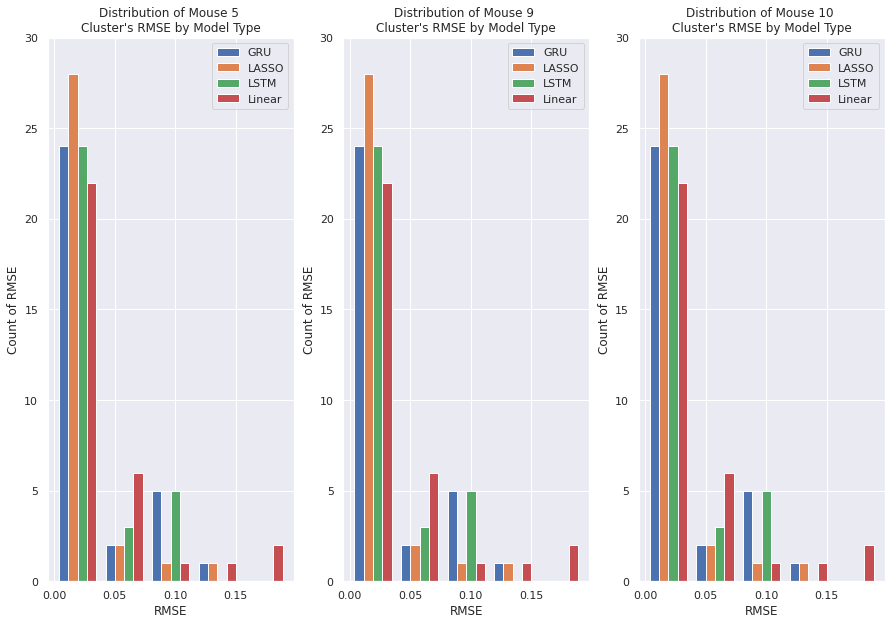

In [ ]:
rmse_table5_long=pd.DataFrame({"Cluster":np.tile(rmse_table5.Cluster,4),
                               "Model Type":np.concatenate([np.repeat("Linear",32),np.repeat("LASSO",32),np.repeat("GRU",32),np.repeat("LSTM",32)]),
                               "RMSE": np.concatenate([np.array(rmse_table5["Linear Model"]),np.array(rmse_table5["Lasso"]),np.array(rmse_table5["GRU"]),np.array(rmse_table5["LSTM"])])}
)

rmse_table9_long=pd.DataFrame({"Cluster":np.tile(rmse_table9.Cluster,4),
                               "Model Type":np.concatenate([np.repeat("Linear",32),np.repeat("LASSO",32),np.repeat("GRU",32),np.repeat("LSTM",32)]),
                               "RMSE": np.concatenate([np.array(rmse_table9["Linear Model"]),np.array(rmse_table9["Lasso"]),np.array(rmse_table9["GRU"]),np.array(rmse_table5["LSTM"])])}
)

rmse_table10_long=pd.DataFrame({"Cluster":np.tile(rmse_table10.Cluster,4),
                               "Model Type":np.concatenate([np.repeat("Linear",32),np.repeat("LASSO",32),np.repeat("GRU",32),np.repeat("LSTM",32)]),
                               "RMSE": np.concatenate([np.array(rmse_table10["Linear Model"]),np.array(rmse_table10["Lasso"]),np.array(rmse_table10["GRU"]),np.array(rmse_table5["LSTM"])])}
)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,10))

ax1.hist([rmse_table5_long.loc[rmse_table5_long["Model Type"] == x, 'RMSE'] for x in np.unique(rmse_table5_long["Model Type"])],
         label=np.unique(rmse_table5_long["Model Type"]),
         bins=5)
ax1.set_title("Distribution of Mouse 5 \nCluster's RMSE by Model Type")
ax1.set_ylim([0,30])
ax1.set(xlabel='RMSE', ylabel='Count of RMSE')
ax1.legend()

ax2.hist([rmse_table5_long.loc[rmse_table9_long["Model Type"] == x, 'RMSE'] for x in np.unique(rmse_table9_long["Model Type"])],
         label=np.unique(rmse_table9_long["Model Type"]),
         bins=5)
ax2.set_title("Distribution of Mouse 9 \nCluster's RMSE by Model Type")
ax2.set_ylim([0,30])
ax2.set(xlabel='RMSE', ylabel='Count of RMSE')
ax2.legend()

ax3.hist([rmse_table5_long.loc[rmse_table10_long["Model Type"] == x, 'RMSE'] for x in np.unique(rmse_table10_long["Model Type"])],
         label=np.unique(rmse_table10_long["Model Type"]),
         bins=5)
ax3.set_title("Distribution of Mouse 10 \nCluster's RMSE by Model Type")
ax3.set_ylim([0,30])
ax3.set(xlabel='RMSE', ylabel='Count of RMSE')
ax3.legend()
fig.show()
fig.tight_layout

<bound method Figure.tight_layout of <Figure size 1080x720 with 3 Axes>>

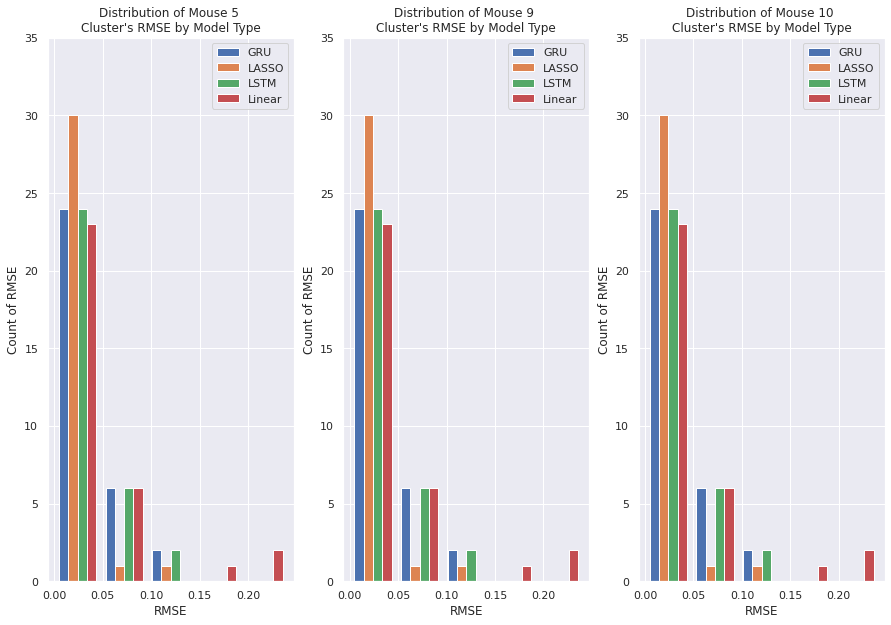

In [ ]:
rmse_table5_long=pd.DataFrame({"Cluster":np.tile(rmse_table5_steady_states.Cluster,4),
                               "Model Type":np.concatenate([np.repeat("Linear",32),np.repeat("LASSO",32),np.repeat("GRU",32),np.repeat("LSTM",32)]),
                               "RMSE": np.concatenate([np.array(rmse_table5_steady_states["Linear Model"]),np.array(rmse_table5_steady_states["Lasso"]),np.array(rmse_table5_steady_states["GRU"]),np.array(rmse_table5_steady_states["LSTM"])])}
)

rmse_table9_long=pd.DataFrame({"Cluster":np.tile(rmse_table9_steady_states.Cluster,4),
                               "Model Type":np.concatenate([np.repeat("Linear",32),np.repeat("LASSO",32),np.repeat("GRU",32),np.repeat("LSTM",32)]),
                               "RMSE": np.concatenate([np.array(rmse_table9_steady_states["Linear Model"]),np.array(rmse_table9_steady_states["Lasso"]),np.array(rmse_table9_steady_states["GRU"]),np.array(rmse_table9_steady_states["LSTM"])])}
)

rmse_table10_long=pd.DataFrame({"Cluster":np.tile(rmse_table10_steady_states.Cluster,4),
                               "Model Type":np.concatenate([np.repeat("Linear",32),np.repeat("LASSO",32),np.repeat("GRU",32),np.repeat("LSTM",32)]),
                               "RMSE": np.concatenate([np.array(rmse_table10_steady_states["Linear Model"]),np.array(rmse_table10_steady_states["Lasso"]),np.array(rmse_table10_steady_states["GRU"]),np.array(rmse_table10_steady_states["LSTM"])])}
)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,10))

ax1.hist([rmse_table5_long.loc[rmse_table5_long["Model Type"] == x, 'RMSE'] for x in np.unique(rmse_table5_long["Model Type"])],
         label=np.unique(rmse_table5_long["Model Type"]),
         bins=5)
ax1.set_title("Distribution of Mouse 5 \nCluster's RMSE by Model Type")
ax1.set_ylim([0,35])
ax1.set(xlabel='RMSE', ylabel='Count of RMSE')
ax1.legend()

ax2.hist([rmse_table5_long.loc[rmse_table9_long["Model Type"] == x, 'RMSE'] for x in np.unique(rmse_table9_long["Model Type"])],
         label=np.unique(rmse_table9_long["Model Type"]),
         bins=5)
ax2.set_title("Distribution of Mouse 9 \nCluster's RMSE by Model Type")
ax2.set_ylim([0,35])
ax2.set(xlabel='RMSE', ylabel='Count of RMSE')
ax2.legend()

ax3.hist([rmse_table5_long.loc[rmse_table10_long["Model Type"] == x, 'RMSE'] for x in np.unique(rmse_table10_long["Model Type"])],
         label=np.unique(rmse_table10_long["Model Type"]),
         bins=5)
ax3.set_title("Distribution of Mouse 10 \nCluster's RMSE by Model Type")
ax3.set_ylim([0,35])
ax3.set(xlabel='RMSE', ylabel='Count of RMSE')
ax3.legend()
fig.show()
fig.tight_layout

Comparing the distribution of cluster RMSE for each model across all time periods, LASSO has the most low RMSE and tends to have very few outlier values. GRU has the second best distribution, followed by LSTM and then the linear model. When subsetting to just the latent steady state periods between perturbations, the LASSO still has the lowest distribution of RMSE.

# Discussion

Overall the linear regression model does follow the general trend of the relative proportions for each mouse, but has some extreme predictions within the latent steady state periods. This may be due to potentially overfitting on the training set, where some mice could have had some changes in their cluster proportions at different time periods in the steady states. The Lasso model has similar trends to the linear regression model, but has less volatile and more smooth predictions that follow the actual proportions. While many of the clusters have very small proportions (less than 0.6%) across all time periods, the linear and lasso regression models still capture some of the fluctuations.

With regard to our deep learning model, we can see that, overall, the GRU seemed to have performed better than the LSTM as there the RSMEs for the GRU are consistently lower than the RMSEs than the LST. Hence, for our main conclusions, we take the GRUs conclusions.

The GRU makes three main predictions, although more research needs to be conducted for more robust results. First, it seems to predict that the healthy mouse had less proportions of both cluster 0 and cluster 1, implying a more even distribution of the microbiome. Hence, it seems it indicate that a healthier gut is a more diverse gut. Second, the perturbations may have an effect on the latent steady states. For example, for vancomycin, it seems that after the perturbation, the proportions of cluster 0 seemed to increase for both health types. Third, within cluster, the trends caused by the perturbations seems to be consistent across health types but different in magnitude.

When comparing all four models, the GRU and LSTM perform better for the clusters that take up a larger proportion of the microbiome environment, such as Cluster 0 and Cluster 1. However, when it comes to the clusters with a low proportion, the GRU and LSTM fail to fit on the lower numbers, while the linear regression and lasso model do have some fluctuations that follow the actual trends, as shown in the RMSE results.

# Future Work

If we had the time and resources, we would collect more samples more frequently and for a longer period so we could have a more accurate representation of how the perturbations would changet the microbiome environment. Furthermore, we would consider changing the number of clusters to see whether our predictions are just as accurate. Lastly, we did not filter out any of the ASV's because we did not think the ASV's with small read counts would make a significant difference when aggregating up to 32 clusters. For future work, we would consider removing some of these ASV's, as it might improve the predictions for the lower relative proportion clusters.